dataset  
http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz

https://github.com/ShopRunner/jupyter-notify
```
pip install jupyternotify
```

In [1]:
import tensorflow as tf
import numpy as np
import re
import os
import time
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
%matplotlib inline
%load_ext jupyternotify

/Users/tdual/anaconda2/envs/py3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


<IPython.core.display.Javascript object>

In [2]:
class TextCNN:

    def __init__(
      self, sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):


        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        l2_loss = tf.constant(0.0)


        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

 
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expanded,W,strides=[1, 1, 1, 1],padding="VALID", name="conv")
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1],strides=[1, 1, 1, 1],padding='VALID',name="pool")
                pooled_outputs.append(pooled)


        num_filters_total = num_filters * len(filter_sizes)
        print(num_filters_total)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        

        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)
            
                            # add@@@@@@@@
            features_size = 5
            self.features = tf.Variable(tf.truncated_normal([num_filters_total, features_size], stddev=0.1))
            # 384 * 5
            self.f_h = tf.matmul(self.h_drop, self.features, )
              # (None * 383) *(384 * 5) 
            #print(self.h_drop) #None * 384 
            #print(self.f_h) # None * 5



        with tf.name_scope("output"):
            W = tf.get_variable("W", shape=[features_size, num_classes], initializer=tf.contrib.layers.xavier_initializer())
            #W = tf.get_variable("W", shape=[num_filters_total, num_classes], initializer=tf.contrib.layers.xavier_initializer())
            

            
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            #self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.scores = tf.nn.xw_plus_b(self.f_h, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [3]:
# Parameters
# ==================================================

# Data loading params
dev_sample_percentage = 0.0005

positive_data_file = "data/amazon/book_pos.txt"#"./data/rt-polarity.pos"
negative_data_file = "data/amazon/book_neg.txt"#"./data/rt-polarity.neg" #"Data source for the negative data.")
#positive_data_file = "data/chABSA/pos.txt"
#negative_data_file = "data/chABSA/neg.txt"

# Model Hyperparameters
embedding_dim = 128     #, "Dimensionality of character embedding (default: 128)")
filter_sizes = "3,4,5"        #, "Comma-separated filter sizes (default: '3,4,5')")
num_filters=128               #, "Number of filters per filter size (default: 128)")
dropout_keep_prob=0.5 #, "Dropout keep probability (default: 0.5)")
l2_reg_lambda=0.0          #, "L2 regularization lambda (default: 0.0)")

# Training parameters
batch_size=64                    #, "Batch Size (default: 64)")
num_epochs=200              #, "Number of training epochs (default: 200)")
evaluate_every=100         #, "Evaluate model on dev set after this many steps (default: 100)")
num_checkpoints=5          #, "Number of checkpoints to store (default: 5)")

# Misc Parameters
allow_soft_placement=True    #, "Allow device soft device placement")
log_device_placement=False  #, "Log placement of ops on devices")

#FLAGS = tf.flags.FLAGS
#FLAGS._parse_flags()
#print("\nParameters:")
#for attr, value in sorted(FLAGS.__flags.items()):
#    print("{}={}".format(attr.upper(), value))
#print("")

In [4]:
def load_data_and_labels(positive_data_file, negative_data_file):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    #positive_examples = [s.strip() for s in positive_examples]
    positive_examples = [s.replace(" ", "").replace("", " ") for s in positive_examples]
    
    negative_examples = list(open(negative_data_file, "r").readlines())
    negative_examples = [s.replace(" ", "").replace("", " ") for s in negative_examples]
    #negative_examples = [s.strip() for s in negative_examples]

    x_text = positive_examples + negative_examples
    #x_text = [clean_str(sent) for sent in x_text]

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    return [x_text, y]

In [5]:
%%notify
x_text, y = load_data_and_labels(positive_data_file, negative_data_file)

<IPython.core.display.Javascript object>

In [6]:
len(x_text)

1000000

In [7]:
x_text[0]

' L o v e t h e c h a r a c t e r s . L o v e t h e l o c a t i o n ! I c a n n o t w a i t f o r t h e n e x t b o o k i n t h e s e r i e s . I w i l l c e r t a i n l y r e a d i t . \n '

In [8]:
length_list = np.array([len(r)for r in x_text])

In [9]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,187
1,399
2,621
3,215
4,225


In [10]:
df.describe()

,length
count,1000000.000000
mean,842.351232
std,1119.140102
min,3.000000
25%,255.000000
50%,447.000000
75%,931.000000
max,48939.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2918d7b8>]],
      dtype=object)

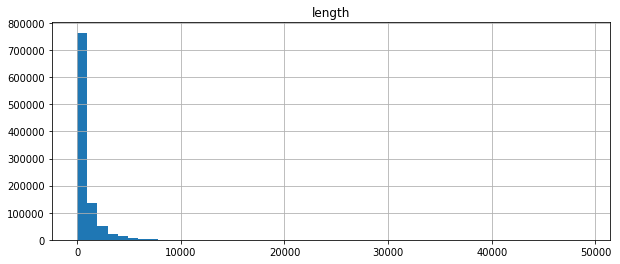

In [11]:
df.hist(bins=50,figsize=(10,4))

In [12]:
x_text = [x[:1000] if len(x) > 1000 else x for x in x_text]

In [13]:
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe()

,length
count,1000000.000000
mean,544.814889
std,315.692982
min,3.000000
25%,255.000000
50%,447.000000
75%,931.000000
max,1000.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ec304a8>]],
      dtype=object)

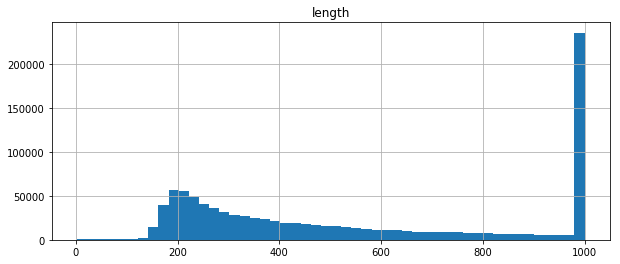

In [14]:
df.hist(bins=50,figsize=(10,4))

In [15]:
#x_text = x_text[:20000]
#y = y[:20000]

In [16]:
lang = "Ja" #"En"

In [17]:
if lang == "En":
    max_document_length = max([len(x.split(" ")) for x in x_text])
elif lang == "Ja":
    max_document_length = max([len(x) for x in x_text])
print("max document length", max_document_length)

max document length 1000


In [22]:
vocab_processor = preprocessing.VocabularyProcessor(max_document_length)

<IPython.core.display.Javascript object>

In [25]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

<IPython.core.display.Javascript object>

In [26]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

dev_sample_index = -1 * int(dev_sample_percentage * float(len(y)))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]

del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))

Vocabulary Size: 66
Train/Dev split: 999500/500


<IPython.core.display.Javascript object>

In [27]:
print(x_train.shape)

(999500, 1000)


In [28]:
def save_pickle():
    chunk_size =  int(len(x_train)/10)
    print(chunk_size)
    for i in range(0, len(x_train), chunck_size):
        print(i)
        end = i+chunck_size
        if end < len(x_train):
            chunk = x_train[i:  end]
        else:
            chunk = x_train[i:]
            end = len(x_train)
        with open("data/x_train_{}.pkl".format(end), "wb") as f:
            pickle.dump(chunk, f, protocol = 4)

In [29]:
def load_x_train():
    all_size = 999000
    chunk_size = 99900
    x_train =[]
    for i in range(0, all_size, chunck_size):
        print(i)
        end = i+chunk_size
        if end > len(reviews):
            end = all_size
        with open("data/x_train_{}.pkl".format(end), "rb") as f:
            x_train += pickle.load(f)
        return x_train
#x_train = load_x_train()

In [30]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [31]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)
embedding_size = embedding_dim
filter_sizes = list(map(int, filter_sizes.split(",")))
num_filters = num_filters
l2_reg_lambda = l2_reg_lambda

In [ ]:
save_checkpoint = True

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    
    with sess.as_default():
        
        cnn = TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)


        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)


        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))


        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)


        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)


        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        if save_checkpoint:
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
        vocab_processor.save(os.path.join(out_dir, "vocab"))


        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)


        batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % evaluate_every == 0:
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")
                
            if save_checkpoint and current_step % evaluate_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

384
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illegal; using conv-maxpool-4/W_0/grad/hist instead.
INFO:

2018-05-04T13:37:59.352340: step 89, loss 0.822404, acc 0.609375
2018-05-04T13:38:00.737802: step 90, loss 0.600726, acc 0.734375
2018-05-04T13:38:02.183978: step 91, loss 0.667795, acc 0.734375
2018-05-04T13:38:03.449266: step 92, loss 0.81888, acc 0.609375
2018-05-04T13:38:04.875516: step 93, loss 0.671639, acc 0.671875
2018-05-04T13:38:06.390742: step 94, loss 0.78696, acc 0.625
2018-05-04T13:38:08.098449: step 95, loss 0.736296, acc 0.671875
2018-05-04T13:38:09.760748: step 96, loss 0.865418, acc 0.65625
2018-05-04T13:38:11.504977: step 97, loss 0.671652, acc 0.71875
2018-05-04T13:38:13.210843: step 98, loss 0.87729, acc 0.625
2018-05-04T13:38:14.857164: step 99, loss 0.812422, acc 0.6875
2018-05-04T13:38:16.393501: step 100, loss 0.977846, acc 0.59375

Evaluation:
2018-05-04T13:38:20.378779: step 100, loss 0.536663, acc 0.706

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-100

2018-05-04T13:38:22.749729: step 101, loss 0.894264, 

2018-05-04T13:42:13.982753: step 210, loss 0.602437, acc 0.71875
2018-05-04T13:42:15.393200: step 211, loss 0.667484, acc 0.625
2018-05-04T13:42:16.877644: step 212, loss 0.532241, acc 0.78125
2018-05-04T13:42:18.299035: step 213, loss 0.609929, acc 0.71875
2018-05-04T13:42:19.759016: step 214, loss 0.742268, acc 0.59375
2018-05-04T13:42:21.262313: step 215, loss 0.731759, acc 0.65625
2018-05-04T13:42:22.724898: step 216, loss 0.642537, acc 0.640625
2018-05-04T13:42:24.123663: step 217, loss 0.740346, acc 0.65625
2018-05-04T13:42:25.538916: step 218, loss 0.665386, acc 0.6875
2018-05-04T13:42:26.993820: step 219, loss 0.499142, acc 0.8125
2018-05-04T13:42:28.446340: step 220, loss 0.627676, acc 0.65625
2018-05-04T13:42:29.872794: step 221, loss 0.803418, acc 0.625
2018-05-04T13:42:31.322520: step 222, loss 0.528306, acc 0.75
2018-05-04T13:42:32.789815: step 223, loss 0.686268, acc 0.640625
2018-05-04T13:42:34.227061: step 224, loss 0.774166, acc 0.5625
2018-05-04T13:42:35.653710: step 

2018-05-04T13:45:25.498623: step 334, loss 0.604237, acc 0.640625
2018-05-04T13:45:26.903967: step 335, loss 0.474487, acc 0.828125
2018-05-04T13:45:28.362681: step 336, loss 0.547836, acc 0.734375
2018-05-04T13:45:29.954722: step 337, loss 0.561673, acc 0.6875
2018-05-04T13:45:31.756694: step 338, loss 0.537845, acc 0.734375
2018-05-04T13:45:33.472241: step 339, loss 0.591282, acc 0.640625
2018-05-04T13:45:35.031763: step 340, loss 0.488786, acc 0.765625
2018-05-04T13:45:36.557856: step 341, loss 0.596917, acc 0.6875
2018-05-04T13:45:38.003688: step 342, loss 0.600303, acc 0.78125
2018-05-04T13:45:39.340626: step 343, loss 0.514963, acc 0.734375
2018-05-04T13:45:40.747200: step 344, loss 0.553534, acc 0.671875
2018-05-04T13:45:42.180752: step 345, loss 0.434891, acc 0.84375
2018-05-04T13:45:43.621367: step 346, loss 0.579624, acc 0.734375
2018-05-04T13:45:44.981580: step 347, loss 0.606427, acc 0.78125
2018-05-04T13:45:46.337351: step 348, loss 0.599379, acc 0.671875
2018-05-04T13:45:

2018-05-04T13:48:32.789727: step 458, loss 0.457891, acc 0.828125
2018-05-04T13:48:34.386482: step 459, loss 0.611198, acc 0.625
2018-05-04T13:48:35.957660: step 460, loss 0.460599, acc 0.75
2018-05-04T13:48:37.496965: step 461, loss 0.549339, acc 0.765625
2018-05-04T13:48:39.033063: step 462, loss 0.68002, acc 0.578125
2018-05-04T13:48:40.618904: step 463, loss 0.694736, acc 0.65625
2018-05-04T13:48:42.149515: step 464, loss 0.49982, acc 0.71875
2018-05-04T13:48:43.907486: step 465, loss 0.563683, acc 0.71875
2018-05-04T13:48:45.541651: step 466, loss 0.535921, acc 0.75
2018-05-04T13:48:47.062713: step 467, loss 0.500971, acc 0.765625
2018-05-04T13:48:48.636103: step 468, loss 0.634062, acc 0.6875
2018-05-04T13:48:50.258526: step 469, loss 0.51679, acc 0.75
2018-05-04T13:48:51.789129: step 470, loss 0.501391, acc 0.765625
2018-05-04T13:48:53.351214: step 471, loss 0.51774, acc 0.765625
2018-05-04T13:48:55.023770: step 472, loss 0.394941, acc 0.875
2018-05-04T13:48:56.629771: step 473,

2018-05-04T13:51:47.027347: step 582, loss 0.497106, acc 0.734375
2018-05-04T13:51:48.685258: step 583, loss 0.535879, acc 0.6875
2018-05-04T13:51:50.270135: step 584, loss 0.48197, acc 0.796875
2018-05-04T13:51:51.843877: step 585, loss 0.493366, acc 0.78125
2018-05-04T13:51:53.518643: step 586, loss 0.407964, acc 0.828125
2018-05-04T13:51:55.113882: step 587, loss 0.543662, acc 0.765625
2018-05-04T13:51:56.682031: step 588, loss 0.531545, acc 0.734375
2018-05-04T13:51:58.288242: step 589, loss 0.560524, acc 0.71875
2018-05-04T13:51:59.888409: step 590, loss 0.484806, acc 0.734375
2018-05-04T13:52:01.516286: step 591, loss 0.569534, acc 0.734375
2018-05-04T13:52:03.245084: step 592, loss 0.507125, acc 0.765625
2018-05-04T13:52:04.852708: step 593, loss 0.426121, acc 0.84375
2018-05-04T13:52:06.494686: step 594, loss 0.424819, acc 0.859375
2018-05-04T13:52:08.132927: step 595, loss 0.47866, acc 0.75
2018-05-04T13:52:09.875410: step 596, loss 0.572902, acc 0.734375
2018-05-04T13:52:11.6

2018-05-04T13:54:58.699716: step 703, loss 0.586014, acc 0.734375
2018-05-04T13:55:00.267957: step 704, loss 0.571493, acc 0.765625
2018-05-04T13:55:01.821669: step 705, loss 0.622219, acc 0.671875
2018-05-04T13:55:03.400327: step 706, loss 0.442743, acc 0.75
2018-05-04T13:55:04.937582: step 707, loss 0.427576, acc 0.78125
2018-05-04T13:55:06.501384: step 708, loss 0.46785, acc 0.828125
2018-05-04T13:55:08.056930: step 709, loss 0.607073, acc 0.734375
2018-05-04T13:55:09.638152: step 710, loss 0.3558, acc 0.828125
2018-05-04T13:55:11.174659: step 711, loss 0.528963, acc 0.734375
2018-05-04T13:55:12.649258: step 712, loss 0.516998, acc 0.734375
2018-05-04T13:55:14.167510: step 713, loss 0.382792, acc 0.828125
2018-05-04T13:55:15.714990: step 714, loss 0.603107, acc 0.71875
2018-05-04T13:55:17.219440: step 715, loss 0.498104, acc 0.734375
2018-05-04T13:55:18.727458: step 716, loss 0.594664, acc 0.671875
2018-05-04T13:55:20.180191: step 717, loss 0.428853, acc 0.8125
2018-05-04T13:55:21.7

2018-05-04T13:58:10.960726: step 827, loss 0.524642, acc 0.78125
2018-05-04T13:58:12.742752: step 828, loss 0.578015, acc 0.6875
2018-05-04T13:58:14.345437: step 829, loss 0.435884, acc 0.796875
2018-05-04T13:58:15.960617: step 830, loss 0.373964, acc 0.8125
2018-05-04T13:58:17.544814: step 831, loss 0.42143, acc 0.796875
2018-05-04T13:58:19.198579: step 832, loss 0.393866, acc 0.8125
2018-05-04T13:58:20.764023: step 833, loss 0.446854, acc 0.828125
2018-05-04T13:58:22.459183: step 834, loss 0.2639, acc 0.921875
2018-05-04T13:58:24.114729: step 835, loss 0.40436, acc 0.8125
2018-05-04T13:58:25.957404: step 836, loss 0.37946, acc 0.8125
2018-05-04T13:58:27.657741: step 837, loss 0.447126, acc 0.828125
2018-05-04T13:58:29.288954: step 838, loss 0.477635, acc 0.765625
2018-05-04T13:58:31.222571: step 839, loss 0.37724, acc 0.828125
2018-05-04T13:58:33.181896: step 840, loss 0.456709, acc 0.84375
2018-05-04T13:58:35.202335: step 841, loss 0.411581, acc 0.78125
2018-05-04T13:58:36.967498: s

2018-05-04T14:00:47.319617: step 951, loss 0.331463, acc 0.84375
2018-05-04T14:00:48.489831: step 952, loss 0.352452, acc 0.8125
2018-05-04T14:00:49.657397: step 953, loss 0.535593, acc 0.703125
2018-05-04T14:00:50.981212: step 954, loss 0.470935, acc 0.78125
2018-05-04T14:00:52.247841: step 955, loss 0.364547, acc 0.8125
2018-05-04T14:00:53.499582: step 956, loss 0.394871, acc 0.78125
2018-05-04T14:00:54.677941: step 957, loss 0.345474, acc 0.875
2018-05-04T14:00:55.824543: step 958, loss 0.499485, acc 0.734375
2018-05-04T14:00:56.966083: step 959, loss 0.508112, acc 0.71875
2018-05-04T14:00:58.125159: step 960, loss 0.434401, acc 0.8125
2018-05-04T14:00:59.299677: step 961, loss 0.411049, acc 0.828125
2018-05-04T14:01:00.461313: step 962, loss 0.323779, acc 0.890625
2018-05-04T14:01:01.702971: step 963, loss 0.571848, acc 0.71875
2018-05-04T14:01:02.871302: step 964, loss 0.35411, acc 0.828125
2018-05-04T14:01:04.038467: step 965, loss 0.50297, acc 0.796875
2018-05-04T14:01:05.201602

2018-05-04T14:03:20.380593: step 1074, loss 0.43194, acc 0.828125
2018-05-04T14:03:21.646660: step 1075, loss 0.418172, acc 0.8125
2018-05-04T14:03:22.874319: step 1076, loss 0.382744, acc 0.875
2018-05-04T14:03:24.107512: step 1077, loss 0.35834, acc 0.828125
2018-05-04T14:03:25.323880: step 1078, loss 0.386823, acc 0.8125
2018-05-04T14:03:26.533896: step 1079, loss 0.45998, acc 0.828125
2018-05-04T14:03:27.758347: step 1080, loss 0.413992, acc 0.859375
2018-05-04T14:03:28.930649: step 1081, loss 0.338836, acc 0.875
2018-05-04T14:03:30.139343: step 1082, loss 0.470061, acc 0.75
2018-05-04T14:03:31.367170: step 1083, loss 0.506234, acc 0.78125
2018-05-04T14:03:32.528083: step 1084, loss 0.400719, acc 0.84375
2018-05-04T14:03:33.731749: step 1085, loss 0.361035, acc 0.875
2018-05-04T14:03:34.939077: step 1086, loss 0.433472, acc 0.84375
2018-05-04T14:03:36.103871: step 1087, loss 0.408002, acc 0.8125
2018-05-04T14:03:37.266097: step 1088, loss 0.345788, acc 0.84375
2018-05-04T14:03:38.4

2018-05-04T14:05:50.249707: step 1196, loss 0.384189, acc 0.84375
2018-05-04T14:05:51.523953: step 1197, loss 0.432496, acc 0.8125
2018-05-04T14:05:52.668532: step 1198, loss 0.336516, acc 0.875
2018-05-04T14:05:53.867814: step 1199, loss 0.467574, acc 0.75
2018-05-04T14:05:55.117922: step 1200, loss 0.507768, acc 0.796875

Evaluation:
2018-05-04T14:05:57.726457: step 1200, loss 0.324667, acc 0.872

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-1200

2018-05-04T14:05:59.070369: step 1201, loss 0.491986, acc 0.75
2018-05-04T14:06:00.361693: step 1202, loss 0.497889, acc 0.78125
2018-05-04T14:06:01.678467: step 1203, loss 0.370782, acc 0.8125
2018-05-04T14:06:02.825703: step 1204, loss 0.388794, acc 0.796875
2018-05-04T14:06:04.066608: step 1205, loss 0.444324, acc 0.84375
2018-05-04T14:06:05.289991: step 1206, loss 0.401263, acc 0.78125
2018-05-04T14:06:06.441390: step 1207, loss 0.397233, acc 0.84375
2018-05-04T14:06:07.605048: step 1

2018-05-04T14:08:15.669907: step 1315, loss 0.433822, acc 0.828125
2018-05-04T14:08:16.822831: step 1316, loss 0.436395, acc 0.765625
2018-05-04T14:08:17.866623: step 1317, loss 0.407367, acc 0.828125
2018-05-04T14:08:18.926452: step 1318, loss 0.401023, acc 0.8125
2018-05-04T14:08:19.973114: step 1319, loss 0.364628, acc 0.875
2018-05-04T14:08:21.082998: step 1320, loss 0.338983, acc 0.859375
2018-05-04T14:08:22.214643: step 1321, loss 0.616762, acc 0.734375
2018-05-04T14:08:23.258141: step 1322, loss 0.40774, acc 0.8125
2018-05-04T14:08:24.331144: step 1323, loss 0.378308, acc 0.828125
2018-05-04T14:08:25.361382: step 1324, loss 0.352843, acc 0.8125
2018-05-04T14:08:26.393065: step 1325, loss 0.357398, acc 0.84375
2018-05-04T14:08:27.446956: step 1326, loss 0.321535, acc 0.859375
2018-05-04T14:08:28.555325: step 1327, loss 0.411934, acc 0.828125
2018-05-04T14:08:29.768408: step 1328, loss 0.490511, acc 0.8125
2018-05-04T14:08:30.864752: step 1329, loss 0.46438, acc 0.796875
2018-05-0

2018-05-04T14:10:32.172961: step 1437, loss 0.366737, acc 0.8125
2018-05-04T14:10:33.324716: step 1438, loss 0.560028, acc 0.765625
2018-05-04T14:10:34.558543: step 1439, loss 0.4343, acc 0.78125
2018-05-04T14:10:35.698055: step 1440, loss 0.338277, acc 0.875
2018-05-04T14:10:36.927756: step 1441, loss 0.359787, acc 0.90625
2018-05-04T14:10:38.111610: step 1442, loss 0.440969, acc 0.8125
2018-05-04T14:10:39.302355: step 1443, loss 0.360864, acc 0.890625
2018-05-04T14:10:40.473249: step 1444, loss 0.270298, acc 0.9375
2018-05-04T14:10:41.716833: step 1445, loss 0.404849, acc 0.8125
2018-05-04T14:10:42.833750: step 1446, loss 0.366559, acc 0.84375
2018-05-04T14:10:44.016465: step 1447, loss 0.286816, acc 0.890625
2018-05-04T14:10:45.149263: step 1448, loss 0.327382, acc 0.84375
2018-05-04T14:10:46.295454: step 1449, loss 0.415982, acc 0.828125
2018-05-04T14:10:47.445148: step 1450, loss 0.347356, acc 0.84375
2018-05-04T14:10:48.589720: step 1451, loss 0.238329, acc 0.921875
2018-05-04T14

2018-05-04T14:12:56.062905: step 1559, loss 0.374546, acc 0.8125
2018-05-04T14:12:57.175761: step 1560, loss 0.419403, acc 0.84375
2018-05-04T14:12:58.308090: step 1561, loss 0.466079, acc 0.78125
2018-05-04T14:12:59.422256: step 1562, loss 0.294161, acc 0.9375
2018-05-04T14:13:00.575554: step 1563, loss 0.370665, acc 0.828125
2018-05-04T14:13:01.753398: step 1564, loss 0.386959, acc 0.875
2018-05-04T14:13:02.896522: step 1565, loss 0.332418, acc 0.875
2018-05-04T14:13:04.042012: step 1566, loss 0.380156, acc 0.828125
2018-05-04T14:13:05.216456: step 1567, loss 0.515222, acc 0.75
2018-05-04T14:13:06.373926: step 1568, loss 0.34004, acc 0.828125
2018-05-04T14:13:07.473859: step 1569, loss 0.2691, acc 0.875
2018-05-04T14:13:08.605990: step 1570, loss 0.345686, acc 0.8125
2018-05-04T14:13:09.790368: step 1571, loss 0.233291, acc 0.90625
2018-05-04T14:13:10.942749: step 1572, loss 0.448824, acc 0.8125
2018-05-04T14:13:12.109138: step 1573, loss 0.362864, acc 0.828125
2018-05-04T14:13:13.29

2018-05-04T14:15:17.408125: step 1681, loss 0.401895, acc 0.84375
2018-05-04T14:15:18.516443: step 1682, loss 0.352219, acc 0.84375
2018-05-04T14:15:19.645987: step 1683, loss 0.415952, acc 0.8125
2018-05-04T14:15:20.808130: step 1684, loss 0.299755, acc 0.828125
2018-05-04T14:15:21.971064: step 1685, loss 0.434957, acc 0.796875
2018-05-04T14:15:23.091745: step 1686, loss 0.475699, acc 0.765625
2018-05-04T14:15:24.205888: step 1687, loss 0.409267, acc 0.828125
2018-05-04T14:15:25.408538: step 1688, loss 0.266975, acc 0.90625
2018-05-04T14:15:26.511169: step 1689, loss 0.443588, acc 0.8125
2018-05-04T14:15:27.592007: step 1690, loss 0.468252, acc 0.765625
2018-05-04T14:15:28.689788: step 1691, loss 0.476913, acc 0.71875
2018-05-04T14:15:29.855228: step 1692, loss 0.326334, acc 0.875
2018-05-04T14:15:31.057850: step 1693, loss 0.346454, acc 0.90625
2018-05-04T14:15:32.237422: step 1694, loss 0.446283, acc 0.796875
2018-05-04T14:15:33.311076: step 1695, loss 0.308918, acc 0.859375
2018-05

2018-05-04T14:17:39.752391: step 1801, loss 0.326511, acc 0.875
2018-05-04T14:17:40.906712: step 1802, loss 0.289768, acc 0.84375
2018-05-04T14:17:42.066186: step 1803, loss 0.208667, acc 0.9375
2018-05-04T14:17:43.245022: step 1804, loss 0.285016, acc 0.890625
2018-05-04T14:17:44.377406: step 1805, loss 0.41174, acc 0.84375
2018-05-04T14:17:45.556794: step 1806, loss 0.24457, acc 0.90625
2018-05-04T14:17:46.698194: step 1807, loss 0.367187, acc 0.859375
2018-05-04T14:17:47.856904: step 1808, loss 0.296657, acc 0.90625
2018-05-04T14:17:48.986210: step 1809, loss 0.383023, acc 0.8125
2018-05-04T14:17:50.122538: step 1810, loss 0.395989, acc 0.828125
2018-05-04T14:17:51.265617: step 1811, loss 0.365238, acc 0.875
2018-05-04T14:17:52.352028: step 1812, loss 0.298597, acc 0.875
2018-05-04T14:17:53.436785: step 1813, loss 0.370796, acc 0.84375
2018-05-04T14:17:54.606650: step 1814, loss 0.386061, acc 0.8125
2018-05-04T14:17:55.722989: step 1815, loss 0.313332, acc 0.859375
2018-05-04T14:17:

2018-05-04T14:20:02.713239: step 1923, loss 0.306311, acc 0.875
2018-05-04T14:20:03.818141: step 1924, loss 0.322701, acc 0.875
2018-05-04T14:20:04.926951: step 1925, loss 0.250097, acc 0.890625
2018-05-04T14:20:06.046333: step 1926, loss 0.36466, acc 0.84375
2018-05-04T14:20:07.162337: step 1927, loss 0.266522, acc 0.890625
2018-05-04T14:20:08.286457: step 1928, loss 0.273839, acc 0.875
2018-05-04T14:20:09.438517: step 1929, loss 0.413996, acc 0.859375
2018-05-04T14:20:10.551428: step 1930, loss 0.400027, acc 0.78125
2018-05-04T14:20:11.712141: step 1931, loss 0.345047, acc 0.84375
2018-05-04T14:20:12.784942: step 1932, loss 0.240422, acc 0.921875
2018-05-04T14:20:13.866698: step 1933, loss 0.322639, acc 0.890625
2018-05-04T14:20:14.937706: step 1934, loss 0.267907, acc 0.921875
2018-05-04T14:20:16.002695: step 1935, loss 0.359848, acc 0.796875
2018-05-04T14:20:17.100235: step 1936, loss 0.302631, acc 0.828125
2018-05-04T14:20:18.194169: step 1937, loss 0.255703, acc 0.921875
2018-05-

2018-05-04T14:22:23.982813: step 2045, loss 0.19331, acc 0.9375
2018-05-04T14:22:25.109174: step 2046, loss 0.291218, acc 0.890625
2018-05-04T14:22:26.227740: step 2047, loss 0.532489, acc 0.703125
2018-05-04T14:22:27.338699: step 2048, loss 0.38472, acc 0.828125
2018-05-04T14:22:28.420544: step 2049, loss 0.479595, acc 0.828125
2018-05-04T14:22:29.555658: step 2050, loss 0.304748, acc 0.890625
2018-05-04T14:22:30.633521: step 2051, loss 0.353983, acc 0.90625
2018-05-04T14:22:31.784636: step 2052, loss 0.256888, acc 0.90625
2018-05-04T14:22:32.938098: step 2053, loss 0.403963, acc 0.828125
2018-05-04T14:22:34.145417: step 2054, loss 0.278657, acc 0.859375
2018-05-04T14:22:35.405522: step 2055, loss 0.344362, acc 0.859375
2018-05-04T14:22:36.662636: step 2056, loss 0.275632, acc 0.859375
2018-05-04T14:22:37.833492: step 2057, loss 0.415425, acc 0.828125
2018-05-04T14:22:38.963902: step 2058, loss 0.351495, acc 0.859375
2018-05-04T14:22:40.082219: step 2059, loss 0.368367, acc 0.84375
20

2018-05-04T14:24:46.240678: step 2167, loss 0.328192, acc 0.875
2018-05-04T14:24:47.338646: step 2168, loss 0.286234, acc 0.859375
2018-05-04T14:24:48.456026: step 2169, loss 0.3554, acc 0.875
2018-05-04T14:24:49.578249: step 2170, loss 0.358925, acc 0.84375
2018-05-04T14:24:50.701743: step 2171, loss 0.367828, acc 0.8125
2018-05-04T14:24:51.883497: step 2172, loss 0.284116, acc 0.859375
2018-05-04T14:24:52.999336: step 2173, loss 0.231624, acc 0.953125
2018-05-04T14:24:54.157656: step 2174, loss 0.35282, acc 0.875
2018-05-04T14:24:55.307820: step 2175, loss 0.37022, acc 0.8125
2018-05-04T14:24:56.459866: step 2176, loss 0.294819, acc 0.859375
2018-05-04T14:24:57.576479: step 2177, loss 0.396549, acc 0.796875
2018-05-04T14:24:58.780144: step 2178, loss 0.33824, acc 0.859375
2018-05-04T14:24:59.932762: step 2179, loss 0.371723, acc 0.796875
2018-05-04T14:25:01.118633: step 2180, loss 0.371175, acc 0.828125
2018-05-04T14:25:02.289247: step 2181, loss 0.400175, acc 0.84375
2018-05-04T14:2

2018-05-04T14:27:09.866630: step 2289, loss 0.279854, acc 0.875
2018-05-04T14:27:11.032332: step 2290, loss 0.206921, acc 0.953125
2018-05-04T14:27:12.164875: step 2291, loss 0.394449, acc 0.796875
2018-05-04T14:27:13.300942: step 2292, loss 0.358772, acc 0.828125
2018-05-04T14:27:14.468520: step 2293, loss 0.380842, acc 0.84375
2018-05-04T14:27:15.624989: step 2294, loss 0.323741, acc 0.828125
2018-05-04T14:27:16.776337: step 2295, loss 0.349453, acc 0.859375
2018-05-04T14:27:17.949739: step 2296, loss 0.288147, acc 0.875
2018-05-04T14:27:19.024685: step 2297, loss 0.399076, acc 0.828125
2018-05-04T14:27:20.151449: step 2298, loss 0.282838, acc 0.890625
2018-05-04T14:27:21.368662: step 2299, loss 0.324984, acc 0.84375
2018-05-04T14:27:22.521999: step 2300, loss 0.412408, acc 0.78125

Evaluation:
2018-05-04T14:27:25.346911: step 2300, loss 0.280448, acc 0.9

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-2300

2018-05-04T14:27:26.60640

2018-05-04T14:29:30.385569: step 2408, loss 0.232738, acc 0.921875
2018-05-04T14:29:31.544399: step 2409, loss 0.365663, acc 0.828125
2018-05-04T14:29:32.622905: step 2410, loss 0.271756, acc 0.90625
2018-05-04T14:29:33.719822: step 2411, loss 0.318237, acc 0.84375
2018-05-04T14:29:34.804694: step 2412, loss 0.307739, acc 0.84375
2018-05-04T14:29:35.888327: step 2413, loss 0.42239, acc 0.828125
2018-05-04T14:29:37.024949: step 2414, loss 0.314615, acc 0.890625
2018-05-04T14:29:38.208679: step 2415, loss 0.352494, acc 0.890625
2018-05-04T14:29:39.361920: step 2416, loss 0.301724, acc 0.90625
2018-05-04T14:29:40.458950: step 2417, loss 0.345478, acc 0.84375
2018-05-04T14:29:41.628295: step 2418, loss 0.505479, acc 0.765625
2018-05-04T14:29:42.707908: step 2419, loss 0.356767, acc 0.859375
2018-05-04T14:29:43.804952: step 2420, loss 0.341206, acc 0.859375
2018-05-04T14:29:44.894385: step 2421, loss 0.310392, acc 0.859375
2018-05-04T14:29:45.972104: step 2422, loss 0.365885, acc 0.78125
20

2018-05-04T14:31:50.697331: step 2530, loss 0.359865, acc 0.84375
2018-05-04T14:31:51.824027: step 2531, loss 0.303934, acc 0.90625
2018-05-04T14:31:52.909698: step 2532, loss 0.265035, acc 0.890625
2018-05-04T14:31:54.017840: step 2533, loss 0.325647, acc 0.875
2018-05-04T14:31:55.153872: step 2534, loss 0.337204, acc 0.8125
2018-05-04T14:31:56.281558: step 2535, loss 0.2501, acc 0.921875
2018-05-04T14:31:57.416241: step 2536, loss 0.457424, acc 0.84375
2018-05-04T14:31:58.529991: step 2537, loss 0.31762, acc 0.875
2018-05-04T14:31:59.656240: step 2538, loss 0.372458, acc 0.859375
2018-05-04T14:32:00.787439: step 2539, loss 0.320442, acc 0.90625
2018-05-04T14:32:01.953721: step 2540, loss 0.301366, acc 0.84375
2018-05-04T14:32:03.087879: step 2541, loss 0.328533, acc 0.875
2018-05-04T14:32:04.220381: step 2542, loss 0.338292, acc 0.8125
2018-05-04T14:32:05.350360: step 2543, loss 0.274359, acc 0.890625
2018-05-04T14:32:06.447148: step 2544, loss 0.419906, acc 0.828125
2018-05-04T14:32

2018-05-04T14:34:13.100348: step 2652, loss 0.458291, acc 0.75
2018-05-04T14:34:14.234817: step 2653, loss 0.292367, acc 0.859375
2018-05-04T14:34:15.361918: step 2654, loss 0.251835, acc 0.875
2018-05-04T14:34:16.427109: step 2655, loss 0.396861, acc 0.828125
2018-05-04T14:34:17.568031: step 2656, loss 0.358345, acc 0.859375
2018-05-04T14:34:18.721664: step 2657, loss 0.216547, acc 0.921875
2018-05-04T14:34:19.884035: step 2658, loss 0.273481, acc 0.890625
2018-05-04T14:34:21.098714: step 2659, loss 0.226092, acc 0.921875
2018-05-04T14:34:22.235241: step 2660, loss 0.374027, acc 0.90625
2018-05-04T14:34:23.384265: step 2661, loss 0.315561, acc 0.84375
2018-05-04T14:34:24.552692: step 2662, loss 0.245334, acc 0.859375
2018-05-04T14:34:25.689529: step 2663, loss 0.304055, acc 0.890625
2018-05-04T14:34:26.830583: step 2664, loss 0.180337, acc 0.921875
2018-05-04T14:34:27.989473: step 2665, loss 0.200529, acc 0.921875
2018-05-04T14:34:29.118116: step 2666, loss 0.277834, acc 0.859375
2018

2018-05-04T14:36:35.932576: step 2774, loss 0.281736, acc 0.875
2018-05-04T14:36:37.073038: step 2775, loss 0.299771, acc 0.921875
2018-05-04T14:36:38.253816: step 2776, loss 0.273395, acc 0.890625
2018-05-04T14:36:39.365192: step 2777, loss 0.432315, acc 0.828125
2018-05-04T14:36:40.449380: step 2778, loss 0.225947, acc 0.859375
2018-05-04T14:36:41.613247: step 2779, loss 0.299004, acc 0.875
2018-05-04T14:36:42.694755: step 2780, loss 0.291099, acc 0.875
2018-05-04T14:36:43.791234: step 2781, loss 0.446754, acc 0.796875
2018-05-04T14:36:44.930968: step 2782, loss 0.244281, acc 0.90625
2018-05-04T14:36:46.052423: step 2783, loss 0.284822, acc 0.9375
2018-05-04T14:36:47.186893: step 2784, loss 0.17375, acc 0.9375
2018-05-04T14:36:48.309871: step 2785, loss 0.343614, acc 0.890625
2018-05-04T14:36:49.426875: step 2786, loss 0.278967, acc 0.90625
2018-05-04T14:36:50.540573: step 2787, loss 0.436193, acc 0.828125
2018-05-04T14:36:51.721431: step 2788, loss 0.291839, acc 0.875
2018-05-04T14:

2018-05-04T14:38:58.111793: step 2896, loss 0.25324, acc 0.890625
2018-05-04T14:38:59.225978: step 2897, loss 0.27003, acc 0.9375
2018-05-04T14:39:00.359018: step 2898, loss 0.359748, acc 0.890625
2018-05-04T14:39:01.553085: step 2899, loss 0.293922, acc 0.90625
2018-05-04T14:39:02.702735: step 2900, loss 0.188905, acc 0.9375

Evaluation:
2018-05-04T14:39:05.444406: step 2900, loss 0.28569, acc 0.878

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-2900

2018-05-04T14:39:06.726586: step 2901, loss 0.243517, acc 0.90625
2018-05-04T14:39:07.947315: step 2902, loss 0.28232, acc 0.90625
2018-05-04T14:39:09.040171: step 2903, loss 0.337759, acc 0.859375
2018-05-04T14:39:10.226454: step 2904, loss 0.188033, acc 0.921875
2018-05-04T14:39:11.384840: step 2905, loss 0.31147, acc 0.921875
2018-05-04T14:39:12.474910: step 2906, loss 0.29678, acc 0.859375
2018-05-04T14:39:13.615691: step 2907, loss 0.406241, acc 0.828125
2018-05-04T14:39:14.735572:

2018-05-04T14:41:19.453543: step 3015, loss 0.354213, acc 0.828125
2018-05-04T14:41:20.574358: step 3016, loss 0.321559, acc 0.859375
2018-05-04T14:41:21.703042: step 3017, loss 0.318149, acc 0.875
2018-05-04T14:41:22.800319: step 3018, loss 0.243688, acc 0.921875
2018-05-04T14:41:23.889979: step 3019, loss 0.250813, acc 0.890625
2018-05-04T14:41:24.992561: step 3020, loss 0.245821, acc 0.90625
2018-05-04T14:41:26.161867: step 3021, loss 0.255738, acc 0.890625
2018-05-04T14:41:27.305037: step 3022, loss 0.275646, acc 0.90625
2018-05-04T14:41:28.415019: step 3023, loss 0.513654, acc 0.796875
2018-05-04T14:41:29.555640: step 3024, loss 0.398371, acc 0.828125
2018-05-04T14:41:30.737635: step 3025, loss 0.377265, acc 0.828125
2018-05-04T14:41:31.940331: step 3026, loss 0.454608, acc 0.8125
2018-05-04T14:41:33.030048: step 3027, loss 0.479537, acc 0.765625
2018-05-04T14:41:34.128349: step 3028, loss 0.261494, acc 0.859375
2018-05-04T14:41:35.232848: step 3029, loss 0.347046, acc 0.828125
20

2018-05-04T14:43:42.376586: step 3137, loss 0.264673, acc 0.90625
2018-05-04T14:43:43.503127: step 3138, loss 0.208966, acc 0.890625
2018-05-04T14:43:44.660205: step 3139, loss 0.375368, acc 0.8125
2018-05-04T14:43:45.791786: step 3140, loss 0.365133, acc 0.875
2018-05-04T14:43:46.935138: step 3141, loss 0.301771, acc 0.890625
2018-05-04T14:43:48.121240: step 3142, loss 0.238107, acc 0.90625
2018-05-04T14:43:49.206658: step 3143, loss 0.363427, acc 0.859375
2018-05-04T14:43:50.364544: step 3144, loss 0.459171, acc 0.796875
2018-05-04T14:43:51.551262: step 3145, loss 0.231486, acc 0.90625
2018-05-04T14:43:52.651715: step 3146, loss 0.375092, acc 0.875
2018-05-04T14:43:53.807699: step 3147, loss 0.408282, acc 0.8125
2018-05-04T14:43:54.947936: step 3148, loss 0.287267, acc 0.90625
2018-05-04T14:43:56.057338: step 3149, loss 0.332985, acc 0.859375
2018-05-04T14:43:57.188571: step 3150, loss 0.370877, acc 0.828125
2018-05-04T14:43:58.326292: step 3151, loss 0.227732, acc 0.890625
2018-05-0

2018-05-04T14:46:03.999771: step 3259, loss 0.265135, acc 0.859375
2018-05-04T14:46:05.207716: step 3260, loss 0.230294, acc 0.890625
2018-05-04T14:46:06.322100: step 3261, loss 0.313128, acc 0.921875
2018-05-04T14:46:07.498529: step 3262, loss 0.239453, acc 0.890625
2018-05-04T14:46:08.603369: step 3263, loss 0.218179, acc 0.90625
2018-05-04T14:46:09.744444: step 3264, loss 0.451267, acc 0.828125
2018-05-04T14:46:10.915292: step 3265, loss 0.18368, acc 0.921875
2018-05-04T14:46:12.073448: step 3266, loss 0.412911, acc 0.8125
2018-05-04T14:46:13.181976: step 3267, loss 0.183944, acc 0.9375
2018-05-04T14:46:14.324181: step 3268, loss 0.367458, acc 0.875
2018-05-04T14:46:15.425003: step 3269, loss 0.306875, acc 0.84375
2018-05-04T14:46:16.549853: step 3270, loss 0.291886, acc 0.859375
2018-05-04T14:46:17.693484: step 3271, loss 0.260273, acc 0.875
2018-05-04T14:46:18.804355: step 3272, loss 0.36044, acc 0.8125
2018-05-04T14:46:20.019597: step 3273, loss 0.323617, acc 0.890625
2018-05-04T

2018-05-04T14:48:26.775364: step 3381, loss 0.2981, acc 0.875
2018-05-04T14:48:27.897504: step 3382, loss 0.27569, acc 0.875
2018-05-04T14:48:29.021809: step 3383, loss 0.480394, acc 0.828125
2018-05-04T14:48:30.154586: step 3384, loss 0.288207, acc 0.875
2018-05-04T14:48:31.263516: step 3385, loss 0.255806, acc 0.953125
2018-05-04T14:48:32.363529: step 3386, loss 0.366005, acc 0.859375
2018-05-04T14:48:33.447606: step 3387, loss 0.442862, acc 0.796875
2018-05-04T14:48:34.564540: step 3388, loss 0.295813, acc 0.859375
2018-05-04T14:48:35.669845: step 3389, loss 0.287209, acc 0.890625
2018-05-04T14:48:36.791558: step 3390, loss 0.296589, acc 0.890625
2018-05-04T14:48:37.916565: step 3391, loss 0.36914, acc 0.890625
2018-05-04T14:48:39.037962: step 3392, loss 0.243221, acc 0.84375
2018-05-04T14:48:40.163700: step 3393, loss 0.316014, acc 0.859375
2018-05-04T14:48:41.343486: step 3394, loss 0.270537, acc 0.90625
2018-05-04T14:48:42.525062: step 3395, loss 0.413249, acc 0.828125
2018-05-04

2018-05-04T14:50:48.865692: step 3501, loss 0.300076, acc 0.921875
2018-05-04T14:50:50.065141: step 3502, loss 0.242278, acc 0.921875
2018-05-04T14:50:51.280625: step 3503, loss 0.305238, acc 0.84375
2018-05-04T14:50:52.397864: step 3504, loss 0.303536, acc 0.859375
2018-05-04T14:50:53.534902: step 3505, loss 0.294472, acc 0.859375
2018-05-04T14:50:54.676241: step 3506, loss 0.327886, acc 0.84375
2018-05-04T14:50:55.797748: step 3507, loss 0.255485, acc 0.875
2018-05-04T14:50:56.940789: step 3508, loss 0.484244, acc 0.75
2018-05-04T14:50:58.037545: step 3509, loss 0.398232, acc 0.78125
2018-05-04T14:50:59.146957: step 3510, loss 0.43669, acc 0.828125
2018-05-04T14:51:00.238654: step 3511, loss 0.356581, acc 0.84375
2018-05-04T14:51:01.392152: step 3512, loss 0.392947, acc 0.84375
2018-05-04T14:51:02.488407: step 3513, loss 0.22178, acc 0.953125
2018-05-04T14:51:03.705014: step 3514, loss 0.327122, acc 0.828125
2018-05-04T14:51:04.918612: step 3515, loss 0.272876, acc 0.875
2018-05-04T1

2018-05-04T14:53:11.154201: step 3623, loss 0.270084, acc 0.890625
2018-05-04T14:53:12.294698: step 3624, loss 0.363579, acc 0.8125
2018-05-04T14:53:13.392867: step 3625, loss 0.337294, acc 0.875
2018-05-04T14:53:14.583543: step 3626, loss 0.213525, acc 0.9375
2018-05-04T14:53:15.669771: step 3627, loss 0.174021, acc 0.9375
2018-05-04T14:53:16.838217: step 3628, loss 0.316485, acc 0.890625
2018-05-04T14:53:17.935370: step 3629, loss 0.287625, acc 0.875
2018-05-04T14:53:19.016633: step 3630, loss 0.409648, acc 0.828125
2018-05-04T14:53:20.129296: step 3631, loss 0.222499, acc 0.90625
2018-05-04T14:53:21.293336: step 3632, loss 0.308455, acc 0.84375
2018-05-04T14:53:22.471076: step 3633, loss 0.257414, acc 0.921875
2018-05-04T14:53:23.550667: step 3634, loss 0.28571, acc 0.84375
2018-05-04T14:53:24.667589: step 3635, loss 0.361109, acc 0.84375
2018-05-04T14:53:25.787047: step 3636, loss 0.213188, acc 0.953125
2018-05-04T14:53:26.891403: step 3637, loss 0.270336, acc 0.859375
2018-05-04T1

2018-05-04T14:55:33.154377: step 3745, loss 0.333672, acc 0.875
2018-05-04T14:55:34.368825: step 3746, loss 0.34278, acc 0.875
2018-05-04T14:55:35.600031: step 3747, loss 0.312911, acc 0.890625
2018-05-04T14:55:36.855252: step 3748, loss 0.190509, acc 0.9375
2018-05-04T14:55:38.088867: step 3749, loss 0.315283, acc 0.875
2018-05-04T14:55:39.242916: step 3750, loss 0.333599, acc 0.84375
2018-05-04T14:55:40.410883: step 3751, loss 0.340164, acc 0.859375
2018-05-04T14:55:41.654319: step 3752, loss 0.282823, acc 0.875
2018-05-04T14:55:42.821027: step 3753, loss 0.287978, acc 0.890625
2018-05-04T14:55:43.965721: step 3754, loss 0.180881, acc 0.9375
2018-05-04T14:55:45.099822: step 3755, loss 0.329066, acc 0.84375
2018-05-04T14:55:46.207101: step 3756, loss 0.232237, acc 0.90625
2018-05-04T14:55:47.325814: step 3757, loss 0.273178, acc 0.90625
2018-05-04T14:55:48.447751: step 3758, loss 0.217209, acc 0.9375
2018-05-04T14:55:49.579263: step 3759, loss 0.500887, acc 0.828125
2018-05-04T14:55:5

2018-05-04T14:57:56.204676: step 3867, loss 0.41455, acc 0.84375
2018-05-04T14:57:57.317975: step 3868, loss 0.263527, acc 0.90625
2018-05-04T14:57:58.438086: step 3869, loss 0.180273, acc 0.9375
2018-05-04T14:57:59.576950: step 3870, loss 0.316622, acc 0.859375
2018-05-04T14:58:00.704789: step 3871, loss 0.263684, acc 0.90625
2018-05-04T14:58:01.892743: step 3872, loss 0.180161, acc 0.9375
2018-05-04T14:58:03.014832: step 3873, loss 0.29167, acc 0.875
2018-05-04T14:58:04.151877: step 3874, loss 0.336389, acc 0.859375
2018-05-04T14:58:05.270535: step 3875, loss 0.292746, acc 0.90625
2018-05-04T14:58:06.404936: step 3876, loss 0.250057, acc 0.890625
2018-05-04T14:58:07.538809: step 3877, loss 0.311755, acc 0.890625
2018-05-04T14:58:08.671786: step 3878, loss 0.324177, acc 0.859375
2018-05-04T14:58:09.852857: step 3879, loss 0.358996, acc 0.875
2018-05-04T14:58:11.031321: step 3880, loss 0.4241, acc 0.859375
2018-05-04T14:58:12.222800: step 3881, loss 0.292007, acc 0.875
2018-05-04T14:58

2018-05-04T15:00:18.112870: step 3989, loss 0.350779, acc 0.8125
2018-05-04T15:00:19.182711: step 3990, loss 0.384549, acc 0.84375
2018-05-04T15:00:20.267227: step 3991, loss 0.344049, acc 0.828125
2018-05-04T15:00:21.464840: step 3992, loss 0.268032, acc 0.9375
2018-05-04T15:00:22.562364: step 3993, loss 0.439852, acc 0.828125
2018-05-04T15:00:23.694337: step 3994, loss 0.192752, acc 0.9375
2018-05-04T15:00:24.814058: step 3995, loss 0.380552, acc 0.875
2018-05-04T15:00:25.937639: step 3996, loss 0.355005, acc 0.828125
2018-05-04T15:00:27.047569: step 3997, loss 0.236987, acc 0.90625
2018-05-04T15:00:28.163934: step 3998, loss 0.325878, acc 0.859375
2018-05-04T15:00:29.298485: step 3999, loss 0.288553, acc 0.828125
2018-05-04T15:00:30.433455: step 4000, loss 0.279869, acc 0.875

Evaluation:
2018-05-04T15:00:33.005356: step 4000, loss 0.257104, acc 0.894

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-4000

2018-05-04T15:00:34.237583: 

2018-05-04T15:02:40.229345: step 4108, loss 0.325811, acc 0.84375
2018-05-04T15:02:41.436395: step 4109, loss 0.444479, acc 0.796875
2018-05-04T15:02:42.581170: step 4110, loss 0.249248, acc 0.875
2018-05-04T15:02:43.714813: step 4111, loss 0.233163, acc 0.921875
2018-05-04T15:02:44.897443: step 4112, loss 0.356833, acc 0.859375
2018-05-04T15:02:45.980771: step 4113, loss 0.298693, acc 0.890625
2018-05-04T15:02:47.153583: step 4114, loss 0.225199, acc 0.90625
2018-05-04T15:02:48.325078: step 4115, loss 0.282592, acc 0.875
2018-05-04T15:02:49.426167: step 4116, loss 0.328007, acc 0.875
2018-05-04T15:02:50.515438: step 4117, loss 0.256509, acc 0.921875
2018-05-04T15:02:51.654383: step 4118, loss 0.351605, acc 0.828125
2018-05-04T15:02:52.828635: step 4119, loss 0.377924, acc 0.828125
2018-05-04T15:02:53.923824: step 4120, loss 0.259873, acc 0.84375
2018-05-04T15:02:55.019040: step 4121, loss 0.193662, acc 0.953125
2018-05-04T15:02:56.121236: step 4122, loss 0.29548, acc 0.859375
2018-05-

2018-05-04T15:05:01.465994: step 4230, loss 0.406944, acc 0.8125
2018-05-04T15:05:02.620306: step 4231, loss 0.259834, acc 0.90625
2018-05-04T15:05:03.780799: step 4232, loss 0.255087, acc 0.921875
2018-05-04T15:05:04.937751: step 4233, loss 0.284763, acc 0.828125
2018-05-04T15:05:05.998476: step 4234, loss 0.312424, acc 0.859375
2018-05-04T15:05:07.089042: step 4235, loss 0.465315, acc 0.78125
2018-05-04T15:05:08.267132: step 4236, loss 0.385742, acc 0.890625
2018-05-04T15:05:09.474765: step 4237, loss 0.214934, acc 0.90625
2018-05-04T15:05:10.670261: step 4238, loss 0.290492, acc 0.90625
2018-05-04T15:05:11.900967: step 4239, loss 0.319629, acc 0.859375
2018-05-04T15:05:13.018988: step 4240, loss 0.197084, acc 0.9375
2018-05-04T15:05:14.211252: step 4241, loss 0.242462, acc 0.875
2018-05-04T15:05:15.378877: step 4242, loss 0.336499, acc 0.875
2018-05-04T15:05:16.562080: step 4243, loss 0.332241, acc 0.875
2018-05-04T15:05:17.759669: step 4244, loss 0.232146, acc 0.953125
2018-05-04T1

2018-05-04T15:07:26.124642: step 4352, loss 0.476511, acc 0.78125
2018-05-04T15:07:27.194139: step 4353, loss 0.344518, acc 0.84375
2018-05-04T15:07:28.291291: step 4354, loss 0.224103, acc 0.921875
2018-05-04T15:07:29.435627: step 4355, loss 0.296144, acc 0.875
2018-05-04T15:07:30.574767: step 4356, loss 0.446231, acc 0.8125
2018-05-04T15:07:31.749797: step 4357, loss 0.189454, acc 0.921875
2018-05-04T15:07:32.886509: step 4358, loss 0.290611, acc 0.90625
2018-05-04T15:07:34.093028: step 4359, loss 0.313733, acc 0.90625
2018-05-04T15:07:35.362575: step 4360, loss 0.273772, acc 0.859375
2018-05-04T15:07:36.574958: step 4361, loss 0.20931, acc 0.90625
2018-05-04T15:07:37.812824: step 4362, loss 0.243877, acc 0.859375
2018-05-04T15:07:39.026382: step 4363, loss 0.311495, acc 0.90625
2018-05-04T15:07:40.201427: step 4364, loss 0.234731, acc 0.9375
2018-05-04T15:07:41.353946: step 4365, loss 0.405509, acc 0.859375
2018-05-04T15:07:42.426787: step 4366, loss 0.227758, acc 0.90625
2018-05-04

2018-05-04T15:09:48.538395: step 4474, loss 0.324578, acc 0.84375
2018-05-04T15:09:49.700263: step 4475, loss 0.405392, acc 0.8125
2018-05-04T15:09:50.845203: step 4476, loss 0.401017, acc 0.8125
2018-05-04T15:09:52.034678: step 4477, loss 0.338328, acc 0.859375
2018-05-04T15:09:53.173067: step 4478, loss 0.277261, acc 0.890625
2018-05-04T15:09:54.312295: step 4479, loss 0.465089, acc 0.828125
2018-05-04T15:09:55.449074: step 4480, loss 0.230823, acc 0.90625
2018-05-04T15:09:56.594263: step 4481, loss 0.268799, acc 0.890625
2018-05-04T15:09:57.758547: step 4482, loss 0.294639, acc 0.890625
2018-05-04T15:09:58.895249: step 4483, loss 0.344333, acc 0.84375
2018-05-04T15:10:00.027656: step 4484, loss 0.235255, acc 0.921875
2018-05-04T15:10:01.232724: step 4485, loss 0.288654, acc 0.84375
2018-05-04T15:10:02.408028: step 4486, loss 0.327063, acc 0.828125
2018-05-04T15:10:03.564687: step 4487, loss 0.381784, acc 0.84375
2018-05-04T15:10:04.695778: step 4488, loss 0.218869, acc 0.921875
2018

2018-05-04T15:12:12.872244: step 4596, loss 0.371742, acc 0.828125
2018-05-04T15:12:14.020304: step 4597, loss 0.233121, acc 0.875
2018-05-04T15:12:15.148881: step 4598, loss 0.249837, acc 0.90625
2018-05-04T15:12:16.286166: step 4599, loss 0.32217, acc 0.875
2018-05-04T15:12:17.398098: step 4600, loss 0.254086, acc 0.890625

Evaluation:
2018-05-04T15:12:20.412358: step 4600, loss 0.25488, acc 0.904

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-4600

2018-05-04T15:12:21.708563: step 4601, loss 0.206883, acc 0.890625
2018-05-04T15:12:22.923183: step 4602, loss 0.188825, acc 0.9375
2018-05-04T15:12:24.106512: step 4603, loss 0.201354, acc 0.921875
2018-05-04T15:12:25.309751: step 4604, loss 0.409404, acc 0.828125
2018-05-04T15:12:26.561899: step 4605, loss 0.291605, acc 0.90625
2018-05-04T15:12:27.747436: step 4606, loss 0.290533, acc 0.890625
2018-05-04T15:12:28.909739: step 4607, loss 0.260286, acc 0.890625
2018-05-04T15:12:30.112829

2018-05-04T15:14:34.828278: step 4715, loss 0.317494, acc 0.859375
2018-05-04T15:14:36.005685: step 4716, loss 0.406882, acc 0.84375
2018-05-04T15:14:37.119676: step 4717, loss 0.26236, acc 0.921875
2018-05-04T15:14:38.215470: step 4718, loss 0.245725, acc 0.90625
2018-05-04T15:14:39.361219: step 4719, loss 0.290615, acc 0.875
2018-05-04T15:14:40.476020: step 4720, loss 0.225272, acc 0.921875
2018-05-04T15:14:41.668676: step 4721, loss 0.204114, acc 0.9375
2018-05-04T15:14:42.777586: step 4722, loss 0.343854, acc 0.828125
2018-05-04T15:14:43.895860: step 4723, loss 0.285576, acc 0.859375
2018-05-04T15:14:45.042531: step 4724, loss 0.184222, acc 0.9375
2018-05-04T15:14:46.232104: step 4725, loss 0.200297, acc 0.890625
2018-05-04T15:14:47.347178: step 4726, loss 0.247724, acc 0.90625
2018-05-04T15:14:48.518371: step 4727, loss 0.333282, acc 0.859375
2018-05-04T15:14:49.675835: step 4728, loss 0.240427, acc 0.921875
2018-05-04T15:14:50.755418: step 4729, loss 0.30145, acc 0.875
2018-05-04

2018-05-04T15:16:58.124870: step 4837, loss 0.387302, acc 0.84375
2018-05-04T15:16:59.349505: step 4838, loss 0.455106, acc 0.828125
2018-05-04T15:17:00.545103: step 4839, loss 0.386651, acc 0.84375
2018-05-04T15:17:01.776018: step 4840, loss 0.199962, acc 0.90625
2018-05-04T15:17:02.878557: step 4841, loss 0.276549, acc 0.921875
2018-05-04T15:17:03.997747: step 4842, loss 0.23471, acc 0.90625
2018-05-04T15:17:05.115879: step 4843, loss 0.417187, acc 0.8125
2018-05-04T15:17:06.204571: step 4844, loss 0.407981, acc 0.8125
2018-05-04T15:17:07.325806: step 4845, loss 0.353906, acc 0.859375
2018-05-04T15:17:08.460240: step 4846, loss 0.235921, acc 0.859375
2018-05-04T15:17:09.596025: step 4847, loss 0.247444, acc 0.90625
2018-05-04T15:17:10.742820: step 4848, loss 0.422692, acc 0.8125
2018-05-04T15:17:11.905601: step 4849, loss 0.308761, acc 0.875
2018-05-04T15:17:13.008857: step 4850, loss 0.288003, acc 0.84375
2018-05-04T15:17:14.141146: step 4851, loss 0.295752, acc 0.890625
2018-05-04T

2018-05-04T15:19:22.013037: step 4959, loss 0.40635, acc 0.796875
2018-05-04T15:19:23.138045: step 4960, loss 0.371967, acc 0.875
2018-05-04T15:19:24.276854: step 4961, loss 0.247181, acc 0.9375
2018-05-04T15:19:25.391496: step 4962, loss 0.322201, acc 0.859375
2018-05-04T15:19:26.547971: step 4963, loss 0.279553, acc 0.875
2018-05-04T15:19:27.704811: step 4964, loss 0.31168, acc 0.859375
2018-05-04T15:19:28.865284: step 4965, loss 0.467738, acc 0.828125
2018-05-04T15:19:30.033998: step 4966, loss 0.283384, acc 0.859375
2018-05-04T15:19:31.257979: step 4967, loss 0.33593, acc 0.859375
2018-05-04T15:19:32.426612: step 4968, loss 0.310614, acc 0.9375
2018-05-04T15:19:33.665099: step 4969, loss 0.328524, acc 0.890625
2018-05-04T15:19:34.922055: step 4970, loss 0.416223, acc 0.84375
2018-05-04T15:19:36.147441: step 4971, loss 0.172962, acc 0.96875
2018-05-04T15:19:37.408902: step 4972, loss 0.397531, acc 0.8125
2018-05-04T15:19:38.557959: step 4973, loss 0.44426, acc 0.8125
2018-05-04T15:1

2018-05-04T15:21:44.202406: step 5081, loss 0.29012, acc 0.875
2018-05-04T15:21:45.339271: step 5082, loss 0.346583, acc 0.890625
2018-05-04T15:21:46.471520: step 5083, loss 0.248528, acc 0.90625
2018-05-04T15:21:47.676230: step 5084, loss 0.364897, acc 0.859375
2018-05-04T15:21:48.829109: step 5085, loss 0.285433, acc 0.859375
2018-05-04T15:21:50.024312: step 5086, loss 0.395366, acc 0.796875
2018-05-04T15:21:51.197290: step 5087, loss 0.224725, acc 0.890625
2018-05-04T15:21:52.309278: step 5088, loss 0.39512, acc 0.84375
2018-05-04T15:21:53.439502: step 5089, loss 0.353197, acc 0.84375
2018-05-04T15:21:54.573112: step 5090, loss 0.253804, acc 0.890625
2018-05-04T15:21:55.760796: step 5091, loss 0.49404, acc 0.78125
2018-05-04T15:21:56.884543: step 5092, loss 0.252111, acc 0.875
2018-05-04T15:21:58.019130: step 5093, loss 0.21378, acc 0.921875
2018-05-04T15:21:59.204839: step 5094, loss 0.452289, acc 0.828125
2018-05-04T15:22:00.404746: step 5095, loss 0.229252, acc 0.890625
2018-05-0

2018-05-04T15:24:11.078382: step 5201, loss 0.304577, acc 0.90625
2018-05-04T15:24:12.278224: step 5202, loss 0.241975, acc 0.890625
2018-05-04T15:24:13.444501: step 5203, loss 0.426325, acc 0.890625
2018-05-04T15:24:14.711052: step 5204, loss 0.264017, acc 0.90625
2018-05-04T15:24:16.031239: step 5205, loss 0.420497, acc 0.84375
2018-05-04T15:24:17.194604: step 5206, loss 0.331525, acc 0.890625
2018-05-04T15:24:18.357549: step 5207, loss 0.34714, acc 0.859375
2018-05-04T15:24:19.501190: step 5208, loss 0.38404, acc 0.8125
2018-05-04T15:24:20.667317: step 5209, loss 0.404642, acc 0.78125
2018-05-04T15:24:21.860175: step 5210, loss 0.212401, acc 0.9375
2018-05-04T15:24:22.984896: step 5211, loss 0.365308, acc 0.890625
2018-05-04T15:24:24.134584: step 5212, loss 0.3753, acc 0.828125
2018-05-04T15:24:25.258328: step 5213, loss 0.29832, acc 0.875
2018-05-04T15:24:26.406658: step 5214, loss 0.246798, acc 0.859375
2018-05-04T15:24:27.527365: step 5215, loss 0.242891, acc 0.921875
2018-05-04T

2018-05-04T15:26:35.780052: step 5323, loss 0.446678, acc 0.8125
2018-05-04T15:26:36.922485: step 5324, loss 0.318431, acc 0.859375
2018-05-04T15:26:38.043339: step 5325, loss 0.545757, acc 0.765625
2018-05-04T15:26:39.173264: step 5326, loss 0.251949, acc 0.890625
2018-05-04T15:26:40.309958: step 5327, loss 0.267681, acc 0.890625
2018-05-04T15:26:41.546948: step 5328, loss 0.306539, acc 0.875
2018-05-04T15:26:42.723460: step 5329, loss 0.210603, acc 0.921875
2018-05-04T15:26:43.933109: step 5330, loss 0.264087, acc 0.953125
2018-05-04T15:26:45.223030: step 5331, loss 0.304246, acc 0.90625
2018-05-04T15:26:46.480678: step 5332, loss 0.332151, acc 0.8125
2018-05-04T15:26:47.745248: step 5333, loss 0.478523, acc 0.78125
2018-05-04T15:26:48.897992: step 5334, loss 0.275109, acc 0.875
2018-05-04T15:26:50.068122: step 5335, loss 0.368955, acc 0.875
2018-05-04T15:26:51.267842: step 5336, loss 0.329317, acc 0.828125
2018-05-04T15:26:52.404319: step 5337, loss 0.296427, acc 0.921875
2018-05-04

2018-05-04T15:29:00.004064: step 5445, loss 0.334263, acc 0.875
2018-05-04T15:29:01.273620: step 5446, loss 0.271671, acc 0.859375
2018-05-04T15:29:02.500575: step 5447, loss 0.310562, acc 0.859375
2018-05-04T15:29:03.635611: step 5448, loss 0.227436, acc 0.890625
2018-05-04T15:29:04.803968: step 5449, loss 0.368005, acc 0.828125
2018-05-04T15:29:05.930626: step 5450, loss 0.290628, acc 0.859375
2018-05-04T15:29:07.051385: step 5451, loss 0.369883, acc 0.84375
2018-05-04T15:29:08.179791: step 5452, loss 0.263484, acc 0.890625
2018-05-04T15:29:09.310603: step 5453, loss 0.236935, acc 0.90625
2018-05-04T15:29:10.490698: step 5454, loss 0.326817, acc 0.84375
2018-05-04T15:29:11.701144: step 5455, loss 0.235445, acc 0.90625
2018-05-04T15:29:12.827724: step 5456, loss 0.205863, acc 0.921875
2018-05-04T15:29:14.066770: step 5457, loss 0.341889, acc 0.890625
2018-05-04T15:29:15.268289: step 5458, loss 0.438437, acc 0.875
2018-05-04T15:29:16.401902: step 5459, loss 0.334442, acc 0.84375
2018-0

2018-05-04T15:31:31.196117: step 5567, loss 0.540755, acc 0.78125
2018-05-04T15:31:32.548106: step 5568, loss 0.196267, acc 0.921875
2018-05-04T15:31:33.941299: step 5569, loss 0.332166, acc 0.859375
2018-05-04T15:31:35.321324: step 5570, loss 0.411127, acc 0.84375
2018-05-04T15:31:36.750670: step 5571, loss 0.188747, acc 0.9375
2018-05-04T15:31:38.143076: step 5572, loss 0.22455, acc 0.90625
2018-05-04T15:31:39.400668: step 5573, loss 0.239725, acc 0.875
2018-05-04T15:31:40.657982: step 5574, loss 0.429993, acc 0.8125
2018-05-04T15:31:42.003523: step 5575, loss 0.193927, acc 0.890625
2018-05-04T15:31:43.296667: step 5576, loss 0.308819, acc 0.84375
2018-05-04T15:31:44.515382: step 5577, loss 0.33947, acc 0.859375
2018-05-04T15:31:45.755037: step 5578, loss 0.298669, acc 0.84375
2018-05-04T15:31:46.988502: step 5579, loss 0.213777, acc 0.90625
2018-05-04T15:31:48.198233: step 5580, loss 0.376257, acc 0.828125
2018-05-04T15:31:49.415737: step 5581, loss 0.231026, acc 0.890625
2018-05-04

2018-05-04T15:33:58.416955: step 5689, loss 0.283127, acc 0.859375
2018-05-04T15:33:59.533855: step 5690, loss 0.226228, acc 0.90625
2018-05-04T15:34:00.687225: step 5691, loss 0.41939, acc 0.8125
2018-05-04T15:34:01.871303: step 5692, loss 0.278303, acc 0.859375
2018-05-04T15:34:02.963630: step 5693, loss 0.215893, acc 0.890625
2018-05-04T15:34:04.063805: step 5694, loss 0.326243, acc 0.875
2018-05-04T15:34:05.150017: step 5695, loss 0.220908, acc 0.9375
2018-05-04T15:34:06.351449: step 5696, loss 0.220186, acc 0.90625
2018-05-04T15:34:07.537323: step 5697, loss 0.310677, acc 0.921875
2018-05-04T15:34:08.730004: step 5698, loss 0.173914, acc 0.953125
2018-05-04T15:34:10.061390: step 5699, loss 0.35975, acc 0.859375
2018-05-04T15:34:11.396825: step 5700, loss 0.314736, acc 0.90625

Evaluation:
2018-05-04T15:34:15.047803: step 5700, loss 0.28786, acc 0.878

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-5700

2018-05-04T15:34:16.414702:

2018-05-04T15:36:50.306247: step 5808, loss 0.235692, acc 0.890625
2018-05-04T15:36:51.651453: step 5809, loss 0.33119, acc 0.890625
2018-05-04T15:36:52.920444: step 5810, loss 0.239017, acc 0.875
2018-05-04T15:36:54.201909: step 5811, loss 0.227749, acc 0.890625
2018-05-04T15:36:55.434759: step 5812, loss 0.364768, acc 0.796875
2018-05-04T15:36:56.693009: step 5813, loss 0.308704, acc 0.8125
2018-05-04T15:36:58.013662: step 5814, loss 0.218773, acc 0.9375
2018-05-04T15:36:59.281723: step 5815, loss 0.203181, acc 0.90625
2018-05-04T15:37:00.513721: step 5816, loss 0.289933, acc 0.890625
2018-05-04T15:37:01.855093: step 5817, loss 0.372733, acc 0.828125
2018-05-04T15:37:03.111268: step 5818, loss 0.246213, acc 0.859375
2018-05-04T15:37:04.312372: step 5819, loss 0.205174, acc 0.890625
2018-05-04T15:37:05.524256: step 5820, loss 0.323795, acc 0.90625
2018-05-04T15:37:06.711508: step 5821, loss 0.351085, acc 0.765625
2018-05-04T15:37:07.924047: step 5822, loss 0.311017, acc 0.890625
2018-

2018-05-04T15:39:56.469034: step 5930, loss 0.358565, acc 0.90625
2018-05-04T15:39:57.952550: step 5931, loss 0.212612, acc 0.90625
2018-05-04T15:39:59.349485: step 5932, loss 0.282268, acc 0.90625
2018-05-04T15:40:00.756216: step 5933, loss 0.156151, acc 0.921875
2018-05-04T15:40:02.151476: step 5934, loss 0.240329, acc 0.890625
2018-05-04T15:40:03.594365: step 5935, loss 0.342455, acc 0.890625
2018-05-04T15:40:05.023650: step 5936, loss 0.296061, acc 0.828125
2018-05-04T15:40:06.334899: step 5937, loss 0.31605, acc 0.84375
2018-05-04T15:40:07.733937: step 5938, loss 0.378255, acc 0.8125
2018-05-04T15:40:09.074194: step 5939, loss 0.563056, acc 0.78125
2018-05-04T15:40:10.419013: step 5940, loss 0.287541, acc 0.875
2018-05-04T15:40:11.754085: step 5941, loss 0.330368, acc 0.859375
2018-05-04T15:40:13.168586: step 5942, loss 0.299701, acc 0.875
2018-05-04T15:40:14.503406: step 5943, loss 0.333014, acc 0.84375
2018-05-04T15:40:15.831270: step 5944, loss 0.365052, acc 0.875
2018-05-04T15

2018-05-04T15:42:51.612791: step 6052, loss 0.321825, acc 0.890625
2018-05-04T15:42:52.648968: step 6053, loss 0.314506, acc 0.828125
2018-05-04T15:42:53.587928: step 6054, loss 0.339644, acc 0.84375
2018-05-04T15:42:54.505203: step 6055, loss 0.273057, acc 0.90625
2018-05-04T15:42:55.421028: step 6056, loss 0.353084, acc 0.84375
2018-05-04T15:42:56.335081: step 6057, loss 0.279581, acc 0.859375
2018-05-04T15:42:57.258315: step 6058, loss 0.355211, acc 0.890625
2018-05-04T15:42:58.179702: step 6059, loss 0.350884, acc 0.890625
2018-05-04T15:42:59.100366: step 6060, loss 0.240988, acc 0.890625
2018-05-04T15:43:00.035430: step 6061, loss 0.305878, acc 0.890625
2018-05-04T15:43:00.972879: step 6062, loss 0.331898, acc 0.890625
2018-05-04T15:43:01.905968: step 6063, loss 0.218983, acc 0.921875
2018-05-04T15:43:02.947853: step 6064, loss 0.197828, acc 0.921875
2018-05-04T15:43:03.938619: step 6065, loss 0.580606, acc 0.75
2018-05-04T15:43:04.849341: step 6066, loss 0.367072, acc 0.875
2018-

2018-05-04T15:44:53.318215: step 6174, loss 0.28858, acc 0.90625
2018-05-04T15:44:54.406586: step 6175, loss 0.336568, acc 0.90625
2018-05-04T15:44:55.500152: step 6176, loss 0.480623, acc 0.765625
2018-05-04T15:44:56.594865: step 6177, loss 0.284265, acc 0.890625
2018-05-04T15:44:57.660075: step 6178, loss 0.319329, acc 0.875
2018-05-04T15:44:58.674766: step 6179, loss 0.473146, acc 0.828125
2018-05-04T15:44:59.745589: step 6180, loss 0.182525, acc 0.921875
2018-05-04T15:45:00.816487: step 6181, loss 0.307041, acc 0.828125
2018-05-04T15:45:01.879610: step 6182, loss 0.252449, acc 0.90625
2018-05-04T15:45:02.965573: step 6183, loss 0.268258, acc 0.890625
2018-05-04T15:45:04.087969: step 6184, loss 0.273743, acc 0.84375
2018-05-04T15:45:05.149767: step 6185, loss 0.240765, acc 0.859375
2018-05-04T15:45:06.243683: step 6186, loss 0.150278, acc 0.953125
2018-05-04T15:45:07.319175: step 6187, loss 0.276364, acc 0.890625
2018-05-04T15:45:08.404015: step 6188, loss 0.287148, acc 0.84375
2018

2018-05-04T15:47:06.795156: step 6296, loss 0.305613, acc 0.890625
2018-05-04T15:47:07.851369: step 6297, loss 0.202174, acc 0.9375
2018-05-04T15:47:08.877652: step 6298, loss 0.208868, acc 0.90625
2018-05-04T15:47:09.890287: step 6299, loss 0.298636, acc 0.875
2018-05-04T15:47:10.910086: step 6300, loss 0.358257, acc 0.859375

Evaluation:
2018-05-04T15:47:13.140137: step 6300, loss 0.265267, acc 0.904

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-6300

2018-05-04T15:47:14.232840: step 6301, loss 0.319198, acc 0.859375
2018-05-04T15:47:15.369262: step 6302, loss 0.254071, acc 0.90625
2018-05-04T15:47:16.382899: step 6303, loss 0.372145, acc 0.8125
2018-05-04T15:47:17.528135: step 6304, loss 0.302309, acc 0.875
2018-05-04T15:47:18.569023: step 6305, loss 0.248616, acc 0.90625
2018-05-04T15:47:19.579577: step 6306, loss 0.2598, acc 0.84375
2018-05-04T15:47:20.585933: step 6307, loss 0.22289, acc 0.921875
2018-05-04T15:47:21.730112: ste

2018-05-04T15:49:14.595983: step 6415, loss 0.366996, acc 0.84375
2018-05-04T15:49:15.614188: step 6416, loss 0.294512, acc 0.859375
2018-05-04T15:49:16.628241: step 6417, loss 0.219733, acc 0.890625
2018-05-04T15:49:17.649874: step 6418, loss 0.199836, acc 0.921875
2018-05-04T15:49:18.637635: step 6419, loss 0.422318, acc 0.828125
2018-05-04T15:49:19.647060: step 6420, loss 0.378784, acc 0.84375
2018-05-04T15:49:20.754959: step 6421, loss 0.188962, acc 0.90625
2018-05-04T15:49:21.759311: step 6422, loss 0.27697, acc 0.890625
2018-05-04T15:49:22.767223: step 6423, loss 0.330996, acc 0.8125
2018-05-04T15:49:23.742040: step 6424, loss 0.408009, acc 0.875
2018-05-04T15:49:24.734878: step 6425, loss 0.283986, acc 0.890625
2018-05-04T15:49:25.751273: step 6426, loss 0.316114, acc 0.890625
2018-05-04T15:49:26.752158: step 6427, loss 0.180867, acc 0.9375
2018-05-04T15:49:27.791216: step 6428, loss 0.424101, acc 0.828125
2018-05-04T15:49:28.802440: step 6429, loss 0.291477, acc 0.84375
2018-05

2018-05-04T15:51:21.124615: step 6537, loss 0.217225, acc 0.90625
2018-05-04T15:51:22.180407: step 6538, loss 0.383537, acc 0.8125
2018-05-04T15:51:23.286920: step 6539, loss 0.312357, acc 0.890625
2018-05-04T15:51:24.274197: step 6540, loss 0.445236, acc 0.828125
2018-05-04T15:51:25.277404: step 6541, loss 0.274703, acc 0.859375
2018-05-04T15:51:26.300848: step 6542, loss 0.217307, acc 0.921875
2018-05-04T15:51:27.278020: step 6543, loss 0.236537, acc 0.875
2018-05-04T15:51:28.309968: step 6544, loss 0.238824, acc 0.921875
2018-05-04T15:51:29.353292: step 6545, loss 0.287425, acc 0.890625
2018-05-04T15:51:30.306920: step 6546, loss 0.2408, acc 0.9375
2018-05-04T15:51:31.275145: step 6547, loss 0.256357, acc 0.9375
2018-05-04T15:51:32.238552: step 6548, loss 0.294418, acc 0.84375
2018-05-04T15:51:33.296773: step 6549, loss 0.226714, acc 0.9375
2018-05-04T15:51:34.293699: step 6550, loss 0.300776, acc 0.875
2018-05-04T15:51:35.348213: step 6551, loss 0.281647, acc 0.859375
2018-05-04T15

2018-05-04T15:53:28.931183: step 6659, loss 0.408907, acc 0.828125
2018-05-04T15:53:30.020900: step 6660, loss 0.337432, acc 0.875
2018-05-04T15:53:31.123125: step 6661, loss 0.285412, acc 0.890625
2018-05-04T15:53:32.202032: step 6662, loss 0.250339, acc 0.890625
2018-05-04T15:53:33.265914: step 6663, loss 0.307419, acc 0.84375
2018-05-04T15:53:34.348923: step 6664, loss 0.388447, acc 0.796875
2018-05-04T15:53:35.408929: step 6665, loss 0.186408, acc 0.96875
2018-05-04T15:53:36.449000: step 6666, loss 0.201804, acc 0.90625
2018-05-04T15:53:37.504333: step 6667, loss 0.404789, acc 0.828125
2018-05-04T15:53:38.568413: step 6668, loss 0.335488, acc 0.90625
2018-05-04T15:53:39.638115: step 6669, loss 0.486324, acc 0.859375
2018-05-04T15:53:40.711041: step 6670, loss 0.199293, acc 0.9375
2018-05-04T15:53:41.775208: step 6671, loss 0.251243, acc 0.890625
2018-05-04T15:53:42.859687: step 6672, loss 0.327653, acc 0.828125
2018-05-04T15:53:43.935921: step 6673, loss 0.274445, acc 0.875
2018-05

2018-05-04T15:55:41.010405: step 6781, loss 0.188644, acc 0.921875
2018-05-04T15:55:42.089713: step 6782, loss 0.270365, acc 0.890625
2018-05-04T15:55:43.100754: step 6783, loss 0.283435, acc 0.890625
2018-05-04T15:55:44.125975: step 6784, loss 0.26714, acc 0.859375
2018-05-04T15:55:45.165442: step 6785, loss 0.317586, acc 0.890625
2018-05-04T15:55:46.192699: step 6786, loss 0.193434, acc 0.9375
2018-05-04T15:55:47.221517: step 6787, loss 0.273476, acc 0.90625
2018-05-04T15:55:48.238789: step 6788, loss 0.373554, acc 0.796875
2018-05-04T15:55:49.276014: step 6789, loss 0.305394, acc 0.8125
2018-05-04T15:55:50.288514: step 6790, loss 0.296482, acc 0.890625
2018-05-04T15:55:51.316888: step 6791, loss 0.292544, acc 0.875
2018-05-04T15:55:52.353462: step 6792, loss 0.393798, acc 0.859375
2018-05-04T15:55:53.379683: step 6793, loss 0.230938, acc 0.921875
2018-05-04T15:55:54.403893: step 6794, loss 0.311231, acc 0.890625
2018-05-04T15:55:55.410311: step 6795, loss 0.405475, acc 0.8125
2018-0

2018-05-04T15:57:48.378300: step 6901, loss 0.210218, acc 0.90625
2018-05-04T15:57:49.386817: step 6902, loss 0.258407, acc 0.84375
2018-05-04T15:57:50.422352: step 6903, loss 0.292004, acc 0.859375
2018-05-04T15:57:51.476633: step 6904, loss 0.285638, acc 0.921875
2018-05-04T15:57:52.525689: step 6905, loss 0.281212, acc 0.875
2018-05-04T15:57:53.574452: step 6906, loss 0.558478, acc 0.78125
2018-05-04T15:57:54.684191: step 6907, loss 0.252289, acc 0.890625
2018-05-04T15:57:55.757887: step 6908, loss 0.249513, acc 0.90625
2018-05-04T15:57:56.746634: step 6909, loss 0.285795, acc 0.890625
2018-05-04T15:57:57.761363: step 6910, loss 0.387278, acc 0.859375
2018-05-04T15:57:58.761401: step 6911, loss 0.348806, acc 0.875
2018-05-04T15:57:59.759254: step 6912, loss 0.313031, acc 0.875
2018-05-04T15:58:00.751484: step 6913, loss 0.199992, acc 0.9375
2018-05-04T15:58:01.758637: step 6914, loss 0.234445, acc 0.9375
2018-05-04T15:58:02.771999: step 6915, loss 0.307877, acc 0.890625
2018-05-04T1

2018-05-04T15:59:54.885459: step 7023, loss 0.276511, acc 0.84375
2018-05-04T15:59:55.887170: step 7024, loss 0.289977, acc 0.859375
2018-05-04T15:59:56.964049: step 7025, loss 0.433397, acc 0.875
2018-05-04T15:59:57.979559: step 7026, loss 0.297912, acc 0.84375
2018-05-04T15:59:58.994949: step 7027, loss 0.314171, acc 0.859375
2018-05-04T16:00:00.091913: step 7028, loss 0.218602, acc 0.921875
2018-05-04T16:00:01.120032: step 7029, loss 0.140216, acc 0.984375
2018-05-04T16:00:02.125848: step 7030, loss 0.355335, acc 0.890625
2018-05-04T16:00:03.137784: step 7031, loss 0.296068, acc 0.890625
2018-05-04T16:00:04.225528: step 7032, loss 0.250098, acc 0.84375
2018-05-04T16:00:05.255773: step 7033, loss 0.307644, acc 0.875
2018-05-04T16:00:06.296359: step 7034, loss 0.184782, acc 0.90625
2018-05-04T16:00:07.313116: step 7035, loss 0.421138, acc 0.734375
2018-05-04T16:00:08.386521: step 7036, loss 0.300664, acc 0.875
2018-05-04T16:00:09.448924: step 7037, loss 0.256386, acc 0.90625
2018-05-0

2018-05-04T16:02:04.791836: step 7145, loss 0.271406, acc 0.84375
2018-05-04T16:02:05.833875: step 7146, loss 0.314026, acc 0.8125
2018-05-04T16:02:06.928871: step 7147, loss 0.241249, acc 0.921875
2018-05-04T16:02:07.944333: step 7148, loss 0.361423, acc 0.859375
2018-05-04T16:02:08.942632: step 7149, loss 0.239688, acc 0.90625
2018-05-04T16:02:10.001864: step 7150, loss 0.270206, acc 0.921875
2018-05-04T16:02:11.033804: step 7151, loss 0.383194, acc 0.875
2018-05-04T16:02:12.092724: step 7152, loss 0.292714, acc 0.875
2018-05-04T16:02:13.133029: step 7153, loss 0.339758, acc 0.84375
2018-05-04T16:02:14.168209: step 7154, loss 0.230409, acc 0.921875
2018-05-04T16:02:15.192911: step 7155, loss 0.218631, acc 0.921875
2018-05-04T16:02:16.256640: step 7156, loss 0.186703, acc 0.875
2018-05-04T16:02:17.304380: step 7157, loss 0.39804, acc 0.875
2018-05-04T16:02:18.337733: step 7158, loss 0.266484, acc 0.890625
2018-05-04T16:02:19.361305: step 7159, loss 0.257321, acc 0.90625
2018-05-04T16:

2018-05-04T16:04:11.257081: step 7267, loss 0.292123, acc 0.859375
2018-05-04T16:04:12.328028: step 7268, loss 0.332081, acc 0.84375
2018-05-04T16:04:13.414284: step 7269, loss 0.179576, acc 0.953125
2018-05-04T16:04:14.455224: step 7270, loss 0.223397, acc 0.875
2018-05-04T16:04:15.483457: step 7271, loss 0.321876, acc 0.859375
2018-05-04T16:04:16.502744: step 7272, loss 0.217642, acc 0.890625
2018-05-04T16:04:17.491904: step 7273, loss 0.231416, acc 0.90625
2018-05-04T16:04:18.518490: step 7274, loss 0.249957, acc 0.90625
2018-05-04T16:04:19.551179: step 7275, loss 0.37451, acc 0.8125
2018-05-04T16:04:20.509365: step 7276, loss 0.355797, acc 0.828125
2018-05-04T16:04:21.605066: step 7277, loss 0.192764, acc 0.9375
2018-05-04T16:04:22.644050: step 7278, loss 0.23551, acc 0.921875
2018-05-04T16:04:23.664780: step 7279, loss 0.189886, acc 0.90625
2018-05-04T16:04:24.711724: step 7280, loss 0.374947, acc 0.8125
2018-05-04T16:04:25.761726: step 7281, loss 0.264462, acc 0.90625
2018-05-04T

2018-05-04T16:06:17.235040: step 7388, loss 0.158904, acc 0.9375
2018-05-04T16:06:18.228846: step 7389, loss 0.325534, acc 0.875
2018-05-04T16:06:19.234403: step 7390, loss 0.177124, acc 0.9375
2018-05-04T16:06:20.228390: step 7391, loss 0.195413, acc 0.90625
2018-05-04T16:06:21.215557: step 7392, loss 0.368389, acc 0.859375
2018-05-04T16:06:22.212334: step 7393, loss 0.305583, acc 0.875
2018-05-04T16:06:23.206423: step 7394, loss 0.194934, acc 0.953125
2018-05-04T16:06:24.319554: step 7395, loss 0.157282, acc 0.9375
2018-05-04T16:06:25.328631: step 7396, loss 0.302434, acc 0.859375
2018-05-04T16:06:26.356644: step 7397, loss 0.248349, acc 0.890625
2018-05-04T16:06:27.318300: step 7398, loss 0.246913, acc 0.90625
2018-05-04T16:06:28.281708: step 7399, loss 0.23153, acc 0.890625
2018-05-04T16:06:29.265294: step 7400, loss 0.294231, acc 0.875

Evaluation:
2018-05-04T16:06:31.916258: step 7400, loss 0.250535, acc 0.9

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/15

2018-05-04T16:08:24.840280: step 7507, loss 0.341011, acc 0.859375
2018-05-04T16:08:25.862611: step 7508, loss 0.213652, acc 0.9375
2018-05-04T16:08:26.859736: step 7509, loss 0.250574, acc 0.890625
2018-05-04T16:08:27.887915: step 7510, loss 0.365317, acc 0.84375
2018-05-04T16:08:28.998144: step 7511, loss 0.277395, acc 0.875
2018-05-04T16:08:30.018863: step 7512, loss 0.47005, acc 0.828125
2018-05-04T16:08:31.019661: step 7513, loss 0.196558, acc 0.90625
2018-05-04T16:08:32.031362: step 7514, loss 0.296349, acc 0.875
2018-05-04T16:08:33.074189: step 7515, loss 0.252782, acc 0.90625
2018-05-04T16:08:34.099355: step 7516, loss 0.312113, acc 0.84375
2018-05-04T16:08:35.130480: step 7517, loss 0.282537, acc 0.875
2018-05-04T16:08:36.144071: step 7518, loss 0.178104, acc 0.9375
2018-05-04T16:08:37.168558: step 7519, loss 0.281613, acc 0.875
2018-05-04T16:08:38.189160: step 7520, loss 0.165123, acc 0.953125
2018-05-04T16:08:39.213865: step 7521, loss 0.340295, acc 0.859375
2018-05-04T16:08

2018-05-04T16:10:34.641961: step 7629, loss 0.398902, acc 0.828125
2018-05-04T16:10:35.741450: step 7630, loss 0.344754, acc 0.859375
2018-05-04T16:10:36.874594: step 7631, loss 0.241435, acc 0.90625
2018-05-04T16:10:37.950927: step 7632, loss 0.326733, acc 0.875
2018-05-04T16:10:38.990384: step 7633, loss 0.441943, acc 0.84375
2018-05-04T16:10:40.041523: step 7634, loss 0.377626, acc 0.859375
2018-05-04T16:10:41.063247: step 7635, loss 0.310108, acc 0.890625
2018-05-04T16:10:42.071378: step 7636, loss 0.417332, acc 0.875
2018-05-04T16:10:43.067677: step 7637, loss 0.258247, acc 0.875
2018-05-04T16:10:44.073117: step 7638, loss 0.222248, acc 0.859375
2018-05-04T16:10:45.157288: step 7639, loss 0.342305, acc 0.875
2018-05-04T16:10:46.188326: step 7640, loss 0.177744, acc 0.96875
2018-05-04T16:10:47.181251: step 7641, loss 0.392336, acc 0.859375
2018-05-04T16:10:48.187561: step 7642, loss 0.22876, acc 0.90625
2018-05-04T16:10:49.176932: step 7643, loss 0.207995, acc 0.90625
2018-05-04T16

2018-05-04T16:12:38.858189: step 7751, loss 0.347252, acc 0.875
2018-05-04T16:12:39.837987: step 7752, loss 0.361037, acc 0.828125
2018-05-04T16:12:40.886157: step 7753, loss 0.179084, acc 0.9375
2018-05-04T16:12:41.891073: step 7754, loss 0.217536, acc 0.921875
2018-05-04T16:12:42.931793: step 7755, loss 0.258879, acc 0.90625
2018-05-04T16:12:43.980585: step 7756, loss 0.290666, acc 0.90625
2018-05-04T16:12:45.020628: step 7757, loss 0.294877, acc 0.84375
2018-05-04T16:12:46.060927: step 7758, loss 0.30457, acc 0.890625
2018-05-04T16:12:47.028909: step 7759, loss 0.311703, acc 0.859375
2018-05-04T16:12:48.085509: step 7760, loss 0.423493, acc 0.84375
2018-05-04T16:12:49.084965: step 7761, loss 0.220695, acc 0.953125
2018-05-04T16:12:50.109361: step 7762, loss 0.247807, acc 0.890625
2018-05-04T16:12:51.207403: step 7763, loss 0.335846, acc 0.8125
2018-05-04T16:12:52.256478: step 7764, loss 0.196267, acc 0.9375
2018-05-04T16:12:53.232561: step 7765, loss 0.18446, acc 0.9375
2018-05-04T1

2018-05-04T16:14:49.239733: step 7873, loss 0.23627, acc 0.890625
2018-05-04T16:14:50.306032: step 7874, loss 0.262387, acc 0.875
2018-05-04T16:14:51.419740: step 7875, loss 0.303383, acc 0.859375
2018-05-04T16:14:52.486254: step 7876, loss 0.325107, acc 0.859375
2018-05-04T16:14:53.505572: step 7877, loss 0.394415, acc 0.859375
2018-05-04T16:14:54.534159: step 7878, loss 0.244096, acc 0.90625
2018-05-04T16:14:55.578612: step 7879, loss 0.211217, acc 0.90625
2018-05-04T16:14:56.595440: step 7880, loss 0.185589, acc 0.953125
2018-05-04T16:14:57.638686: step 7881, loss 0.212749, acc 0.921875
2018-05-04T16:14:58.644212: step 7882, loss 0.252085, acc 0.890625
2018-05-04T16:14:59.747717: step 7883, loss 0.344171, acc 0.84375
2018-05-04T16:15:00.787722: step 7884, loss 0.259474, acc 0.859375
2018-05-04T16:15:01.844306: step 7885, loss 0.30506, acc 0.859375
2018-05-04T16:15:02.870950: step 7886, loss 0.213459, acc 0.921875
2018-05-04T16:15:03.910900: step 7887, loss 0.271193, acc 0.921875
201

2018-05-04T16:16:57.908048: step 7995, loss 0.297934, acc 0.890625
2018-05-04T16:16:58.929443: step 7996, loss 0.314095, acc 0.84375
2018-05-04T16:16:59.924139: step 7997, loss 0.342483, acc 0.859375
2018-05-04T16:17:00.955241: step 7998, loss 0.20977, acc 0.921875
2018-05-04T16:17:02.009398: step 7999, loss 0.284484, acc 0.875
2018-05-04T16:17:03.020288: step 8000, loss 0.495594, acc 0.75

Evaluation:
2018-05-04T16:17:05.543497: step 8000, loss 0.257704, acc 0.904

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-8000

2018-05-04T16:17:06.677933: step 8001, loss 0.226502, acc 0.90625
2018-05-04T16:17:07.750605: step 8002, loss 0.266697, acc 0.890625
2018-05-04T16:17:08.854120: step 8003, loss 0.126344, acc 0.96875
2018-05-04T16:17:09.866070: step 8004, loss 0.40322, acc 0.859375
2018-05-04T16:17:10.862711: step 8005, loss 0.223074, acc 0.9375
2018-05-04T16:17:11.964456: step 8006, loss 0.245877, acc 0.9375
2018-05-04T16:17:12.992222: st

2018-05-04T16:19:03.080229: step 8114, loss 0.255241, acc 0.890625
2018-05-04T16:19:04.066855: step 8115, loss 0.305279, acc 0.875
2018-05-04T16:19:05.040815: step 8116, loss 0.336965, acc 0.84375
2018-05-04T16:19:06.123922: step 8117, loss 0.182955, acc 0.984375
2018-05-04T16:19:07.119664: step 8118, loss 0.340467, acc 0.84375
2018-05-04T16:19:08.213938: step 8119, loss 0.282186, acc 0.890625
2018-05-04T16:19:09.252148: step 8120, loss 0.369484, acc 0.875
2018-05-04T16:19:10.267381: step 8121, loss 0.443695, acc 0.8125
2018-05-04T16:19:11.264303: step 8122, loss 0.328575, acc 0.859375
2018-05-04T16:19:12.272023: step 8123, loss 0.354975, acc 0.84375
2018-05-04T16:19:13.294906: step 8124, loss 0.300767, acc 0.828125
2018-05-04T16:19:14.360389: step 8125, loss 0.399706, acc 0.78125
2018-05-04T16:19:15.354538: step 8126, loss 0.249193, acc 0.921875
2018-05-04T16:19:16.345531: step 8127, loss 0.423793, acc 0.828125
2018-05-04T16:19:17.388817: step 8128, loss 0.348642, acc 0.84375
2018-05-

2018-05-04T16:21:12.688385: step 8236, loss 0.348081, acc 0.859375
2018-05-04T16:21:13.736967: step 8237, loss 0.390861, acc 0.828125
2018-05-04T16:21:14.763429: step 8238, loss 0.213069, acc 0.9375
2018-05-04T16:21:15.802012: step 8239, loss 0.207893, acc 0.921875
2018-05-04T16:21:16.848710: step 8240, loss 0.222202, acc 0.9375
2018-05-04T16:21:17.917659: step 8241, loss 0.30669, acc 0.859375
2018-05-04T16:21:18.939514: step 8242, loss 0.248129, acc 0.90625
2018-05-04T16:21:20.043243: step 8243, loss 0.229006, acc 0.90625
2018-05-04T16:21:21.070784: step 8244, loss 0.476127, acc 0.8125
2018-05-04T16:21:22.089299: step 8245, loss 0.422397, acc 0.84375
2018-05-04T16:21:23.125498: step 8246, loss 0.210717, acc 0.890625
2018-05-04T16:21:24.141601: step 8247, loss 0.238212, acc 0.890625
2018-05-04T16:21:25.168692: step 8248, loss 0.432579, acc 0.859375
2018-05-04T16:21:26.200127: step 8249, loss 0.212767, acc 0.90625
2018-05-04T16:21:27.293487: step 8250, loss 0.371187, acc 0.828125
2018-0

2018-05-04T16:23:21.709784: step 8358, loss 0.255197, acc 0.90625
2018-05-04T16:23:22.772684: step 8359, loss 0.267131, acc 0.890625
2018-05-04T16:23:23.766124: step 8360, loss 0.321276, acc 0.875
2018-05-04T16:23:24.771523: step 8361, loss 0.263018, acc 0.875
2018-05-04T16:23:25.757459: step 8362, loss 0.214603, acc 0.890625
2018-05-04T16:23:26.824843: step 8363, loss 0.373137, acc 0.828125
2018-05-04T16:23:27.840980: step 8364, loss 0.278575, acc 0.890625
2018-05-04T16:23:28.803481: step 8365, loss 0.290956, acc 0.875
2018-05-04T16:23:29.812914: step 8366, loss 0.338018, acc 0.8125
2018-05-04T16:23:30.851326: step 8367, loss 0.33611, acc 0.859375
2018-05-04T16:23:31.936620: step 8368, loss 0.369171, acc 0.84375
2018-05-04T16:23:32.921110: step 8369, loss 0.326931, acc 0.890625
2018-05-04T16:23:33.892809: step 8370, loss 0.206952, acc 0.90625
2018-05-04T16:23:34.842438: step 8371, loss 0.378003, acc 0.859375
2018-05-04T16:23:35.899797: step 8372, loss 0.394426, acc 0.8125
2018-05-04T1

2018-05-04T16:25:26.525961: step 8480, loss 0.321075, acc 0.859375
2018-05-04T16:25:27.514704: step 8481, loss 0.311187, acc 0.875
2018-05-04T16:25:28.494691: step 8482, loss 0.2321, acc 0.875
2018-05-04T16:25:29.496172: step 8483, loss 0.218966, acc 0.90625
2018-05-04T16:25:30.515580: step 8484, loss 0.252679, acc 0.90625
2018-05-04T16:25:31.537345: step 8485, loss 0.330554, acc 0.84375
2018-05-04T16:25:32.588799: step 8486, loss 0.220479, acc 0.890625
2018-05-04T16:25:33.644067: step 8487, loss 0.285121, acc 0.828125
2018-05-04T16:25:34.699050: step 8488, loss 0.377725, acc 0.90625
2018-05-04T16:25:35.797540: step 8489, loss 0.333373, acc 0.84375
2018-05-04T16:25:36.885584: step 8490, loss 0.269695, acc 0.921875
2018-05-04T16:25:37.897215: step 8491, loss 0.316938, acc 0.859375
2018-05-04T16:25:38.961728: step 8492, loss 0.20032, acc 0.90625
2018-05-04T16:25:39.962370: step 8493, loss 0.388624, acc 0.78125
2018-05-04T16:25:41.155891: step 8494, loss 0.290672, acc 0.90625
2018-05-04T1

2018-05-04T16:27:38.523218: step 8601, loss 0.42952, acc 0.8125
2018-05-04T16:27:39.587847: step 8602, loss 0.201746, acc 0.921875
2018-05-04T16:27:40.681912: step 8603, loss 0.186791, acc 0.90625
2018-05-04T16:27:41.801846: step 8604, loss 0.256029, acc 0.9375
2018-05-04T16:27:42.966891: step 8605, loss 0.23873, acc 0.9375
2018-05-04T16:27:44.060004: step 8606, loss 0.193932, acc 0.9375
2018-05-04T16:27:45.129271: step 8607, loss 0.251441, acc 0.9375
2018-05-04T16:27:46.210932: step 8608, loss 0.2933, acc 0.921875
2018-05-04T16:27:47.272461: step 8609, loss 0.399618, acc 0.875
2018-05-04T16:27:48.322852: step 8610, loss 0.378496, acc 0.84375
2018-05-04T16:27:49.376607: step 8611, loss 0.221208, acc 0.921875
2018-05-04T16:27:50.410081: step 8612, loss 0.316854, acc 0.859375
2018-05-04T16:27:51.477584: step 8613, loss 0.323166, acc 0.859375
2018-05-04T16:27:52.473586: step 8614, loss 0.361738, acc 0.859375
2018-05-04T16:27:53.503065: step 8615, loss 0.296448, acc 0.796875
2018-05-04T16:

2018-05-04T16:29:48.250056: step 8723, loss 0.259695, acc 0.890625
2018-05-04T16:29:49.240167: step 8724, loss 0.309128, acc 0.890625
2018-05-04T16:29:50.210285: step 8725, loss 0.32706, acc 0.859375
2018-05-04T16:29:51.196321: step 8726, loss 0.424544, acc 0.859375
2018-05-04T16:29:52.188951: step 8727, loss 0.29801, acc 0.859375
2018-05-04T16:29:53.223187: step 8728, loss 0.334159, acc 0.921875
2018-05-04T16:29:54.265774: step 8729, loss 0.235712, acc 0.9375
2018-05-04T16:29:55.293780: step 8730, loss 0.293642, acc 0.859375
2018-05-04T16:29:56.351701: step 8731, loss 0.18586, acc 0.921875
2018-05-04T16:29:57.361732: step 8732, loss 0.245648, acc 0.890625
2018-05-04T16:29:58.337895: step 8733, loss 0.250113, acc 0.953125
2018-05-04T16:29:59.331166: step 8734, loss 0.25328, acc 0.859375
2018-05-04T16:30:00.322926: step 8735, loss 0.299952, acc 0.84375
2018-05-04T16:30:01.359528: step 8736, loss 0.339787, acc 0.859375
2018-05-04T16:30:02.414330: step 8737, loss 0.394055, acc 0.890625
20

2018-05-04T16:31:52.318714: step 8844, loss 0.235755, acc 0.90625
2018-05-04T16:31:53.302799: step 8845, loss 0.287278, acc 0.875
2018-05-04T16:31:54.286551: step 8846, loss 0.217237, acc 0.90625
2018-05-04T16:31:55.250836: step 8847, loss 0.337398, acc 0.859375
2018-05-04T16:31:56.255714: step 8848, loss 0.286325, acc 0.84375
2018-05-04T16:31:57.229068: step 8849, loss 0.238297, acc 0.921875
2018-05-04T16:31:58.241256: step 8850, loss 0.24517, acc 0.875
2018-05-04T16:31:59.259528: step 8851, loss 0.3682, acc 0.859375
2018-05-04T16:32:00.294912: step 8852, loss 0.310472, acc 0.859375
2018-05-04T16:32:01.290623: step 8853, loss 0.340174, acc 0.859375
2018-05-04T16:32:02.318207: step 8854, loss 0.234706, acc 0.953125
2018-05-04T16:32:03.324925: step 8855, loss 0.240314, acc 0.953125
2018-05-04T16:32:04.363333: step 8856, loss 0.280259, acc 0.90625
2018-05-04T16:32:05.380780: step 8857, loss 0.341079, acc 0.84375
2018-05-04T16:32:06.379671: step 8858, loss 0.259606, acc 0.875
2018-05-04T1

2018-05-04T16:33:59.909669: step 8966, loss 0.2912, acc 0.90625
2018-05-04T16:34:00.948670: step 8967, loss 0.282109, acc 0.859375
2018-05-04T16:34:02.033842: step 8968, loss 0.274044, acc 0.890625
2018-05-04T16:34:03.056457: step 8969, loss 0.235846, acc 0.890625
2018-05-04T16:34:04.090815: step 8970, loss 0.301177, acc 0.890625
2018-05-04T16:34:05.103008: step 8971, loss 0.124662, acc 0.96875
2018-05-04T16:34:06.088951: step 8972, loss 0.268698, acc 0.890625
2018-05-04T16:34:07.086417: step 8973, loss 0.183037, acc 0.921875
2018-05-04T16:34:08.091350: step 8974, loss 0.37346, acc 0.796875
2018-05-04T16:34:09.101247: step 8975, loss 0.249296, acc 0.890625
2018-05-04T16:34:10.139479: step 8976, loss 0.222325, acc 0.90625
2018-05-04T16:34:11.152807: step 8977, loss 0.325879, acc 0.875
2018-05-04T16:34:12.203124: step 8978, loss 0.223588, acc 0.90625
2018-05-04T16:34:13.205880: step 8979, loss 0.256567, acc 0.875
2018-05-04T16:34:14.208712: step 8980, loss 0.197235, acc 0.90625
2018-05-0

2018-05-04T16:36:08.398556: step 9088, loss 0.196184, acc 0.9375
2018-05-04T16:36:09.389409: step 9089, loss 0.149505, acc 0.921875
2018-05-04T16:36:10.393643: step 9090, loss 0.268759, acc 0.90625
2018-05-04T16:36:11.416084: step 9091, loss 0.295707, acc 0.875
2018-05-04T16:36:12.402315: step 9092, loss 0.432624, acc 0.828125
2018-05-04T16:36:13.420143: step 9093, loss 0.308737, acc 0.875
2018-05-04T16:36:14.451969: step 9094, loss 0.279964, acc 0.859375
2018-05-04T16:36:15.477605: step 9095, loss 0.289628, acc 0.859375
2018-05-04T16:36:16.489826: step 9096, loss 0.417883, acc 0.8125
2018-05-04T16:36:17.512865: step 9097, loss 0.235006, acc 0.890625
2018-05-04T16:36:18.519940: step 9098, loss 0.318216, acc 0.875
2018-05-04T16:36:19.517398: step 9099, loss 0.242612, acc 0.921875
2018-05-04T16:36:20.509329: step 9100, loss 0.238732, acc 0.875

Evaluation:
2018-05-04T16:36:23.021122: step 9100, loss 0.249566, acc 0.9

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1

2018-05-04T16:38:16.543405: step 9207, loss 0.287957, acc 0.90625
2018-05-04T16:38:17.567911: step 9208, loss 0.368768, acc 0.859375
2018-05-04T16:38:18.595628: step 9209, loss 0.311101, acc 0.84375
2018-05-04T16:38:19.634480: step 9210, loss 0.221439, acc 0.90625
2018-05-04T16:38:20.634975: step 9211, loss 0.32124, acc 0.875
2018-05-04T16:38:21.621124: step 9212, loss 0.172586, acc 0.90625
2018-05-04T16:38:22.599528: step 9213, loss 0.402119, acc 0.84375
2018-05-04T16:38:23.596287: step 9214, loss 0.269988, acc 0.859375
2018-05-04T16:38:24.590339: step 9215, loss 0.275333, acc 0.84375
2018-05-04T16:38:25.577384: step 9216, loss 0.14947, acc 0.9375
2018-05-04T16:38:26.605353: step 9217, loss 0.258539, acc 0.890625
2018-05-04T16:38:27.628720: step 9218, loss 0.271062, acc 0.859375
2018-05-04T16:38:28.653493: step 9219, loss 0.226278, acc 0.875
2018-05-04T16:38:29.665309: step 9220, loss 0.27248, acc 0.90625
2018-05-04T16:38:30.774896: step 9221, loss 0.410029, acc 0.875
2018-05-04T16:38

2018-05-04T16:40:21.156002: step 9329, loss 0.219618, acc 0.921875
2018-05-04T16:40:22.163082: step 9330, loss 0.312861, acc 0.84375
2018-05-04T16:40:23.166752: step 9331, loss 0.276194, acc 0.890625
2018-05-04T16:40:24.184755: step 9332, loss 0.281305, acc 0.875
2018-05-04T16:40:25.132503: step 9333, loss 0.261855, acc 0.921875
2018-05-04T16:40:26.140448: step 9334, loss 0.304663, acc 0.84375
2018-05-04T16:40:27.137513: step 9335, loss 0.331533, acc 0.84375
2018-05-04T16:40:28.119061: step 9336, loss 0.62889, acc 0.796875
2018-05-04T16:40:29.122648: step 9337, loss 0.190873, acc 0.953125
2018-05-04T16:40:30.138882: step 9338, loss 0.252538, acc 0.90625
2018-05-04T16:40:31.145507: step 9339, loss 0.291427, acc 0.875
2018-05-04T16:40:32.168385: step 9340, loss 0.258511, acc 0.890625
2018-05-04T16:40:33.223146: step 9341, loss 0.164435, acc 0.921875
2018-05-04T16:40:34.298549: step 9342, loss 0.155611, acc 0.9375
2018-05-04T16:40:35.383820: step 9343, loss 0.272103, acc 0.890625
2018-05-

2018-05-04T16:42:28.160559: step 9451, loss 0.27398, acc 0.890625
2018-05-04T16:42:29.186925: step 9452, loss 0.319542, acc 0.890625
2018-05-04T16:42:30.173973: step 9453, loss 0.281655, acc 0.890625
2018-05-04T16:42:31.182069: step 9454, loss 0.234304, acc 0.875
2018-05-04T16:42:32.269161: step 9455, loss 0.26514, acc 0.890625
2018-05-04T16:42:33.277742: step 9456, loss 0.386564, acc 0.8125
2018-05-04T16:42:34.360649: step 9457, loss 0.251265, acc 0.90625
2018-05-04T16:42:35.365031: step 9458, loss 0.172771, acc 0.9375
2018-05-04T16:42:36.405789: step 9459, loss 0.273015, acc 0.890625
2018-05-04T16:42:37.437015: step 9460, loss 0.349101, acc 0.875
2018-05-04T16:42:38.461692: step 9461, loss 0.365945, acc 0.828125
2018-05-04T16:42:39.467592: step 9462, loss 0.214176, acc 0.90625
2018-05-04T16:42:40.467817: step 9463, loss 0.457575, acc 0.8125
2018-05-04T16:42:41.480652: step 9464, loss 0.338158, acc 0.859375
2018-05-04T16:42:42.484991: step 9465, loss 0.172605, acc 0.9375
2018-05-04T16

2018-05-04T16:44:34.671244: step 9573, loss 0.342541, acc 0.828125
2018-05-04T16:44:35.731508: step 9574, loss 0.236241, acc 0.890625
2018-05-04T16:44:36.794399: step 9575, loss 0.189499, acc 0.9375
2018-05-04T16:44:37.802128: step 9576, loss 0.354009, acc 0.859375
2018-05-04T16:44:38.889367: step 9577, loss 0.183443, acc 0.96875
2018-05-04T16:44:39.939607: step 9578, loss 0.359138, acc 0.828125
2018-05-04T16:44:40.906232: step 9579, loss 0.381245, acc 0.8125
2018-05-04T16:44:41.906793: step 9580, loss 0.30596, acc 0.875
2018-05-04T16:44:42.904851: step 9581, loss 0.263168, acc 0.875
2018-05-04T16:44:43.887333: step 9582, loss 0.367085, acc 0.84375
2018-05-04T16:44:44.869835: step 9583, loss 0.413468, acc 0.84375
2018-05-04T16:44:45.932175: step 9584, loss 0.21474, acc 0.875
2018-05-04T16:44:46.958243: step 9585, loss 0.21234, acc 0.953125
2018-05-04T16:44:48.015947: step 9586, loss 0.237513, acc 0.90625
2018-05-04T16:44:49.080179: step 9587, loss 0.324208, acc 0.828125
2018-05-04T16:4

2018-05-04T16:46:43.971764: step 9695, loss 0.125016, acc 0.953125
2018-05-04T16:46:45.035618: step 9696, loss 0.316362, acc 0.890625
2018-05-04T16:46:46.061833: step 9697, loss 0.454667, acc 0.828125
2018-05-04T16:46:47.088902: step 9698, loss 0.176534, acc 0.890625
2018-05-04T16:46:48.152384: step 9699, loss 0.270384, acc 0.90625
2018-05-04T16:46:49.166242: step 9700, loss 0.258907, acc 0.875

Evaluation:
2018-05-04T16:46:51.452975: step 9700, loss 0.242391, acc 0.914

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-9700

2018-05-04T16:46:52.565582: step 9701, loss 0.27299, acc 0.875
2018-05-04T16:46:53.604565: step 9702, loss 0.242509, acc 0.9375
2018-05-04T16:46:54.619283: step 9703, loss 0.241775, acc 0.90625
2018-05-04T16:46:55.628270: step 9704, loss 0.349036, acc 0.875
2018-05-04T16:46:56.612886: step 9705, loss 0.33455, acc 0.84375
2018-05-04T16:46:57.608991: step 9706, loss 0.365059, acc 0.84375
2018-05-04T16:46:58.598144: ste

2018-05-04T16:48:50.031842: step 9814, loss 0.299013, acc 0.890625
2018-05-04T16:48:51.030622: step 9815, loss 0.21436, acc 0.921875
2018-05-04T16:48:52.028732: step 9816, loss 0.350919, acc 0.8125
2018-05-04T16:48:53.091099: step 9817, loss 0.304401, acc 0.859375
2018-05-04T16:48:54.093995: step 9818, loss 0.270609, acc 0.921875
2018-05-04T16:48:55.119760: step 9819, loss 0.204829, acc 0.921875
2018-05-04T16:48:56.127427: step 9820, loss 0.290382, acc 0.8125
2018-05-04T16:48:57.071392: step 9821, loss 0.270749, acc 0.890625
2018-05-04T16:48:58.070005: step 9822, loss 0.185056, acc 0.921875
2018-05-04T16:48:59.082280: step 9823, loss 0.267741, acc 0.90625
2018-05-04T16:49:00.090194: step 9824, loss 0.2847, acc 0.859375
2018-05-04T16:49:01.136448: step 9825, loss 0.244272, acc 0.921875
2018-05-04T16:49:02.153445: step 9826, loss 0.321539, acc 0.890625
2018-05-04T16:49:03.150863: step 9827, loss 0.221006, acc 0.90625
2018-05-04T16:49:04.175791: step 9828, loss 0.471953, acc 0.8125
2018-0

2018-05-04T16:50:56.403288: step 9936, loss 0.254496, acc 0.890625
2018-05-04T16:50:57.393270: step 9937, loss 0.245524, acc 0.90625
2018-05-04T16:50:58.358345: step 9938, loss 0.25769, acc 0.859375
2018-05-04T16:50:59.357837: step 9939, loss 0.339602, acc 0.8125
2018-05-04T16:51:00.362625: step 9940, loss 0.258014, acc 0.9375
2018-05-04T16:51:01.423336: step 9941, loss 0.334061, acc 0.890625
2018-05-04T16:51:02.469109: step 9942, loss 0.201036, acc 0.890625
2018-05-04T16:51:03.475670: step 9943, loss 0.373021, acc 0.828125
2018-05-04T16:51:04.485297: step 9944, loss 0.275667, acc 0.890625
2018-05-04T16:51:05.505949: step 9945, loss 0.302488, acc 0.828125
2018-05-04T16:51:06.506476: step 9946, loss 0.284589, acc 0.859375
2018-05-04T16:51:07.526143: step 9947, loss 0.192049, acc 0.90625
2018-05-04T16:51:08.554080: step 9948, loss 0.252503, acc 0.90625
2018-05-04T16:51:09.549938: step 9949, loss 0.376865, acc 0.859375
2018-05-04T16:51:10.537140: step 9950, loss 0.317487, acc 0.875
2018-0

2018-05-04T16:53:01.191346: step 10057, loss 0.16076, acc 0.953125
2018-05-04T16:53:02.169909: step 10058, loss 0.360381, acc 0.875
2018-05-04T16:53:03.169038: step 10059, loss 0.226017, acc 0.890625
2018-05-04T16:53:04.167076: step 10060, loss 0.315737, acc 0.921875
2018-05-04T16:53:05.227482: step 10061, loss 0.307196, acc 0.828125
2018-05-04T16:53:06.291968: step 10062, loss 0.302845, acc 0.828125
2018-05-04T16:53:07.279065: step 10063, loss 0.411891, acc 0.84375
2018-05-04T16:53:08.338614: step 10064, loss 0.314841, acc 0.875
2018-05-04T16:53:09.382191: step 10065, loss 0.310674, acc 0.828125
2018-05-04T16:53:10.474933: step 10066, loss 0.38908, acc 0.859375
2018-05-04T16:53:11.527850: step 10067, loss 0.198053, acc 0.9375
2018-05-04T16:53:12.547706: step 10068, loss 0.331617, acc 0.875
2018-05-04T16:53:13.535293: step 10069, loss 0.225177, acc 0.9375
2018-05-04T16:53:14.599775: step 10070, loss 0.40165, acc 0.8125
2018-05-04T16:53:15.576371: step 10071, loss 0.278079, acc 0.90625


2018-05-04T16:55:07.478037: step 10177, loss 0.21658, acc 0.90625
2018-05-04T16:55:08.518692: step 10178, loss 0.158363, acc 0.984375
2018-05-04T16:55:09.540179: step 10179, loss 0.398436, acc 0.828125
2018-05-04T16:55:10.577405: step 10180, loss 0.263245, acc 0.859375
2018-05-04T16:55:11.606896: step 10181, loss 0.329359, acc 0.90625
2018-05-04T16:55:12.632875: step 10182, loss 0.132213, acc 0.96875
2018-05-04T16:55:13.653762: step 10183, loss 0.259084, acc 0.9375
2018-05-04T16:55:14.674523: step 10184, loss 0.238992, acc 0.921875
2018-05-04T16:55:15.706119: step 10185, loss 0.203582, acc 0.953125
2018-05-04T16:55:16.741555: step 10186, loss 0.218229, acc 0.90625
2018-05-04T16:55:17.788698: step 10187, loss 0.318656, acc 0.875
2018-05-04T16:55:18.861953: step 10188, loss 0.355427, acc 0.890625
2018-05-04T16:55:19.892848: step 10189, loss 0.314751, acc 0.875
2018-05-04T16:55:21.003788: step 10190, loss 0.373786, acc 0.921875
2018-05-04T16:55:22.043443: step 10191, loss 0.227702, acc 0.

2018-05-04T16:57:15.654598: step 10297, loss 0.247174, acc 0.890625
2018-05-04T16:57:16.681329: step 10298, loss 0.354114, acc 0.84375
2018-05-04T16:57:17.712992: step 10299, loss 0.310051, acc 0.90625
2018-05-04T16:57:18.727836: step 10300, loss 0.287032, acc 0.921875

Evaluation:
2018-05-04T16:57:21.040311: step 10300, loss 0.2532, acc 0.906

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-10300

2018-05-04T16:57:22.158608: step 10301, loss 0.298433, acc 0.890625
2018-05-04T16:57:23.214624: step 10302, loss 0.169754, acc 0.953125
2018-05-04T16:57:24.317523: step 10303, loss 0.235822, acc 0.90625
2018-05-04T16:57:25.341439: step 10304, loss 0.222983, acc 0.9375
2018-05-04T16:57:26.394760: step 10305, loss 0.195813, acc 0.90625
2018-05-04T16:57:27.430414: step 10306, loss 0.179, acc 0.921875
2018-05-04T16:57:28.508707: step 10307, loss 0.221966, acc 0.921875
2018-05-04T16:57:29.620248: step 10308, loss 0.368294, acc 0.84375
2018-05-04T1

2018-05-04T16:59:20.419494: step 10414, loss 0.258921, acc 0.953125
2018-05-04T16:59:21.442257: step 10415, loss 0.204859, acc 0.921875
2018-05-04T16:59:22.476748: step 10416, loss 0.34543, acc 0.84375
2018-05-04T16:59:23.506051: step 10417, loss 0.317051, acc 0.875
2018-05-04T16:59:24.534364: step 10418, loss 0.221493, acc 0.953125
2018-05-04T16:59:25.541422: step 10419, loss 0.284272, acc 0.875
2018-05-04T16:59:26.571351: step 10420, loss 0.325384, acc 0.859375
2018-05-04T16:59:27.570701: step 10421, loss 0.261134, acc 0.890625
2018-05-04T16:59:28.593476: step 10422, loss 0.284457, acc 0.828125
2018-05-04T16:59:29.714802: step 10423, loss 0.239175, acc 0.890625
2018-05-04T16:59:30.741075: step 10424, loss 0.233372, acc 0.90625
2018-05-04T16:59:31.779255: step 10425, loss 0.181663, acc 0.9375
2018-05-04T16:59:32.844993: step 10426, loss 0.257228, acc 0.921875
2018-05-04T16:59:33.870621: step 10427, loss 0.235736, acc 0.9375
2018-05-04T16:59:34.980057: step 10428, loss 0.284189, acc 0.

2018-05-04T17:01:23.315464: step 10534, loss 0.265421, acc 0.890625
2018-05-04T17:01:24.292744: step 10535, loss 0.266786, acc 0.859375
2018-05-04T17:01:25.254314: step 10536, loss 0.204406, acc 0.90625
2018-05-04T17:01:26.234966: step 10537, loss 0.318803, acc 0.90625
2018-05-04T17:01:27.175593: step 10538, loss 0.26995, acc 0.890625
2018-05-04T17:01:28.133001: step 10539, loss 0.365113, acc 0.84375
2018-05-04T17:01:29.105634: step 10540, loss 0.354765, acc 0.875
2018-05-04T17:01:30.074215: step 10541, loss 0.0958038, acc 0.96875
2018-05-04T17:01:31.052664: step 10542, loss 0.350678, acc 0.8125
2018-05-04T17:01:32.048868: step 10543, loss 0.263704, acc 0.84375
2018-05-04T17:01:33.048693: step 10544, loss 0.304082, acc 0.921875
2018-05-04T17:01:34.075575: step 10545, loss 0.287358, acc 0.875
2018-05-04T17:01:35.185391: step 10546, loss 0.362141, acc 0.828125
2018-05-04T17:01:36.303332: step 10547, loss 0.309881, acc 0.859375
2018-05-04T17:01:37.348703: step 10548, loss 0.241524, acc 0.

2018-05-04T17:03:27.165843: step 10654, loss 0.261384, acc 0.875
2018-05-04T17:03:28.175796: step 10655, loss 0.303832, acc 0.8125
2018-05-04T17:03:29.203236: step 10656, loss 0.23496, acc 0.9375
2018-05-04T17:03:30.213515: step 10657, loss 0.34758, acc 0.859375
2018-05-04T17:03:31.206028: step 10658, loss 0.325882, acc 0.890625
2018-05-04T17:03:32.213720: step 10659, loss 0.248752, acc 0.90625
2018-05-04T17:03:33.245354: step 10660, loss 0.383649, acc 0.796875
2018-05-04T17:03:34.297476: step 10661, loss 0.24835, acc 0.875
2018-05-04T17:03:35.377994: step 10662, loss 0.359955, acc 0.828125
2018-05-04T17:03:36.420725: step 10663, loss 0.229251, acc 0.890625
2018-05-04T17:03:37.436896: step 10664, loss 0.231903, acc 0.953125
2018-05-04T17:03:38.465303: step 10665, loss 0.218866, acc 0.953125
2018-05-04T17:03:39.473568: step 10666, loss 0.288742, acc 0.859375
2018-05-04T17:03:40.475210: step 10667, loss 0.223359, acc 0.890625
2018-05-04T17:03:41.510698: step 10668, loss 0.345314, acc 0.8

2018-05-04T17:05:33.419992: step 10774, loss 0.295039, acc 0.890625
2018-05-04T17:05:34.440744: step 10775, loss 0.220261, acc 0.9375
2018-05-04T17:05:35.470610: step 10776, loss 0.327597, acc 0.859375
2018-05-04T17:05:36.553418: step 10777, loss 0.274395, acc 0.890625
2018-05-04T17:05:37.555901: step 10778, loss 0.264324, acc 0.875
2018-05-04T17:05:38.553863: step 10779, loss 0.243187, acc 0.890625
2018-05-04T17:05:39.552862: step 10780, loss 0.432386, acc 0.8125
2018-05-04T17:05:40.551992: step 10781, loss 0.273519, acc 0.890625
2018-05-04T17:05:41.548865: step 10782, loss 0.264755, acc 0.921875
2018-05-04T17:05:42.530337: step 10783, loss 0.436885, acc 0.734375
2018-05-04T17:05:43.520153: step 10784, loss 0.278839, acc 0.859375
2018-05-04T17:05:44.529563: step 10785, loss 0.253737, acc 0.90625
2018-05-04T17:05:45.508564: step 10786, loss 0.268296, acc 0.90625
2018-05-04T17:05:46.511689: step 10787, loss 0.248197, acc 0.921875
2018-05-04T17:05:47.514752: step 10788, loss 0.258716, ac

2018-05-04T17:07:37.776225: step 10894, loss 0.249397, acc 0.921875
2018-05-04T17:07:38.774165: step 10895, loss 0.232904, acc 0.890625
2018-05-04T17:07:39.840010: step 10896, loss 0.28382, acc 0.84375
2018-05-04T17:07:40.879211: step 10897, loss 0.312414, acc 0.84375
2018-05-04T17:07:41.963823: step 10898, loss 0.276348, acc 0.90625
2018-05-04T17:07:43.010785: step 10899, loss 0.29721, acc 0.875
2018-05-04T17:07:43.957245: step 10900, loss 0.218715, acc 0.96875

Evaluation:
2018-05-04T17:07:46.507539: step 10900, loss 0.249358, acc 0.916

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-10900

2018-05-04T17:07:47.649412: step 10901, loss 0.250441, acc 0.890625
2018-05-04T17:07:48.711582: step 10902, loss 0.276616, acc 0.875
2018-05-04T17:07:49.788894: step 10903, loss 0.365177, acc 0.859375
2018-05-04T17:07:50.856716: step 10904, loss 0.34723, acc 0.859375
2018-05-04T17:07:51.936571: step 10905, loss 0.240224, acc 0.875
2018-05-04T17:07

2018-05-04T17:09:44.323530: step 11011, loss 0.33255, acc 0.859375
2018-05-04T17:09:45.367031: step 11012, loss 0.30557, acc 0.9375
2018-05-04T17:09:46.393658: step 11013, loss 0.289309, acc 0.890625
2018-05-04T17:09:47.451064: step 11014, loss 0.238847, acc 0.90625
2018-05-04T17:09:48.463784: step 11015, loss 0.267503, acc 0.890625
2018-05-04T17:09:49.480251: step 11016, loss 0.394818, acc 0.890625
2018-05-04T17:09:50.537263: step 11017, loss 0.28223, acc 0.875
2018-05-04T17:09:51.587428: step 11018, loss 0.193183, acc 0.9375
2018-05-04T17:09:52.605801: step 11019, loss 0.344573, acc 0.875
2018-05-04T17:09:53.728209: step 11020, loss 0.318656, acc 0.84375
2018-05-04T17:09:54.741409: step 11021, loss 0.228748, acc 0.90625
2018-05-04T17:09:55.784972: step 11022, loss 0.297712, acc 0.859375
2018-05-04T17:09:56.801036: step 11023, loss 0.292226, acc 0.90625
2018-05-04T17:09:57.876531: step 11024, loss 0.299136, acc 0.875
2018-05-04T17:09:58.979341: step 11025, loss 0.488275, acc 0.8125
20

2018-05-04T17:11:49.840926: step 11131, loss 0.368742, acc 0.890625
2018-05-04T17:11:50.918540: step 11132, loss 0.290707, acc 0.859375
2018-05-04T17:11:51.992831: step 11133, loss 0.320536, acc 0.90625
2018-05-04T17:11:53.006976: step 11134, loss 0.324036, acc 0.859375
2018-05-04T17:11:53.995426: step 11135, loss 0.244651, acc 0.890625
2018-05-04T17:11:55.053109: step 11136, loss 0.275889, acc 0.90625
2018-05-04T17:11:56.033843: step 11137, loss 0.367684, acc 0.859375
2018-05-04T17:11:57.029142: step 11138, loss 0.313298, acc 0.828125
2018-05-04T17:11:58.019938: step 11139, loss 0.316228, acc 0.875
2018-05-04T17:11:58.999107: step 11140, loss 0.319646, acc 0.875
2018-05-04T17:11:59.989114: step 11141, loss 0.252253, acc 0.875
2018-05-04T17:12:00.989017: step 11142, loss 0.233526, acc 0.9375
2018-05-04T17:12:01.990334: step 11143, loss 0.397775, acc 0.859375
2018-05-04T17:12:03.010175: step 11144, loss 0.29754, acc 0.890625
2018-05-04T17:12:04.046267: step 11145, loss 0.207047, acc 0.9

2018-05-04T17:13:56.748574: step 11251, loss 0.215884, acc 0.890625
2018-05-04T17:13:57.766712: step 11252, loss 0.238867, acc 0.90625
2018-05-04T17:13:58.778875: step 11253, loss 0.220142, acc 0.921875
2018-05-04T17:13:59.841205: step 11254, loss 0.217878, acc 0.890625
2018-05-04T17:14:00.864588: step 11255, loss 0.207973, acc 0.9375
2018-05-04T17:14:01.898081: step 11256, loss 0.289035, acc 0.90625
2018-05-04T17:14:02.909046: step 11257, loss 0.363033, acc 0.859375
2018-05-04T17:14:03.910004: step 11258, loss 0.23246, acc 0.890625
2018-05-04T17:14:04.937267: step 11259, loss 0.436231, acc 0.859375
2018-05-04T17:14:05.978298: step 11260, loss 0.310597, acc 0.875
2018-05-04T17:14:06.991729: step 11261, loss 0.237115, acc 0.921875
2018-05-04T17:14:07.995767: step 11262, loss 0.352016, acc 0.859375
2018-05-04T17:14:09.071583: step 11263, loss 0.376685, acc 0.859375
2018-05-04T17:14:10.095318: step 11264, loss 0.274033, acc 0.890625
2018-05-04T17:14:11.115327: step 11265, loss 0.30153, ac

2018-05-04T17:16:01.242033: step 11371, loss 0.341568, acc 0.859375
2018-05-04T17:16:02.304231: step 11372, loss 0.552159, acc 0.765625
2018-05-04T17:16:03.296005: step 11373, loss 0.366515, acc 0.890625
2018-05-04T17:16:04.289420: step 11374, loss 0.22255, acc 0.921875
2018-05-04T17:16:05.267378: step 11375, loss 0.378517, acc 0.84375
2018-05-04T17:16:06.330572: step 11376, loss 0.364255, acc 0.84375
2018-05-04T17:16:07.374828: step 11377, loss 0.253775, acc 0.875
2018-05-04T17:16:08.408095: step 11378, loss 0.273745, acc 0.90625
2018-05-04T17:16:09.490578: step 11379, loss 0.341256, acc 0.859375
2018-05-04T17:16:10.430777: step 11380, loss 0.245885, acc 0.890625
2018-05-04T17:16:11.402986: step 11381, loss 0.349915, acc 0.84375
2018-05-04T17:16:12.512217: step 11382, loss 0.16666, acc 0.953125
2018-05-04T17:16:13.577804: step 11383, loss 0.416122, acc 0.828125
2018-05-04T17:16:14.591705: step 11384, loss 0.251184, acc 0.859375
2018-05-04T17:16:15.639603: step 11385, loss 0.299348, ac

2018-05-04T17:18:04.066072: step 11491, loss 0.142525, acc 0.984375
2018-05-04T17:18:05.020773: step 11492, loss 0.361226, acc 0.8125
2018-05-04T17:18:06.035426: step 11493, loss 0.34073, acc 0.859375
2018-05-04T17:18:07.012470: step 11494, loss 0.259268, acc 0.921875
2018-05-04T17:18:08.006034: step 11495, loss 0.223088, acc 0.9375
2018-05-04T17:18:08.993353: step 11496, loss 0.244561, acc 0.921875
2018-05-04T17:18:09.956158: step 11497, loss 0.193381, acc 0.953125
2018-05-04T17:18:10.921494: step 11498, loss 0.219445, acc 0.9375
2018-05-04T17:18:11.882892: step 11499, loss 0.29255, acc 0.828125
2018-05-04T17:18:12.863650: step 11500, loss 0.271635, acc 0.90625

Evaluation:
2018-05-04T17:18:15.049388: step 11500, loss 0.232028, acc 0.912

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-11500

2018-05-04T17:18:16.109072: step 11501, loss 0.510275, acc 0.828125
2018-05-04T17:18:17.118769: step 11502, loss 0.257103, acc 0.90625
2018-05-04

2018-05-04T17:20:06.495864: step 11608, loss 0.249719, acc 0.921875
2018-05-04T17:20:07.501837: step 11609, loss 0.265246, acc 0.84375
2018-05-04T17:20:08.535989: step 11610, loss 0.146616, acc 0.96875
2018-05-04T17:20:09.620623: step 11611, loss 0.248788, acc 0.875
2018-05-04T17:20:10.610379: step 11612, loss 0.304482, acc 0.890625
2018-05-04T17:20:11.607334: step 11613, loss 0.313369, acc 0.859375
2018-05-04T17:20:12.694064: step 11614, loss 0.342906, acc 0.828125
2018-05-04T17:20:13.677717: step 11615, loss 0.320605, acc 0.875
2018-05-04T17:20:14.676202: step 11616, loss 0.276507, acc 0.890625
2018-05-04T17:20:15.691475: step 11617, loss 0.250267, acc 0.875
2018-05-04T17:20:16.682482: step 11618, loss 0.153029, acc 0.953125
2018-05-04T17:20:17.686352: step 11619, loss 0.340884, acc 0.84375
2018-05-04T17:20:18.691226: step 11620, loss 0.29787, acc 0.859375
2018-05-04T17:20:19.671650: step 11621, loss 0.274592, acc 0.921875
2018-05-04T17:20:20.667116: step 11622, loss 0.201343, acc 0.

2018-05-04T17:22:09.932559: step 11728, loss 0.170391, acc 0.953125
2018-05-04T17:22:10.928835: step 11729, loss 0.233579, acc 0.9375
2018-05-04T17:22:11.922262: step 11730, loss 0.27433, acc 0.890625
2018-05-04T17:22:12.919304: step 11731, loss 0.414001, acc 0.8125
2018-05-04T17:22:13.915386: step 11732, loss 0.253416, acc 0.90625
2018-05-04T17:22:14.951502: step 11733, loss 0.139644, acc 0.953125
2018-05-04T17:22:15.910572: step 11734, loss 0.412533, acc 0.859375
2018-05-04T17:22:16.858226: step 11735, loss 0.30883, acc 0.859375
2018-05-04T17:22:17.902939: step 11736, loss 0.38071, acc 0.890625
2018-05-04T17:22:18.874454: step 11737, loss 0.24806, acc 0.90625
2018-05-04T17:22:19.877779: step 11738, loss 0.220791, acc 0.9375
2018-05-04T17:22:20.865463: step 11739, loss 0.198115, acc 0.921875
2018-05-04T17:22:21.892212: step 11740, loss 0.25945, acc 0.84375
2018-05-04T17:22:22.884039: step 11741, loss 0.23833, acc 0.859375
2018-05-04T17:22:23.888280: step 11742, loss 0.241373, acc 0.85

2018-05-04T17:24:14.512992: step 11848, loss 0.232312, acc 0.890625
2018-05-04T17:24:15.529539: step 11849, loss 0.324501, acc 0.84375
2018-05-04T17:24:16.537788: step 11850, loss 0.375542, acc 0.828125
2018-05-04T17:24:17.570705: step 11851, loss 0.304283, acc 0.859375
2018-05-04T17:24:18.638444: step 11852, loss 0.206308, acc 0.921875
2018-05-04T17:24:19.635587: step 11853, loss 0.172855, acc 0.9375
2018-05-04T17:24:20.647613: step 11854, loss 0.242848, acc 0.890625
2018-05-04T17:24:21.754007: step 11855, loss 0.458849, acc 0.828125
2018-05-04T17:24:22.762678: step 11856, loss 0.314546, acc 0.875
2018-05-04T17:24:23.788981: step 11857, loss 0.265985, acc 0.90625
2018-05-04T17:24:24.798039: step 11858, loss 0.255093, acc 0.890625
2018-05-04T17:24:25.842690: step 11859, loss 0.136544, acc 0.984375
2018-05-04T17:24:26.936591: step 11860, loss 0.394252, acc 0.84375
2018-05-04T17:24:27.935190: step 11861, loss 0.363953, acc 0.8125
2018-05-04T17:24:28.927353: step 11862, loss 0.192589, acc

2018-05-04T17:26:18.282244: step 11968, loss 0.282166, acc 0.890625
2018-05-04T17:26:19.344524: step 11969, loss 0.344218, acc 0.875
2018-05-04T17:26:20.379351: step 11970, loss 0.289065, acc 0.875
2018-05-04T17:26:21.419466: step 11971, loss 0.242955, acc 0.890625
2018-05-04T17:26:22.407599: step 11972, loss 0.291064, acc 0.875
2018-05-04T17:26:23.406441: step 11973, loss 0.324919, acc 0.796875
2018-05-04T17:26:24.457856: step 11974, loss 0.181194, acc 0.953125
2018-05-04T17:26:25.493766: step 11975, loss 0.253052, acc 0.90625
2018-05-04T17:26:26.441907: step 11976, loss 0.13404, acc 0.984375
2018-05-04T17:26:27.496694: step 11977, loss 0.237376, acc 0.890625
2018-05-04T17:26:28.454448: step 11978, loss 0.156561, acc 0.96875
2018-05-04T17:26:29.432996: step 11979, loss 0.337558, acc 0.8125
2018-05-04T17:26:30.494675: step 11980, loss 0.219826, acc 0.921875
2018-05-04T17:26:31.532551: step 11981, loss 0.274021, acc 0.859375
2018-05-04T17:26:32.496727: step 11982, loss 0.224983, acc 0.9

2018-05-04T17:28:24.202029: step 12088, loss 0.199446, acc 0.90625
2018-05-04T17:28:25.205237: step 12089, loss 0.385606, acc 0.828125
2018-05-04T17:28:26.197018: step 12090, loss 0.262054, acc 0.875
2018-05-04T17:28:27.266820: step 12091, loss 0.189916, acc 0.9375
2018-05-04T17:28:28.253723: step 12092, loss 0.325309, acc 0.859375
2018-05-04T17:28:29.249760: step 12093, loss 0.261059, acc 0.84375
2018-05-04T17:28:30.245859: step 12094, loss 0.231219, acc 0.90625
2018-05-04T17:28:31.291989: step 12095, loss 0.191677, acc 0.921875
2018-05-04T17:28:32.279037: step 12096, loss 0.303184, acc 0.90625
2018-05-04T17:28:33.387995: step 12097, loss 0.143079, acc 0.96875
2018-05-04T17:28:34.468688: step 12098, loss 0.253394, acc 0.90625
2018-05-04T17:28:35.519392: step 12099, loss 0.17805, acc 0.953125
2018-05-04T17:28:36.562649: step 12100, loss 0.287841, acc 0.90625

Evaluation:
2018-05-04T17:28:38.820849: step 12100, loss 0.239424, acc 0.924

Saved model checkpoint to /Users/tdual/Workspace/c

2018-05-04T17:30:29.159770: step 12205, loss 0.268993, acc 0.828125
2018-05-04T17:30:30.237751: step 12206, loss 0.229498, acc 0.90625
2018-05-04T17:30:31.293516: step 12207, loss 0.326667, acc 0.921875
2018-05-04T17:30:32.364167: step 12208, loss 0.323114, acc 0.859375
2018-05-04T17:30:33.412363: step 12209, loss 0.370883, acc 0.84375
2018-05-04T17:30:34.429611: step 12210, loss 0.276337, acc 0.859375
2018-05-04T17:30:35.440409: step 12211, loss 0.322653, acc 0.890625
2018-05-04T17:30:36.444543: step 12212, loss 0.268278, acc 0.890625
2018-05-04T17:30:37.481887: step 12213, loss 0.263409, acc 0.890625
2018-05-04T17:30:38.484472: step 12214, loss 0.16735, acc 0.9375
2018-05-04T17:30:39.619099: step 12215, loss 0.226557, acc 0.875
2018-05-04T17:30:40.639419: step 12216, loss 0.24988, acc 0.84375
2018-05-04T17:30:41.697068: step 12217, loss 0.19396, acc 0.921875
2018-05-04T17:30:42.707302: step 12218, loss 0.262311, acc 0.875
2018-05-04T17:30:43.738001: step 12219, loss 0.341444, acc 0.8

2018-05-04T17:32:33.224771: step 12325, loss 0.305093, acc 0.890625
2018-05-04T17:32:34.220328: step 12326, loss 0.383329, acc 0.890625
2018-05-04T17:32:35.230850: step 12327, loss 0.26254, acc 0.859375
2018-05-04T17:32:36.224458: step 12328, loss 0.222316, acc 0.921875
2018-05-04T17:32:37.200959: step 12329, loss 0.300104, acc 0.859375
2018-05-04T17:32:38.185467: step 12330, loss 0.169619, acc 0.953125
2018-05-04T17:32:39.183851: step 12331, loss 0.315974, acc 0.859375
2018-05-04T17:32:40.176311: step 12332, loss 0.350961, acc 0.8125
2018-05-04T17:32:41.179730: step 12333, loss 0.265853, acc 0.890625
2018-05-04T17:32:42.141588: step 12334, loss 0.209536, acc 0.90625
2018-05-04T17:32:43.112839: step 12335, loss 0.212551, acc 0.921875
2018-05-04T17:32:44.116203: step 12336, loss 0.391626, acc 0.875
2018-05-04T17:32:45.093678: step 12337, loss 0.24913, acc 0.859375
2018-05-04T17:32:46.077812: step 12338, loss 0.149977, acc 0.96875
2018-05-04T17:32:47.061627: step 12339, loss 0.281492, ac

2018-05-04T17:34:37.282762: step 12445, loss 0.309901, acc 0.859375
2018-05-04T17:34:38.305173: step 12446, loss 0.323024, acc 0.859375
2018-05-04T17:34:39.311407: step 12447, loss 0.204564, acc 0.953125
2018-05-04T17:34:40.316049: step 12448, loss 0.315329, acc 0.875
2018-05-04T17:34:41.295471: step 12449, loss 0.378587, acc 0.828125
2018-05-04T17:34:42.274986: step 12450, loss 0.196561, acc 0.90625
2018-05-04T17:34:43.263602: step 12451, loss 0.241825, acc 0.890625
2018-05-04T17:34:44.313433: step 12452, loss 0.343749, acc 0.859375
2018-05-04T17:34:45.409580: step 12453, loss 0.378997, acc 0.828125
2018-05-04T17:34:46.465685: step 12454, loss 0.287405, acc 0.875
2018-05-04T17:34:47.423366: step 12455, loss 0.264615, acc 0.84375
2018-05-04T17:34:48.414131: step 12456, loss 0.201285, acc 0.921875
2018-05-04T17:34:49.441526: step 12457, loss 0.218603, acc 0.921875
2018-05-04T17:34:50.425613: step 12458, loss 0.194373, acc 0.9375
2018-05-04T17:34:51.464415: step 12459, loss 0.368883, acc

2018-05-04T17:36:37.455337: step 12565, loss 0.201969, acc 0.921875
2018-05-04T17:36:38.390124: step 12566, loss 0.299496, acc 0.859375
2018-05-04T17:36:39.372190: step 12567, loss 0.306521, acc 0.875
2018-05-04T17:36:40.419397: step 12568, loss 0.200131, acc 0.921875
2018-05-04T17:36:41.404054: step 12569, loss 0.223587, acc 0.90625
2018-05-04T17:36:42.428144: step 12570, loss 0.203904, acc 0.90625
2018-05-04T17:36:43.383379: step 12571, loss 0.294344, acc 0.890625
2018-05-04T17:36:44.330590: step 12572, loss 0.216456, acc 0.90625
2018-05-04T17:36:45.351781: step 12573, loss 0.225675, acc 0.90625
2018-05-04T17:36:46.278177: step 12574, loss 0.515389, acc 0.796875
2018-05-04T17:36:47.223489: step 12575, loss 0.335556, acc 0.859375
2018-05-04T17:36:48.273454: step 12576, loss 0.334896, acc 0.828125
2018-05-04T17:36:49.282083: step 12577, loss 0.260233, acc 0.90625
2018-05-04T17:36:50.236576: step 12578, loss 0.326751, acc 0.859375
2018-05-04T17:36:51.206794: step 12579, loss 0.27339, ac

2018-05-04T17:38:40.046280: step 12685, loss 0.170827, acc 0.90625
2018-05-04T17:38:41.011622: step 12686, loss 0.259959, acc 0.90625
2018-05-04T17:38:41.992175: step 12687, loss 0.297406, acc 0.828125
2018-05-04T17:38:42.974780: step 12688, loss 0.230507, acc 0.9375
2018-05-04T17:38:43.987692: step 12689, loss 0.398888, acc 0.828125
2018-05-04T17:38:44.985028: step 12690, loss 0.208092, acc 0.90625
2018-05-04T17:38:45.952078: step 12691, loss 0.398308, acc 0.828125
2018-05-04T17:38:46.902540: step 12692, loss 0.227795, acc 0.921875
2018-05-04T17:38:47.861842: step 12693, loss 0.291177, acc 0.875
2018-05-04T17:38:48.838710: step 12694, loss 0.231282, acc 0.90625
2018-05-04T17:38:49.843086: step 12695, loss 0.205519, acc 0.9375
2018-05-04T17:38:50.893171: step 12696, loss 0.316818, acc 0.875
2018-05-04T17:38:51.875755: step 12697, loss 0.197916, acc 0.921875
2018-05-04T17:38:52.839698: step 12698, loss 0.280024, acc 0.890625
2018-05-04T17:38:53.917350: step 12699, loss 0.366744, acc 0.8

2018-05-04T17:40:40.690368: step 12802, loss 0.183126, acc 0.953125
2018-05-04T17:40:41.680856: step 12803, loss 0.287702, acc 0.859375
2018-05-04T17:40:42.716768: step 12804, loss 0.203718, acc 0.90625
2018-05-04T17:40:43.680712: step 12805, loss 0.281016, acc 0.890625
2018-05-04T17:40:44.711689: step 12806, loss 0.311548, acc 0.875
2018-05-04T17:40:45.740920: step 12807, loss 0.304684, acc 0.84375
2018-05-04T17:40:46.748950: step 12808, loss 0.264646, acc 0.875
2018-05-04T17:40:47.763687: step 12809, loss 0.160319, acc 0.96875
2018-05-04T17:40:48.788778: step 12810, loss 0.296239, acc 0.890625
2018-05-04T17:40:49.861153: step 12811, loss 0.294574, acc 0.890625
2018-05-04T17:40:50.891717: step 12812, loss 0.249954, acc 0.921875
2018-05-04T17:40:51.986040: step 12813, loss 0.289951, acc 0.84375
2018-05-04T17:40:52.930330: step 12814, loss 0.313817, acc 0.859375
2018-05-04T17:40:53.940192: step 12815, loss 0.332603, acc 0.859375
2018-05-04T17:40:54.943314: step 12816, loss 0.195977, acc

2018-05-04T17:42:45.750096: step 12922, loss 0.291179, acc 0.84375
2018-05-04T17:42:46.743545: step 12923, loss 0.281497, acc 0.859375
2018-05-04T17:42:47.741085: step 12924, loss 0.263237, acc 0.875
2018-05-04T17:42:48.729098: step 12925, loss 0.320336, acc 0.90625
2018-05-04T17:42:49.720287: step 12926, loss 0.253211, acc 0.90625
2018-05-04T17:42:50.728884: step 12927, loss 0.258087, acc 0.90625
2018-05-04T17:42:51.728269: step 12928, loss 0.234215, acc 0.90625
2018-05-04T17:42:52.714281: step 12929, loss 0.30197, acc 0.875
2018-05-04T17:42:53.708199: step 12930, loss 0.306076, acc 0.890625
2018-05-04T17:42:54.694030: step 12931, loss 0.39544, acc 0.875
2018-05-04T17:42:55.705535: step 12932, loss 0.293431, acc 0.84375
2018-05-04T17:42:56.677313: step 12933, loss 0.271283, acc 0.84375
2018-05-04T17:42:57.672662: step 12934, loss 0.253653, acc 0.859375
2018-05-04T17:42:58.659422: step 12935, loss 0.289441, acc 0.875
2018-05-04T17:42:59.637861: step 12936, loss 0.415473, acc 0.859375
2

2018-05-04T17:44:49.226490: step 13042, loss 0.200084, acc 0.875
2018-05-04T17:44:50.214189: step 13043, loss 0.305111, acc 0.890625
2018-05-04T17:44:51.217636: step 13044, loss 0.256207, acc 0.90625
2018-05-04T17:44:52.195972: step 13045, loss 0.279363, acc 0.9375
2018-05-04T17:44:53.248644: step 13046, loss 0.198596, acc 0.890625
2018-05-04T17:44:54.224853: step 13047, loss 0.169608, acc 0.9375
2018-05-04T17:44:55.211588: step 13048, loss 0.244826, acc 0.921875
2018-05-04T17:44:56.208780: step 13049, loss 0.405356, acc 0.8125
2018-05-04T17:44:57.202579: step 13050, loss 0.356498, acc 0.859375
2018-05-04T17:44:58.180612: step 13051, loss 0.374616, acc 0.859375
2018-05-04T17:44:59.157099: step 13052, loss 0.402885, acc 0.84375
2018-05-04T17:45:00.201603: step 13053, loss 0.350625, acc 0.875
2018-05-04T17:45:01.212257: step 13054, loss 0.258814, acc 0.921875
2018-05-04T17:45:02.233133: step 13055, loss 0.195359, acc 0.875
2018-05-04T17:45:03.270505: step 13056, loss 0.351562, acc 0.8437

2018-05-04T17:46:51.090402: step 13162, loss 0.335197, acc 0.828125
2018-05-04T17:46:52.156631: step 13163, loss 0.249415, acc 0.90625
2018-05-04T17:46:53.106347: step 13164, loss 0.23132, acc 0.890625
2018-05-04T17:46:54.135679: step 13165, loss 0.182328, acc 0.890625
2018-05-04T17:46:55.073649: step 13166, loss 0.170066, acc 0.9375
2018-05-04T17:46:56.021685: step 13167, loss 0.34278, acc 0.828125
2018-05-04T17:46:56.967905: step 13168, loss 0.384132, acc 0.859375
2018-05-04T17:46:57.928077: step 13169, loss 0.19242, acc 0.921875
2018-05-04T17:46:58.981254: step 13170, loss 0.358139, acc 0.90625
2018-05-04T17:46:59.953301: step 13171, loss 0.282093, acc 0.875
2018-05-04T17:47:00.910901: step 13172, loss 0.280492, acc 0.9375
2018-05-04T17:47:01.951718: step 13173, loss 0.31254, acc 0.84375
2018-05-04T17:47:02.978853: step 13174, loss 0.158512, acc 0.96875
2018-05-04T17:47:03.985593: step 13175, loss 0.231947, acc 0.9375
2018-05-04T17:47:05.033997: step 13176, loss 0.138913, acc 0.9375

2018-05-04T17:48:54.563439: step 13282, loss 0.390595, acc 0.8125
2018-05-04T17:48:55.565088: step 13283, loss 0.372603, acc 0.875
2018-05-04T17:48:56.540433: step 13284, loss 0.262671, acc 0.90625
2018-05-04T17:48:57.528139: step 13285, loss 0.391268, acc 0.8125
2018-05-04T17:48:58.501525: step 13286, loss 0.293867, acc 0.890625
2018-05-04T17:48:59.488635: step 13287, loss 0.23963, acc 0.859375
2018-05-04T17:49:00.459239: step 13288, loss 0.230261, acc 0.90625
2018-05-04T17:49:01.515948: step 13289, loss 0.377831, acc 0.90625
2018-05-04T17:49:02.484038: step 13290, loss 0.303644, acc 0.875
2018-05-04T17:49:03.448240: step 13291, loss 0.196849, acc 0.953125
2018-05-04T17:49:04.435530: step 13292, loss 0.236364, acc 0.90625
2018-05-04T17:49:05.431608: step 13293, loss 0.248825, acc 0.90625
2018-05-04T17:49:06.422830: step 13294, loss 0.319775, acc 0.875
2018-05-04T17:49:07.426374: step 13295, loss 0.218238, acc 0.9375
2018-05-04T17:49:08.421054: step 13296, loss 0.21586, acc 0.90625
201

2018-05-04T17:51:00.106804: step 13401, loss 0.224866, acc 0.90625
2018-05-04T17:51:01.134073: step 13402, loss 0.229665, acc 0.90625
2018-05-04T17:51:02.159411: step 13403, loss 0.244033, acc 0.859375
2018-05-04T17:51:03.220665: step 13404, loss 0.222977, acc 0.90625
2018-05-04T17:51:04.279058: step 13405, loss 0.358373, acc 0.875
2018-05-04T17:51:05.303223: step 13406, loss 0.405505, acc 0.859375
2018-05-04T17:51:06.321110: step 13407, loss 0.378106, acc 0.84375
2018-05-04T17:51:07.318958: step 13408, loss 0.330238, acc 0.890625
2018-05-04T17:51:08.340221: step 13409, loss 0.257629, acc 0.921875
2018-05-04T17:51:09.322996: step 13410, loss 0.229749, acc 0.921875
2018-05-04T17:51:10.322160: step 13411, loss 0.221333, acc 0.90625
2018-05-04T17:51:11.363795: step 13412, loss 0.232973, acc 0.921875
2018-05-04T17:51:12.369736: step 13413, loss 0.300312, acc 0.90625
2018-05-04T17:51:13.402704: step 13414, loss 0.355006, acc 0.859375
2018-05-04T17:51:14.513438: step 13415, loss 0.237502, ac

2018-05-04T17:53:03.197007: step 13521, loss 0.273574, acc 0.890625
2018-05-04T17:53:04.193822: step 13522, loss 0.122987, acc 0.96875
2018-05-04T17:53:05.160051: step 13523, loss 0.377317, acc 0.828125
2018-05-04T17:53:06.128169: step 13524, loss 0.221191, acc 0.90625
2018-05-04T17:53:07.099121: step 13525, loss 0.279236, acc 0.921875
2018-05-04T17:53:08.071993: step 13526, loss 0.221439, acc 0.9375
2018-05-04T17:53:09.046576: step 13527, loss 0.311476, acc 0.84375
2018-05-04T17:53:10.045609: step 13528, loss 0.247172, acc 0.859375
2018-05-04T17:53:11.087436: step 13529, loss 0.192961, acc 0.921875
2018-05-04T17:53:12.076185: step 13530, loss 0.392014, acc 0.859375
2018-05-04T17:53:13.034781: step 13531, loss 0.319009, acc 0.875
2018-05-04T17:53:14.008706: step 13532, loss 0.288579, acc 0.875
2018-05-04T17:53:14.968380: step 13533, loss 0.19415, acc 0.9375
2018-05-04T17:53:16.003803: step 13534, loss 0.141099, acc 0.96875
2018-05-04T17:53:16.975607: step 13535, loss 0.194395, acc 0.87

2018-05-04T17:55:06.497890: step 13641, loss 0.227083, acc 0.921875
2018-05-04T17:55:07.486316: step 13642, loss 0.288305, acc 0.859375
2018-05-04T17:55:08.482897: step 13643, loss 0.178341, acc 0.953125
2018-05-04T17:55:09.489494: step 13644, loss 0.309825, acc 0.859375
2018-05-04T17:55:10.505191: step 13645, loss 0.204367, acc 0.953125
2018-05-04T17:55:11.505997: step 13646, loss 0.252122, acc 0.890625
2018-05-04T17:55:12.523853: step 13647, loss 0.239494, acc 0.921875
2018-05-04T17:55:13.618839: step 13648, loss 0.333796, acc 0.890625
2018-05-04T17:55:14.699240: step 13649, loss 0.417064, acc 0.84375
2018-05-04T17:55:15.700353: step 13650, loss 0.357192, acc 0.859375
2018-05-04T17:55:16.713710: step 13651, loss 0.170517, acc 0.96875
2018-05-04T17:55:17.709174: step 13652, loss 0.230701, acc 0.921875
2018-05-04T17:55:18.712982: step 13653, loss 0.330027, acc 0.921875
2018-05-04T17:55:19.788615: step 13654, loss 0.288845, acc 0.90625
2018-05-04T17:55:20.872198: step 13655, loss 0.3145

2018-05-04T17:57:10.443235: step 13761, loss 0.290747, acc 0.875
2018-05-04T17:57:11.433583: step 13762, loss 0.177529, acc 0.984375
2018-05-04T17:57:12.435775: step 13763, loss 0.201149, acc 0.9375
2018-05-04T17:57:13.421693: step 13764, loss 0.154108, acc 0.96875
2018-05-04T17:57:14.446408: step 13765, loss 0.24192, acc 0.921875
2018-05-04T17:57:15.461336: step 13766, loss 0.194017, acc 0.953125
2018-05-04T17:57:16.433731: step 13767, loss 0.285658, acc 0.90625
2018-05-04T17:57:17.484849: step 13768, loss 0.340068, acc 0.828125
2018-05-04T17:57:18.460789: step 13769, loss 0.414311, acc 0.859375
2018-05-04T17:57:19.436148: step 13770, loss 0.183171, acc 0.953125
2018-05-04T17:57:20.487682: step 13771, loss 0.241268, acc 0.921875
2018-05-04T17:57:21.518008: step 13772, loss 0.32525, acc 0.828125
2018-05-04T17:57:22.507226: step 13773, loss 0.322123, acc 0.84375
2018-05-04T17:57:23.494610: step 13774, loss 0.153131, acc 0.9375
2018-05-04T17:57:24.506920: step 13775, loss 0.239728, acc 0

2018-05-04T17:59:13.808754: step 13881, loss 0.227356, acc 0.890625
2018-05-04T17:59:14.788349: step 13882, loss 0.206524, acc 0.953125
2018-05-04T17:59:15.851369: step 13883, loss 0.232095, acc 0.921875
2018-05-04T17:59:16.814144: step 13884, loss 0.276141, acc 0.90625
2018-05-04T17:59:17.813614: step 13885, loss 0.227992, acc 0.921875
2018-05-04T17:59:18.794804: step 13886, loss 0.145328, acc 0.96875
2018-05-04T17:59:19.777027: step 13887, loss 0.40028, acc 0.796875
2018-05-04T17:59:20.778121: step 13888, loss 0.475575, acc 0.75
2018-05-04T17:59:21.765801: step 13889, loss 0.263576, acc 0.921875
2018-05-04T17:59:22.743733: step 13890, loss 0.236576, acc 0.875
2018-05-04T17:59:23.723590: step 13891, loss 0.280311, acc 0.84375
2018-05-04T17:59:24.697979: step 13892, loss 0.241654, acc 0.890625
2018-05-04T17:59:25.750023: step 13893, loss 0.277382, acc 0.875
2018-05-04T17:59:26.730590: step 13894, loss 0.243264, acc 0.890625
2018-05-04T17:59:27.710643: step 13895, loss 0.265473, acc 0.9

2018-05-04T18:01:18.840850: step 14000, loss 0.226606, acc 0.914

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-14000

2018-05-04T18:01:19.988960: step 14001, loss 0.301386, acc 0.921875
2018-05-04T18:01:21.026218: step 14002, loss 0.190448, acc 0.890625
2018-05-04T18:01:22.033122: step 14003, loss 0.261743, acc 0.875
2018-05-04T18:01:23.075052: step 14004, loss 0.196778, acc 0.921875
2018-05-04T18:01:24.100233: step 14005, loss 0.166521, acc 0.90625
2018-05-04T18:01:25.128659: step 14006, loss 0.271402, acc 0.921875
2018-05-04T18:01:26.150753: step 14007, loss 0.51554, acc 0.765625
2018-05-04T18:01:27.181887: step 14008, loss 0.229645, acc 0.875
2018-05-04T18:01:28.184770: step 14009, loss 0.22661, acc 0.890625
2018-05-04T18:01:29.230094: step 14010, loss 0.361162, acc 0.84375
2018-05-04T18:01:30.250794: step 14011, loss 0.292247, acc 0.859375
2018-05-04T18:01:31.243487: step 14012, loss 0.232728, acc 0.90625
2018-05-04T18:01:32.2284

2018-05-04T18:03:20.757447: step 14119, loss 0.346394, acc 0.890625
2018-05-04T18:03:21.730790: step 14120, loss 0.302411, acc 0.90625
2018-05-04T18:03:22.695730: step 14121, loss 0.317319, acc 0.890625
2018-05-04T18:03:23.653397: step 14122, loss 0.215746, acc 0.90625
2018-05-04T18:03:24.717838: step 14123, loss 0.230626, acc 0.890625
2018-05-04T18:03:25.761820: step 14124, loss 0.192679, acc 0.921875
2018-05-04T18:03:26.716380: step 14125, loss 0.20954, acc 0.9375
2018-05-04T18:03:27.696283: step 14126, loss 0.202914, acc 0.921875
2018-05-04T18:03:28.663331: step 14127, loss 0.366857, acc 0.890625
2018-05-04T18:03:29.618449: step 14128, loss 0.255254, acc 0.890625
2018-05-04T18:03:30.588752: step 14129, loss 0.297253, acc 0.890625
2018-05-04T18:03:31.544262: step 14130, loss 0.349299, acc 0.921875
2018-05-04T18:03:32.517783: step 14131, loss 0.168207, acc 0.921875
2018-05-04T18:03:33.482975: step 14132, loss 0.199131, acc 0.9375
2018-05-04T18:03:34.466680: step 14133, loss 0.283744, 

2018-05-04T18:05:23.779198: step 14239, loss 0.284944, acc 0.90625
2018-05-04T18:05:24.786612: step 14240, loss 0.294012, acc 0.875
2018-05-04T18:05:25.790130: step 14241, loss 0.178564, acc 0.90625
2018-05-04T18:05:26.853966: step 14242, loss 0.237035, acc 0.890625
2018-05-04T18:05:27.830592: step 14243, loss 0.290182, acc 0.890625
2018-05-04T18:05:28.808788: step 14244, loss 0.263221, acc 0.875
2018-05-04T18:05:29.786391: step 14245, loss 0.28929, acc 0.875
2018-05-04T18:05:30.782578: step 14246, loss 0.337321, acc 0.921875
2018-05-04T18:05:31.823161: step 14247, loss 0.390249, acc 0.890625
2018-05-04T18:05:32.817557: step 14248, loss 0.176436, acc 0.90625
2018-05-04T18:05:33.916777: step 14249, loss 0.442216, acc 0.84375
2018-05-04T18:05:34.970290: step 14250, loss 0.309566, acc 0.84375
2018-05-04T18:05:35.946063: step 14251, loss 0.221455, acc 0.890625
2018-05-04T18:05:36.982615: step 14252, loss 0.116983, acc 0.96875
2018-05-04T18:05:37.955703: step 14253, loss 0.257963, acc 0.859

2018-05-04T18:07:27.139242: step 14359, loss 0.16815, acc 0.953125
2018-05-04T18:07:28.113205: step 14360, loss 0.372099, acc 0.84375
2018-05-04T18:07:29.102384: step 14361, loss 0.273698, acc 0.875
2018-05-04T18:07:30.085826: step 14362, loss 0.296607, acc 0.828125
2018-05-04T18:07:31.082143: step 14363, loss 0.24101, acc 0.921875
2018-05-04T18:07:32.080494: step 14364, loss 0.34897, acc 0.890625
2018-05-04T18:07:33.103986: step 14365, loss 0.32099, acc 0.875
2018-05-04T18:07:34.241981: step 14366, loss 0.242501, acc 0.90625
2018-05-04T18:07:35.347161: step 14367, loss 0.322079, acc 0.8125
2018-05-04T18:07:36.444487: step 14368, loss 0.387397, acc 0.84375
2018-05-04T18:07:37.428944: step 14369, loss 0.207184, acc 0.921875
2018-05-04T18:07:38.422020: step 14370, loss 0.351027, acc 0.890625
2018-05-04T18:07:39.385210: step 14371, loss 0.291909, acc 0.890625
2018-05-04T18:07:40.349192: step 14372, loss 0.417838, acc 0.8125
2018-05-04T18:07:41.330890: step 14373, loss 0.133082, acc 0.9531

2018-05-04T18:09:30.830622: step 14479, loss 0.267385, acc 0.875
2018-05-04T18:09:31.821866: step 14480, loss 0.259958, acc 0.859375
2018-05-04T18:09:32.797165: step 14481, loss 0.255077, acc 0.890625
2018-05-04T18:09:33.793005: step 14482, loss 0.238166, acc 0.875
2018-05-04T18:09:34.769248: step 14483, loss 0.401638, acc 0.859375
2018-05-04T18:09:35.801207: step 14484, loss 0.24806, acc 0.875
2018-05-04T18:09:36.825346: step 14485, loss 0.282873, acc 0.890625
2018-05-04T18:09:37.790930: step 14486, loss 0.28823, acc 0.90625
2018-05-04T18:09:38.771742: step 14487, loss 0.294102, acc 0.84375
2018-05-04T18:09:39.744188: step 14488, loss 0.31088, acc 0.890625
2018-05-04T18:09:40.714644: step 14489, loss 0.190597, acc 0.90625
2018-05-04T18:09:41.710171: step 14490, loss 0.14858, acc 0.96875
2018-05-04T18:09:42.707409: step 14491, loss 0.378788, acc 0.8125
2018-05-04T18:09:43.711515: step 14492, loss 0.299489, acc 0.859375
2018-05-04T18:09:44.673785: step 14493, loss 0.223612, acc 0.921875

2018-05-04T18:11:32.903461: step 14599, loss 0.237513, acc 0.90625
2018-05-04T18:11:33.921197: step 14600, loss 0.195248, acc 0.90625

Evaluation:
2018-05-04T18:11:36.484258: step 14600, loss 0.231289, acc 0.922

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-14600

2018-05-04T18:11:37.580498: step 14601, loss 0.258723, acc 0.90625
2018-05-04T18:11:38.593195: step 14602, loss 0.150756, acc 0.9375
2018-05-04T18:11:39.605446: step 14603, loss 0.170756, acc 0.921875
2018-05-04T18:11:40.629478: step 14604, loss 0.10552, acc 1
2018-05-04T18:11:41.667691: step 14605, loss 0.342164, acc 0.875
2018-05-04T18:11:42.793060: step 14606, loss 0.244209, acc 0.90625
2018-05-04T18:11:43.845213: step 14607, loss 0.231611, acc 0.921875
2018-05-04T18:11:44.912251: step 14608, loss 0.201212, acc 0.921875
2018-05-04T18:11:45.923194: step 14609, loss 0.486819, acc 0.828125
2018-05-04T18:11:46.952281: step 14610, loss 0.178111, acc 0.96875
2018-05-04T18:11:4

2018-05-04T18:13:36.835274: step 14717, loss 0.293265, acc 0.890625
2018-05-04T18:13:37.836982: step 14718, loss 0.437, acc 0.828125
2018-05-04T18:13:38.829873: step 14719, loss 0.162572, acc 0.9375
2018-05-04T18:13:39.857370: step 14720, loss 0.363638, acc 0.84375
2018-05-04T18:13:40.874219: step 14721, loss 0.295718, acc 0.9375
2018-05-04T18:13:41.876745: step 14722, loss 0.28129, acc 0.90625
2018-05-04T18:13:42.892302: step 14723, loss 0.292712, acc 0.828125
2018-05-04T18:13:43.918537: step 14724, loss 0.156394, acc 0.953125
2018-05-04T18:13:44.961574: step 14725, loss 0.471299, acc 0.765625
2018-05-04T18:13:45.959830: step 14726, loss 0.167025, acc 0.9375
2018-05-04T18:13:46.937463: step 14727, loss 0.235958, acc 0.84375
2018-05-04T18:13:47.954345: step 14728, loss 0.238726, acc 0.875
2018-05-04T18:13:49.039112: step 14729, loss 0.168837, acc 0.921875
2018-05-04T18:13:49.996524: step 14730, loss 0.313366, acc 0.890625
2018-05-04T18:13:51.102724: step 14731, loss 0.298982, acc 0.828

2018-05-04T18:15:40.175546: step 14837, loss 0.249531, acc 0.90625
2018-05-04T18:15:41.168787: step 14838, loss 0.412387, acc 0.8125
2018-05-04T18:15:42.118768: step 14839, loss 0.292315, acc 0.890625
2018-05-04T18:15:43.102222: step 14840, loss 0.347474, acc 0.859375
2018-05-04T18:15:44.083577: step 14841, loss 0.387725, acc 0.78125
2018-05-04T18:15:45.071114: step 14842, loss 0.267207, acc 0.875
2018-05-04T18:15:46.088821: step 14843, loss 0.287562, acc 0.875
2018-05-04T18:15:47.156449: step 14844, loss 0.216288, acc 0.953125
2018-05-04T18:15:48.164972: step 14845, loss 0.281362, acc 0.90625
2018-05-04T18:15:49.151047: step 14846, loss 0.265658, acc 0.859375
2018-05-04T18:15:50.106610: step 14847, loss 0.237637, acc 0.90625
2018-05-04T18:15:51.097641: step 14848, loss 0.384737, acc 0.84375
2018-05-04T18:15:52.176251: step 14849, loss 0.138472, acc 0.9375
2018-05-04T18:15:53.192333: step 14850, loss 0.146082, acc 0.953125
2018-05-04T18:15:54.216091: step 14851, loss 0.14557, acc 0.968

2018-05-04T18:17:43.665778: step 14957, loss 0.225273, acc 0.921875
2018-05-04T18:17:44.624028: step 14958, loss 0.287437, acc 0.828125
2018-05-04T18:17:45.587879: step 14959, loss 0.198659, acc 0.921875
2018-05-04T18:17:46.581883: step 14960, loss 0.11836, acc 0.984375
2018-05-04T18:17:47.574921: step 14961, loss 0.36173, acc 0.828125
2018-05-04T18:17:48.582824: step 14962, loss 0.225569, acc 0.921875
2018-05-04T18:17:49.562010: step 14963, loss 0.3811, acc 0.84375
2018-05-04T18:17:50.554579: step 14964, loss 0.29178, acc 0.890625
2018-05-04T18:17:51.594586: step 14965, loss 0.228976, acc 0.921875
2018-05-04T18:17:52.574410: step 14966, loss 0.285864, acc 0.890625
2018-05-04T18:17:53.528978: step 14967, loss 0.129875, acc 0.96875
2018-05-04T18:17:54.487255: step 14968, loss 0.256677, acc 0.875
2018-05-04T18:17:55.472036: step 14969, loss 0.216438, acc 0.890625
2018-05-04T18:17:56.446604: step 14970, loss 0.256293, acc 0.875
2018-05-04T18:17:57.427988: step 14971, loss 0.120066, acc 0.

2018-05-04T18:19:46.488551: step 15077, loss 0.197612, acc 0.9375
2018-05-04T18:19:47.478653: step 15078, loss 0.353045, acc 0.8125
2018-05-04T18:19:48.463336: step 15079, loss 0.307955, acc 0.890625
2018-05-04T18:19:49.464182: step 15080, loss 0.214259, acc 0.9375
2018-05-04T18:19:50.444761: step 15081, loss 0.216659, acc 0.9375
2018-05-04T18:19:51.427447: step 15082, loss 0.313721, acc 0.890625
2018-05-04T18:19:52.405298: step 15083, loss 0.337615, acc 0.875
2018-05-04T18:19:53.385092: step 15084, loss 0.177929, acc 0.953125
2018-05-04T18:19:54.374922: step 15085, loss 0.326069, acc 0.84375
2018-05-04T18:19:55.395328: step 15086, loss 0.172314, acc 0.953125
2018-05-04T18:19:56.371917: step 15087, loss 0.189317, acc 0.90625
2018-05-04T18:19:57.356263: step 15088, loss 0.228093, acc 0.90625
2018-05-04T18:19:58.331479: step 15089, loss 0.317691, acc 0.875
2018-05-04T18:19:59.325875: step 15090, loss 0.21156, acc 0.890625
2018-05-04T18:20:00.279713: step 15091, loss 0.266714, acc 0.90625

2018-05-04T18:21:49.383583: step 15197, loss 0.377458, acc 0.890625
2018-05-04T18:21:50.343056: step 15198, loss 0.403577, acc 0.828125
2018-05-04T18:21:51.306704: step 15199, loss 0.314871, acc 0.859375
2018-05-04T18:21:52.264558: step 15200, loss 0.363998, acc 0.84375

Evaluation:
2018-05-04T18:21:54.858610: step 15200, loss 0.227582, acc 0.918

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-15200

2018-05-04T18:21:55.923586: step 15201, loss 0.417565, acc 0.828125
2018-05-04T18:21:56.907831: step 15202, loss 0.330709, acc 0.828125
2018-05-04T18:21:57.935410: step 15203, loss 0.296072, acc 0.828125
2018-05-04T18:21:58.951237: step 15204, loss 0.276533, acc 0.890625
2018-05-04T18:21:59.988258: step 15205, loss 0.263856, acc 0.921875
2018-05-04T18:22:01.045700: step 15206, loss 0.147482, acc 0.984375
2018-05-04T18:22:02.083392: step 15207, loss 0.360872, acc 0.875
2018-05-04T18:22:03.187750: step 15208, loss 0.343047, acc 0.828125
2018

2018-05-04T18:23:51.059681: step 15314, loss 0.277099, acc 0.875
2018-05-04T18:23:52.051334: step 15315, loss 0.166491, acc 0.921875
2018-05-04T18:23:53.011367: step 15316, loss 0.247767, acc 0.90625
2018-05-04T18:23:53.983923: step 15317, loss 0.264231, acc 0.890625
2018-05-04T18:23:54.957153: step 15318, loss 0.232403, acc 0.921875
2018-05-04T18:23:55.993867: step 15319, loss 0.366861, acc 0.890625
2018-05-04T18:23:56.943911: step 15320, loss 0.450177, acc 0.828125
2018-05-04T18:23:57.910031: step 15321, loss 0.272563, acc 0.84375
2018-05-04T18:23:58.890593: step 15322, loss 0.384963, acc 0.890625
2018-05-04T18:23:59.929714: step 15323, loss 0.474924, acc 0.859375
2018-05-04T18:24:00.891345: step 15324, loss 0.241112, acc 0.921875
2018-05-04T18:24:01.895308: step 15325, loss 0.328593, acc 0.78125
2018-05-04T18:24:02.840267: step 15326, loss 0.085274, acc 0.984375
2018-05-04T18:24:03.817797: step 15327, loss 0.430077, acc 0.796875
2018-05-04T18:24:04.769216: step 15328, loss 0.165555,

2018-05-04T18:25:52.630008: step 15434, loss 0.2426, acc 0.90625
2018-05-04T18:25:53.653496: step 15435, loss 0.305871, acc 0.875
2018-05-04T18:25:54.671137: step 15436, loss 0.243093, acc 0.875
2018-05-04T18:25:55.670759: step 15437, loss 0.37079, acc 0.828125
2018-05-04T18:25:56.665842: step 15438, loss 0.242575, acc 0.921875
2018-05-04T18:25:57.655082: step 15439, loss 0.4397, acc 0.859375
2018-05-04T18:25:58.645435: step 15440, loss 0.29759, acc 0.921875
2018-05-04T18:25:59.609023: step 15441, loss 0.212658, acc 0.921875
2018-05-04T18:26:00.609786: step 15442, loss 0.219744, acc 0.875
2018-05-04T18:26:01.598095: step 15443, loss 0.273062, acc 0.828125
2018-05-04T18:26:02.586835: step 15444, loss 0.22359, acc 0.9375
2018-05-04T18:26:03.593091: step 15445, loss 0.291855, acc 0.875
2018-05-04T18:26:04.609238: step 15446, loss 0.366125, acc 0.84375
2018-05-04T18:26:05.601040: step 15447, loss 0.221076, acc 0.9375
2018-05-04T18:26:06.616454: step 15448, loss 0.270065, acc 0.890625
2018-

2018-05-04T18:27:59.286094: step 15554, loss 0.27997, acc 0.921875
2018-05-04T18:28:00.268127: step 15555, loss 0.312162, acc 0.90625
2018-05-04T18:28:01.288505: step 15556, loss 0.222521, acc 0.890625
2018-05-04T18:28:02.322857: step 15557, loss 0.199341, acc 0.9375
2018-05-04T18:28:03.333208: step 15558, loss 0.31067, acc 0.84375
2018-05-04T18:28:04.340499: step 15559, loss 0.165048, acc 0.9375
2018-05-04T18:28:05.316434: step 15560, loss 0.354941, acc 0.890625
2018-05-04T18:28:06.301307: step 15561, loss 0.289658, acc 0.890625
2018-05-04T18:28:07.305392: step 15562, loss 0.278448, acc 0.875
2018-05-04T18:28:08.276761: step 15563, loss 0.38687, acc 0.84375
2018-05-04T18:28:09.328515: step 15564, loss 0.405372, acc 0.828125
2018-05-04T18:28:10.305241: step 15565, loss 0.167513, acc 0.96875
2018-05-04T18:28:11.269417: step 15566, loss 0.16551, acc 0.953125
2018-05-04T18:28:12.244310: step 15567, loss 0.186932, acc 0.9375
2018-05-04T18:28:13.220132: step 15568, loss 0.355336, acc 0.8281

2018-05-04T18:30:00.596094: step 15674, loss 0.372333, acc 0.890625
2018-05-04T18:30:01.620940: step 15675, loss 0.145648, acc 0.953125
2018-05-04T18:30:02.664385: step 15676, loss 0.174265, acc 0.9375
2018-05-04T18:30:03.669383: step 15677, loss 0.351804, acc 0.78125
2018-05-04T18:30:04.583999: step 15678, loss 0.357122, acc 0.875
2018-05-04T18:30:05.612896: step 15679, loss 0.354861, acc 0.828125
2018-05-04T18:30:06.624761: step 15680, loss 0.258369, acc 0.921875
2018-05-04T18:30:07.644548: step 15681, loss 0.371742, acc 0.84375
2018-05-04T18:30:08.654121: step 15682, loss 0.215651, acc 0.921875
2018-05-04T18:30:09.625295: step 15683, loss 0.341779, acc 0.828125
2018-05-04T18:30:10.549222: step 15684, loss 0.275903, acc 0.875
2018-05-04T18:30:11.586660: step 15685, loss 0.30326, acc 0.875
2018-05-04T18:30:12.608954: step 15686, loss 0.281828, acc 0.890625
2018-05-04T18:30:13.650715: step 15687, loss 0.262883, acc 0.859375
2018-05-04T18:30:14.694448: step 15688, loss 0.215975, acc 0.9

2018-05-04T18:32:02.943701: step 15794, loss 0.306671, acc 0.859375
2018-05-04T18:32:03.919439: step 15795, loss 0.262988, acc 0.921875
2018-05-04T18:32:04.906221: step 15796, loss 0.219593, acc 0.921875
2018-05-04T18:32:05.880821: step 15797, loss 0.255785, acc 0.890625
2018-05-04T18:32:06.881912: step 15798, loss 0.280853, acc 0.9375
2018-05-04T18:32:07.852870: step 15799, loss 0.449578, acc 0.875
2018-05-04T18:32:08.823673: step 15800, loss 0.21666, acc 0.90625

Evaluation:
2018-05-04T18:32:11.114841: step 15800, loss 0.230821, acc 0.928

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-15800

2018-05-04T18:32:12.205097: step 15801, loss 0.263816, acc 0.890625
2018-05-04T18:32:13.220749: step 15802, loss 0.383239, acc 0.84375
2018-05-04T18:32:14.237338: step 15803, loss 0.270884, acc 0.921875
2018-05-04T18:32:15.256433: step 15804, loss 0.320469, acc 0.859375
2018-05-04T18:32:16.270013: step 15805, loss 0.233758, acc 0.921875
2018-05-

2018-05-04T18:34:04.419186: step 15911, loss 0.273534, acc 0.890625
2018-05-04T18:34:05.393436: step 15912, loss 0.309675, acc 0.875
2018-05-04T18:34:06.399968: step 15913, loss 0.199503, acc 0.9375
2018-05-04T18:34:07.389659: step 15914, loss 0.218666, acc 0.90625
2018-05-04T18:34:08.409984: step 15915, loss 0.215364, acc 0.90625
2018-05-04T18:34:09.379083: step 15916, loss 0.188432, acc 0.9375
2018-05-04T18:34:10.361893: step 15917, loss 0.326465, acc 0.84375
2018-05-04T18:34:11.346377: step 15918, loss 0.313062, acc 0.890625
2018-05-04T18:34:12.337310: step 15919, loss 0.284703, acc 0.875
2018-05-04T18:34:13.288585: step 15920, loss 0.242091, acc 0.875
2018-05-04T18:34:14.247167: step 15921, loss 0.281432, acc 0.921875
2018-05-04T18:34:15.191824: step 15922, loss 0.272924, acc 0.890625
2018-05-04T18:34:16.276769: step 15923, loss 0.354789, acc 0.859375
2018-05-04T18:34:17.238972: step 15924, loss 0.219708, acc 0.9375
2018-05-04T18:34:18.184925: step 15925, loss 0.279041, acc 0.89062

2018-05-04T18:36:04.767771: step 16031, loss 0.199936, acc 0.9375
2018-05-04T18:36:05.751516: step 16032, loss 0.277845, acc 0.90625
2018-05-04T18:36:06.701761: step 16033, loss 0.36833, acc 0.875
2018-05-04T18:36:07.636783: step 16034, loss 0.247147, acc 0.890625
2018-05-04T18:36:08.570988: step 16035, loss 0.308196, acc 0.84375
2018-05-04T18:36:09.545663: step 16036, loss 0.249101, acc 0.953125
2018-05-04T18:36:10.530926: step 16037, loss 0.259012, acc 0.90625
2018-05-04T18:36:11.502955: step 16038, loss 0.227417, acc 0.890625
2018-05-04T18:36:12.523042: step 16039, loss 0.175099, acc 0.9375
2018-05-04T18:36:13.472289: step 16040, loss 0.259693, acc 0.859375
2018-05-04T18:36:14.455922: step 16041, loss 0.182956, acc 0.953125
2018-05-04T18:36:15.387303: step 16042, loss 0.296583, acc 0.90625
2018-05-04T18:36:16.332583: step 16043, loss 0.171362, acc 0.921875
2018-05-04T18:36:17.275010: step 16044, loss 0.286718, acc 0.890625
2018-05-04T18:36:18.231411: step 16045, loss 0.303104, acc 0

2018-05-04T18:38:04.108573: step 16151, loss 0.169674, acc 0.953125
2018-05-04T18:38:05.067670: step 16152, loss 0.215326, acc 0.90625
2018-05-04T18:38:06.098241: step 16153, loss 0.302678, acc 0.84375
2018-05-04T18:38:07.032768: step 16154, loss 0.164785, acc 0.90625
2018-05-04T18:38:08.036569: step 16155, loss 0.116204, acc 0.984375
2018-05-04T18:38:09.061005: step 16156, loss 0.273709, acc 0.921875
2018-05-04T18:38:10.040529: step 16157, loss 0.219824, acc 0.90625
2018-05-04T18:38:11.069701: step 16158, loss 0.405145, acc 0.828125
2018-05-04T18:38:12.055277: step 16159, loss 0.210457, acc 0.921875
2018-05-04T18:38:13.087677: step 16160, loss 0.218768, acc 0.9375
2018-05-04T18:38:14.034967: step 16161, loss 0.292647, acc 0.828125
2018-05-04T18:38:15.070511: step 16162, loss 0.214806, acc 0.9375
2018-05-04T18:38:16.085486: step 16163, loss 0.336314, acc 0.890625
2018-05-04T18:38:17.077111: step 16164, loss 0.25494, acc 0.953125
2018-05-04T18:38:18.071963: step 16165, loss 0.274007, ac

2018-05-04T18:40:05.821418: step 16271, loss 0.274222, acc 0.890625
2018-05-04T18:40:06.801493: step 16272, loss 0.192881, acc 0.921875
2018-05-04T18:40:07.763439: step 16273, loss 0.289093, acc 0.890625
2018-05-04T18:40:08.740771: step 16274, loss 0.284462, acc 0.9375
2018-05-04T18:40:09.704789: step 16275, loss 0.355494, acc 0.890625
2018-05-04T18:40:10.692128: step 16276, loss 0.184095, acc 0.921875
2018-05-04T18:40:11.696340: step 16277, loss 0.216097, acc 0.90625
2018-05-04T18:40:12.644059: step 16278, loss 0.33435, acc 0.890625
2018-05-04T18:40:13.611384: step 16279, loss 0.319549, acc 0.84375
2018-05-04T18:40:14.581024: step 16280, loss 0.233541, acc 0.921875
2018-05-04T18:40:15.543546: step 16281, loss 0.317658, acc 0.875
2018-05-04T18:40:16.531772: step 16282, loss 0.490407, acc 0.78125
2018-05-04T18:40:17.526789: step 16283, loss 0.181301, acc 0.9375
2018-05-04T18:40:18.497752: step 16284, loss 0.295583, acc 0.90625
2018-05-04T18:40:19.473232: step 16285, loss 0.365385, acc 0

2018-05-04T18:42:06.558529: step 16391, loss 0.266679, acc 0.9375
2018-05-04T18:42:07.529426: step 16392, loss 0.298495, acc 0.8125
2018-05-04T18:42:08.506199: step 16393, loss 0.386442, acc 0.84375
2018-05-04T18:42:09.490546: step 16394, loss 0.172521, acc 0.921875
2018-05-04T18:42:10.455280: step 16395, loss 0.322603, acc 0.875
2018-05-04T18:42:11.406165: step 16396, loss 0.232691, acc 0.921875
2018-05-04T18:42:12.420465: step 16397, loss 0.213062, acc 0.9375
2018-05-04T18:42:13.374383: step 16398, loss 0.229273, acc 0.9375
2018-05-04T18:42:14.322291: step 16399, loss 0.182423, acc 0.9375
2018-05-04T18:42:15.290875: step 16400, loss 0.198594, acc 0.90625

Evaluation:
2018-05-04T18:42:17.421288: step 16400, loss 0.228189, acc 0.928

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-16400

2018-05-04T18:42:18.471357: step 16401, loss 0.261416, acc 0.90625
2018-05-04T18:42:19.441767: step 16402, loss 0.257536, acc 0.890625
2018-05-04T18:42

2018-05-04T18:44:05.166260: step 16508, loss 0.314214, acc 0.859375
2018-05-04T18:44:06.142053: step 16509, loss 0.243683, acc 0.90625
2018-05-04T18:44:07.197330: step 16510, loss 0.322079, acc 0.875
2018-05-04T18:44:08.134901: step 16511, loss 0.303237, acc 0.859375
2018-05-04T18:44:09.099956: step 16512, loss 0.22069, acc 0.90625
2018-05-04T18:44:10.090626: step 16513, loss 0.21222, acc 0.90625
2018-05-04T18:44:11.056763: step 16514, loss 0.253216, acc 0.90625
2018-05-04T18:44:12.015288: step 16515, loss 0.176333, acc 0.953125
2018-05-04T18:44:13.075713: step 16516, loss 0.234618, acc 0.890625
2018-05-04T18:44:14.045677: step 16517, loss 0.259367, acc 0.90625
2018-05-04T18:44:15.053452: step 16518, loss 0.266788, acc 0.859375
2018-05-04T18:44:16.114282: step 16519, loss 0.330138, acc 0.859375
2018-05-04T18:44:17.067925: step 16520, loss 0.276498, acc 0.9375
2018-05-04T18:44:17.994676: step 16521, loss 0.248974, acc 0.90625
2018-05-04T18:44:18.949694: step 16522, loss 0.239026, acc 0.

2018-05-04T18:46:05.906532: step 16628, loss 0.224964, acc 0.859375
2018-05-04T18:46:06.872898: step 16629, loss 0.141928, acc 0.953125
2018-05-04T18:46:07.844038: step 16630, loss 0.315458, acc 0.875
2018-05-04T18:46:08.797098: step 16631, loss 0.409054, acc 0.828125
2018-05-04T18:46:09.773050: step 16632, loss 0.146831, acc 0.953125
2018-05-04T18:46:10.760423: step 16633, loss 0.192265, acc 0.921875
2018-05-04T18:46:11.719533: step 16634, loss 0.388989, acc 0.84375
2018-05-04T18:46:12.674206: step 16635, loss 0.288363, acc 0.890625
2018-05-04T18:46:13.651047: step 16636, loss 0.283508, acc 0.875
2018-05-04T18:46:14.608518: step 16637, loss 0.34073, acc 0.859375
2018-05-04T18:46:15.608924: step 16638, loss 0.272894, acc 0.875
2018-05-04T18:46:16.587311: step 16639, loss 0.24976, acc 0.890625
2018-05-04T18:46:17.585969: step 16640, loss 0.149478, acc 0.9375
2018-05-04T18:46:18.614902: step 16641, loss 0.167916, acc 0.9375
2018-05-04T18:46:19.682739: step 16642, loss 0.25296, acc 0.8593

2018-05-04T18:48:07.120700: step 16748, loss 0.312979, acc 0.890625
2018-05-04T18:48:08.115868: step 16749, loss 0.204959, acc 0.890625
2018-05-04T18:48:09.127810: step 16750, loss 0.242732, acc 0.90625
2018-05-04T18:48:10.091538: step 16751, loss 0.195588, acc 0.9375
2018-05-04T18:48:11.056894: step 16752, loss 0.358675, acc 0.828125
2018-05-04T18:48:12.035091: step 16753, loss 0.277085, acc 0.890625
2018-05-04T18:48:13.109612: step 16754, loss 0.306801, acc 0.921875
2018-05-04T18:48:14.103928: step 16755, loss 0.351392, acc 0.828125
2018-05-04T18:48:15.137200: step 16756, loss 0.185122, acc 0.953125
2018-05-04T18:48:16.091633: step 16757, loss 0.235484, acc 0.890625
2018-05-04T18:48:17.136491: step 16758, loss 0.260023, acc 0.859375
2018-05-04T18:48:18.076971: step 16759, loss 0.411471, acc 0.875
2018-05-04T18:48:19.026116: step 16760, loss 0.353278, acc 0.890625
2018-05-04T18:48:19.985466: step 16761, loss 0.158149, acc 0.9375
2018-05-04T18:48:20.955211: step 16762, loss 0.266618, a

2018-05-04T18:50:06.573030: step 16868, loss 0.185302, acc 0.90625
2018-05-04T18:50:07.523966: step 16869, loss 0.313707, acc 0.890625
2018-05-04T18:50:08.468426: step 16870, loss 0.248944, acc 0.921875
2018-05-04T18:50:09.428170: step 16871, loss 0.173664, acc 0.921875
2018-05-04T18:50:10.367572: step 16872, loss 0.319016, acc 0.90625
2018-05-04T18:50:11.337702: step 16873, loss 0.24351, acc 0.90625
2018-05-04T18:50:12.283666: step 16874, loss 0.170584, acc 0.9375
2018-05-04T18:50:13.231133: step 16875, loss 0.162057, acc 0.921875
2018-05-04T18:50:14.191849: step 16876, loss 0.206411, acc 0.921875
2018-05-04T18:50:15.223302: step 16877, loss 0.350431, acc 0.890625
2018-05-04T18:50:16.182266: step 16878, loss 0.482708, acc 0.796875
2018-05-04T18:50:17.125586: step 16879, loss 0.262447, acc 0.90625
2018-05-04T18:50:18.067356: step 16880, loss 0.194759, acc 0.953125
2018-05-04T18:50:19.100947: step 16881, loss 0.226169, acc 0.921875
2018-05-04T18:50:20.082180: step 16882, loss 0.311972, 

2018-05-04T18:52:06.631976: step 16988, loss 0.206121, acc 0.90625
2018-05-04T18:52:07.585882: step 16989, loss 0.189151, acc 0.921875
2018-05-04T18:52:08.611007: step 16990, loss 0.312548, acc 0.859375
2018-05-04T18:52:09.565803: step 16991, loss 0.303594, acc 0.859375
2018-05-04T18:52:10.539426: step 16992, loss 0.274953, acc 0.890625
2018-05-04T18:52:11.502293: step 16993, loss 0.263797, acc 0.875
2018-05-04T18:52:12.464477: step 16994, loss 0.382678, acc 0.828125
2018-05-04T18:52:13.424398: step 16995, loss 0.266245, acc 0.84375
2018-05-04T18:52:14.389570: step 16996, loss 0.201454, acc 0.921875
2018-05-04T18:52:15.406938: step 16997, loss 0.146391, acc 0.9375
2018-05-04T18:52:16.364584: step 16998, loss 0.263794, acc 0.90625
2018-05-04T18:52:17.327473: step 16999, loss 0.249268, acc 0.890625
2018-05-04T18:52:18.272761: step 17000, loss 0.243341, acc 0.890625

Evaluation:
2018-05-04T18:52:20.642387: step 17000, loss 0.209211, acc 0.928

Saved model checkpoint to /Users/tdual/Worksp

2018-05-04T18:54:06.836504: step 17105, loss 0.245966, acc 0.875
2018-05-04T18:54:07.767161: step 17106, loss 0.220479, acc 0.921875
2018-05-04T18:54:08.722162: step 17107, loss 0.157681, acc 0.96875
2018-05-04T18:54:09.745376: step 17108, loss 0.212702, acc 0.9375
2018-05-04T18:54:10.687002: step 17109, loss 0.32474, acc 0.859375
2018-05-04T18:54:11.651459: step 17110, loss 0.358273, acc 0.796875
2018-05-04T18:54:12.609007: step 17111, loss 0.161341, acc 0.953125
2018-05-04T18:54:13.601313: step 17112, loss 0.287066, acc 0.859375
2018-05-04T18:54:14.565648: step 17113, loss 0.281362, acc 0.890625
2018-05-04T18:54:15.550576: step 17114, loss 0.298807, acc 0.875
2018-05-04T18:54:16.500294: step 17115, loss 0.206245, acc 0.921875
2018-05-04T18:54:17.442515: step 17116, loss 0.149028, acc 0.9375
2018-05-04T18:54:18.383834: step 17117, loss 0.500349, acc 0.8125
2018-05-04T18:54:19.382093: step 17118, loss 0.175909, acc 0.953125
2018-05-04T18:54:20.377798: step 17119, loss 0.374055, acc 0.8

2018-05-04T18:56:06.778615: step 17225, loss 0.199927, acc 0.90625
2018-05-04T18:56:07.823128: step 17226, loss 0.202324, acc 0.9375
2018-05-04T18:56:08.788090: step 17227, loss 0.210121, acc 0.90625
2018-05-04T18:56:09.747898: step 17228, loss 0.271619, acc 0.90625
2018-05-04T18:56:10.684617: step 17229, loss 0.268071, acc 0.875
2018-05-04T18:56:11.691099: step 17230, loss 0.341115, acc 0.859375
2018-05-04T18:56:12.649132: step 17231, loss 0.232393, acc 0.890625
2018-05-04T18:56:13.644986: step 17232, loss 0.241374, acc 0.921875
2018-05-04T18:56:14.623984: step 17233, loss 0.295533, acc 0.875
2018-05-04T18:56:15.611217: step 17234, loss 0.190262, acc 0.921875
2018-05-04T18:56:16.585947: step 17235, loss 0.148004, acc 0.9375
2018-05-04T18:56:17.530389: step 17236, loss 0.271571, acc 0.890625
2018-05-04T18:56:18.488725: step 17237, loss 0.274368, acc 0.90625
2018-05-04T18:56:19.447799: step 17238, loss 0.186016, acc 0.9375
2018-05-04T18:56:20.414863: step 17239, loss 0.283585, acc 0.843

2018-05-04T18:58:05.711286: step 17345, loss 0.312288, acc 0.828125
2018-05-04T18:58:06.682083: step 17346, loss 0.283364, acc 0.890625
2018-05-04T18:58:07.620480: step 17347, loss 0.258896, acc 0.921875
2018-05-04T18:58:08.583941: step 17348, loss 0.16478, acc 0.921875
2018-05-04T18:58:09.509542: step 17349, loss 0.215524, acc 0.9375
2018-05-04T18:58:10.459203: step 17350, loss 0.197987, acc 0.890625
2018-05-04T18:58:11.434241: step 17351, loss 0.2846, acc 0.875
2018-05-04T18:58:12.374690: step 17352, loss 0.238395, acc 0.890625
2018-05-04T18:58:13.352982: step 17353, loss 0.253735, acc 0.890625
2018-05-04T18:58:14.331237: step 17354, loss 0.338763, acc 0.890625
2018-05-04T18:58:15.289550: step 17355, loss 0.31584, acc 0.875
2018-05-04T18:58:16.255646: step 17356, loss 0.3418, acc 0.921875
2018-05-04T18:58:17.212815: step 17357, loss 0.184002, acc 0.96875
2018-05-04T18:58:18.163743: step 17358, loss 0.379461, acc 0.859375
2018-05-04T18:58:19.098385: step 17359, loss 0.345311, acc 0.84

2018-05-04T19:00:05.911305: step 17465, loss 0.180709, acc 0.921875
2018-05-04T19:00:06.872237: step 17466, loss 0.181028, acc 0.921875
2018-05-04T19:00:07.919346: step 17467, loss 0.327239, acc 0.859375
2018-05-04T19:00:08.862272: step 17468, loss 0.224542, acc 0.875
2018-05-04T19:00:09.810110: step 17469, loss 0.200902, acc 0.90625
2018-05-04T19:00:10.752762: step 17470, loss 0.272507, acc 0.875
2018-05-04T19:00:11.699882: step 17471, loss 0.20297, acc 0.9375
2018-05-04T19:00:12.681722: step 17472, loss 0.24315, acc 0.921875
2018-05-04T19:00:13.640906: step 17473, loss 0.236806, acc 0.890625
2018-05-04T19:00:14.584383: step 17474, loss 0.292712, acc 0.90625
2018-05-04T19:00:15.536624: step 17475, loss 0.19379, acc 0.9375
2018-05-04T19:00:16.495680: step 17476, loss 0.285785, acc 0.890625
2018-05-04T19:00:17.441657: step 17477, loss 0.25919, acc 0.890625
2018-05-04T19:00:18.406133: step 17478, loss 0.186786, acc 0.953125
2018-05-04T19:00:19.387710: step 17479, loss 0.317264, acc 0.875

2018-05-04T19:02:04.055415: step 17585, loss 0.232624, acc 0.890625
2018-05-04T19:02:05.092243: step 17586, loss 0.254779, acc 0.90625
2018-05-04T19:02:06.125411: step 17587, loss 0.287405, acc 0.875
2018-05-04T19:02:07.138832: step 17588, loss 0.297891, acc 0.90625
2018-05-04T19:02:08.140019: step 17589, loss 0.345661, acc 0.828125
2018-05-04T19:02:09.065732: step 17590, loss 0.335072, acc 0.859375
2018-05-04T19:02:10.075207: step 17591, loss 0.359167, acc 0.796875
2018-05-04T19:02:10.995310: step 17592, loss 0.146437, acc 0.953125
2018-05-04T19:02:11.928107: step 17593, loss 0.250042, acc 0.890625
2018-05-04T19:02:12.939653: step 17594, loss 0.232282, acc 0.921875
2018-05-04T19:02:13.873281: step 17595, loss 0.128058, acc 0.96875
2018-05-04T19:02:14.793386: step 17596, loss 0.347757, acc 0.859375
2018-05-04T19:02:15.746096: step 17597, loss 0.173688, acc 0.96875
2018-05-04T19:02:16.678270: step 17598, loss 0.314079, acc 0.875
2018-05-04T19:02:17.656320: step 17599, loss 0.418269, acc

2018-05-04T19:04:03.714780: step 17702, loss 0.242162, acc 0.890625
2018-05-04T19:04:04.681671: step 17703, loss 0.217085, acc 0.890625
2018-05-04T19:04:05.662038: step 17704, loss 0.197003, acc 0.90625
2018-05-04T19:04:06.645326: step 17705, loss 0.304147, acc 0.875
2018-05-04T19:04:07.607753: step 17706, loss 0.267889, acc 0.921875
2018-05-04T19:04:08.673825: step 17707, loss 0.186906, acc 0.90625
2018-05-04T19:04:09.605906: step 17708, loss 0.256853, acc 0.890625
2018-05-04T19:04:10.573122: step 17709, loss 0.196772, acc 0.921875
2018-05-04T19:04:11.517524: step 17710, loss 0.314692, acc 0.84375
2018-05-04T19:04:12.447915: step 17711, loss 0.277318, acc 0.859375
2018-05-04T19:04:13.407482: step 17712, loss 0.148764, acc 0.96875
2018-05-04T19:04:14.424957: step 17713, loss 0.339824, acc 0.890625
2018-05-04T19:04:15.398442: step 17714, loss 0.252901, acc 0.90625
2018-05-04T19:04:16.361678: step 17715, loss 0.141415, acc 0.953125
2018-05-04T19:04:17.306305: step 17716, loss 0.157563, a

2018-05-04T19:06:03.603542: step 17822, loss 0.331295, acc 0.859375
2018-05-04T19:06:04.679740: step 17823, loss 0.199879, acc 0.921875
2018-05-04T19:06:05.724613: step 17824, loss 0.254694, acc 0.859375
2018-05-04T19:06:06.771266: step 17825, loss 0.288833, acc 0.859375
2018-05-04T19:06:07.814864: step 17826, loss 0.423362, acc 0.828125
2018-05-04T19:06:08.781232: step 17827, loss 0.141778, acc 0.9375
2018-05-04T19:06:09.711096: step 17828, loss 0.279581, acc 0.875
2018-05-04T19:06:10.668410: step 17829, loss 0.288366, acc 0.84375
2018-05-04T19:06:11.634099: step 17830, loss 0.290369, acc 0.90625
2018-05-04T19:06:12.698980: step 17831, loss 0.184122, acc 0.90625
2018-05-04T19:06:13.662524: step 17832, loss 0.189402, acc 0.9375
2018-05-04T19:06:14.622167: step 17833, loss 0.214531, acc 0.9375
2018-05-04T19:06:15.597650: step 17834, loss 0.19866, acc 0.921875
2018-05-04T19:06:16.583219: step 17835, loss 0.299232, acc 0.875
2018-05-04T19:06:17.566994: step 17836, loss 0.277655, acc 0.875

2018-05-04T19:08:04.621890: step 17942, loss 0.210521, acc 0.890625
2018-05-04T19:08:05.625715: step 17943, loss 0.210223, acc 0.90625
2018-05-04T19:08:06.579881: step 17944, loss 0.423449, acc 0.8125
2018-05-04T19:08:07.559828: step 17945, loss 0.293721, acc 0.90625
2018-05-04T19:08:08.517101: step 17946, loss 0.256145, acc 0.90625
2018-05-04T19:08:09.481259: step 17947, loss 0.266321, acc 0.890625
2018-05-04T19:08:10.456880: step 17948, loss 0.225158, acc 0.859375
2018-05-04T19:08:11.459149: step 17949, loss 0.310602, acc 0.875
2018-05-04T19:08:12.500442: step 17950, loss 0.166102, acc 0.90625
2018-05-04T19:08:13.465048: step 17951, loss 0.179819, acc 0.953125
2018-05-04T19:08:14.461357: step 17952, loss 0.194485, acc 0.9375
2018-05-04T19:08:15.530040: step 17953, loss 0.223573, acc 0.890625
2018-05-04T19:08:16.543499: step 17954, loss 0.221936, acc 0.90625
2018-05-04T19:08:17.547669: step 17955, loss 0.28023, acc 0.875
2018-05-04T19:08:18.524439: step 17956, loss 0.275287, acc 0.875

2018-05-04T19:10:03.266610: step 18062, loss 0.27917, acc 0.90625
2018-05-04T19:10:04.240423: step 18063, loss 0.267195, acc 0.90625
2018-05-04T19:10:05.240800: step 18064, loss 0.375765, acc 0.859375
2018-05-04T19:10:06.169540: step 18065, loss 0.302122, acc 0.859375
2018-05-04T19:10:07.107246: step 18066, loss 0.289525, acc 0.875
2018-05-04T19:10:08.067703: step 18067, loss 0.301017, acc 0.859375
2018-05-04T19:10:09.035546: step 18068, loss 0.279183, acc 0.90625
2018-05-04T19:10:09.990631: step 18069, loss 0.444229, acc 0.875
2018-05-04T19:10:10.937631: step 18070, loss 0.308219, acc 0.90625
2018-05-04T19:10:11.886985: step 18071, loss 0.156553, acc 0.953125
2018-05-04T19:10:12.876081: step 18072, loss 0.171013, acc 0.921875
2018-05-04T19:10:13.809779: step 18073, loss 0.297671, acc 0.859375
2018-05-04T19:10:14.760020: step 18074, loss 0.23405, acc 0.90625
2018-05-04T19:10:15.705837: step 18075, loss 0.198154, acc 0.921875
2018-05-04T19:10:16.650308: step 18076, loss 0.254338, acc 0.

2018-05-04T19:12:03.802264: step 18182, loss 0.223367, acc 0.890625
2018-05-04T19:12:04.802622: step 18183, loss 0.365131, acc 0.84375
2018-05-04T19:12:05.772552: step 18184, loss 0.22388, acc 0.921875
2018-05-04T19:12:06.709190: step 18185, loss 0.203849, acc 0.890625
2018-05-04T19:12:07.668000: step 18186, loss 0.18846, acc 0.9375
2018-05-04T19:12:08.612333: step 18187, loss 0.325522, acc 0.875
2018-05-04T19:12:09.568996: step 18188, loss 0.192781, acc 0.9375
2018-05-04T19:12:10.525600: step 18189, loss 0.225405, acc 0.890625
2018-05-04T19:12:11.488234: step 18190, loss 0.183451, acc 0.9375
2018-05-04T19:12:12.443845: step 18191, loss 0.328806, acc 0.8125
2018-05-04T19:12:13.486121: step 18192, loss 0.229021, acc 0.921875
2018-05-04T19:12:14.429619: step 18193, loss 0.172091, acc 0.921875
2018-05-04T19:12:15.388519: step 18194, loss 0.192303, acc 0.875
2018-05-04T19:12:16.336279: step 18195, loss 0.354156, acc 0.890625
2018-05-04T19:12:17.288246: step 18196, loss 0.186961, acc 0.9062

2018-05-04T19:14:04.404254: step 18301, loss 0.505245, acc 0.828125
2018-05-04T19:14:05.399555: step 18302, loss 0.250595, acc 0.890625
2018-05-04T19:14:06.386352: step 18303, loss 0.211708, acc 0.90625
2018-05-04T19:14:07.388394: step 18304, loss 0.158458, acc 0.953125
2018-05-04T19:14:08.396828: step 18305, loss 0.194877, acc 0.921875
2018-05-04T19:14:09.414246: step 18306, loss 0.213421, acc 0.9375
2018-05-04T19:14:10.435257: step 18307, loss 0.216243, acc 0.90625
2018-05-04T19:14:11.423630: step 18308, loss 0.191638, acc 0.90625
2018-05-04T19:14:12.463073: step 18309, loss 0.138959, acc 0.96875
2018-05-04T19:14:13.438050: step 18310, loss 0.206796, acc 0.890625
2018-05-04T19:14:14.449393: step 18311, loss 0.214408, acc 0.90625
2018-05-04T19:14:15.437344: step 18312, loss 0.261596, acc 0.9375
2018-05-04T19:14:16.415747: step 18313, loss 0.207188, acc 0.9375
2018-05-04T19:14:17.383170: step 18314, loss 0.274791, acc 0.859375
2018-05-04T19:14:18.367511: step 18315, loss 0.19972, acc 0

2018-05-04T19:16:04.345530: step 18421, loss 0.282733, acc 0.921875
2018-05-04T19:16:05.321181: step 18422, loss 0.221578, acc 0.90625
2018-05-04T19:16:06.296779: step 18423, loss 0.170467, acc 0.9375
2018-05-04T19:16:07.322502: step 18424, loss 0.229681, acc 0.90625
2018-05-04T19:16:08.248495: step 18425, loss 0.357665, acc 0.84375
2018-05-04T19:16:09.187565: step 18426, loss 0.213807, acc 0.9375
2018-05-04T19:16:10.117444: step 18427, loss 0.266929, acc 0.875
2018-05-04T19:16:11.168044: step 18428, loss 0.165553, acc 0.96875
2018-05-04T19:16:12.112308: step 18429, loss 0.228598, acc 0.875
2018-05-04T19:16:13.053978: step 18430, loss 0.132233, acc 0.953125
2018-05-04T19:16:13.993055: step 18431, loss 0.295905, acc 0.890625
2018-05-04T19:16:14.940752: step 18432, loss 0.224813, acc 0.890625
2018-05-04T19:16:15.876216: step 18433, loss 0.283824, acc 0.90625
2018-05-04T19:16:16.842179: step 18434, loss 0.264432, acc 0.921875
2018-05-04T19:16:17.812287: step 18435, loss 0.141374, acc 0.93

2018-05-04T19:18:05.207752: step 18541, loss 0.177634, acc 0.9375
2018-05-04T19:18:06.209958: step 18542, loss 0.18971, acc 0.96875
2018-05-04T19:18:07.183797: step 18543, loss 0.346701, acc 0.8125
2018-05-04T19:18:08.150170: step 18544, loss 0.251446, acc 0.90625
2018-05-04T19:18:09.116209: step 18545, loss 0.281929, acc 0.921875
2018-05-04T19:18:10.081089: step 18546, loss 0.17995, acc 0.9375
2018-05-04T19:18:11.141020: step 18547, loss 0.365832, acc 0.796875
2018-05-04T19:18:12.089431: step 18548, loss 0.233084, acc 0.90625
2018-05-04T19:18:13.065986: step 18549, loss 0.277697, acc 0.875
2018-05-04T19:18:14.043813: step 18550, loss 0.174856, acc 0.9375
2018-05-04T19:18:15.063740: step 18551, loss 0.142646, acc 0.96875
2018-05-04T19:18:16.005654: step 18552, loss 0.41628, acc 0.84375
2018-05-04T19:18:17.050018: step 18553, loss 0.157482, acc 0.9375
2018-05-04T19:18:18.012851: step 18554, loss 0.262471, acc 0.90625
2018-05-04T19:18:19.048378: step 18555, loss 0.205829, acc 0.90625
201

2018-05-04T19:20:05.917424: step 18661, loss 0.268985, acc 0.84375
2018-05-04T19:20:06.893312: step 18662, loss 0.151869, acc 0.953125
2018-05-04T19:20:07.875519: step 18663, loss 0.245227, acc 0.890625
2018-05-04T19:20:08.933972: step 18664, loss 0.179086, acc 0.890625
2018-05-04T19:20:09.923189: step 18665, loss 0.221747, acc 0.890625
2018-05-04T19:20:10.868008: step 18666, loss 0.30782, acc 0.890625
2018-05-04T19:20:11.882134: step 18667, loss 0.179877, acc 0.96875
2018-05-04T19:20:12.862681: step 18668, loss 0.274095, acc 0.890625
2018-05-04T19:20:13.817086: step 18669, loss 0.229579, acc 0.921875
2018-05-04T19:20:14.763940: step 18670, loss 0.229509, acc 0.921875
2018-05-04T19:20:15.718378: step 18671, loss 0.213177, acc 0.890625
2018-05-04T19:20:16.695550: step 18672, loss 0.194644, acc 0.9375
2018-05-04T19:20:17.664462: step 18673, loss 0.332657, acc 0.78125
2018-05-04T19:20:18.611432: step 18674, loss 0.409848, acc 0.84375
2018-05-04T19:20:19.575781: step 18675, loss 0.26787, a

2018-05-04T19:22:06.441641: step 18781, loss 0.228942, acc 0.921875
2018-05-04T19:22:07.398245: step 18782, loss 0.262818, acc 0.890625
2018-05-04T19:22:08.347826: step 18783, loss 0.46014, acc 0.828125
2018-05-04T19:22:09.311091: step 18784, loss 0.311453, acc 0.875
2018-05-04T19:22:10.307763: step 18785, loss 0.177112, acc 0.9375
2018-05-04T19:22:11.279939: step 18786, loss 0.22579, acc 0.875
2018-05-04T19:22:12.258650: step 18787, loss 0.274798, acc 0.875
2018-05-04T19:22:13.262774: step 18788, loss 0.166152, acc 0.953125
2018-05-04T19:22:14.227191: step 18789, loss 0.387708, acc 0.859375
2018-05-04T19:22:15.174874: step 18790, loss 0.214436, acc 0.921875
2018-05-04T19:22:16.113486: step 18791, loss 0.282874, acc 0.875
2018-05-04T19:22:17.065429: step 18792, loss 0.348844, acc 0.859375
2018-05-04T19:22:18.022244: step 18793, loss 0.315226, acc 0.890625
2018-05-04T19:22:18.979307: step 18794, loss 0.22106, acc 0.90625
2018-05-04T19:22:19.952006: step 18795, loss 0.326946, acc 0.85937

2018-05-04T19:24:07.938458: step 18900, loss 0.230192, acc 0.918

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-18900

2018-05-04T19:24:09.001121: step 18901, loss 0.184782, acc 0.953125
2018-05-04T19:24:10.022866: step 18902, loss 0.24116, acc 0.890625
2018-05-04T19:24:11.051142: step 18903, loss 0.422271, acc 0.78125
2018-05-04T19:24:12.074030: step 18904, loss 0.193421, acc 0.9375
2018-05-04T19:24:13.121222: step 18905, loss 0.126419, acc 0.96875
2018-05-04T19:24:14.122825: step 18906, loss 0.258462, acc 0.890625
2018-05-04T19:24:15.087291: step 18907, loss 0.335849, acc 0.828125
2018-05-04T19:24:16.055434: step 18908, loss 0.322927, acc 0.875
2018-05-04T19:24:17.047427: step 18909, loss 0.144355, acc 0.984375
2018-05-04T19:24:18.033994: step 18910, loss 0.255131, acc 0.859375
2018-05-04T19:24:19.056802: step 18911, loss 0.387346, acc 0.84375
2018-05-04T19:24:20.072019: step 18912, loss 0.27199, acc 0.921875
2018-05-04T19:24:21.060

2018-05-04T19:26:06.800574: step 19018, loss 0.367814, acc 0.859375
2018-05-04T19:26:07.797864: step 19019, loss 0.144423, acc 0.984375
2018-05-04T19:26:08.768676: step 19020, loss 0.203583, acc 0.921875
2018-05-04T19:26:09.858877: step 19021, loss 0.262797, acc 0.9375
2018-05-04T19:26:10.905390: step 19022, loss 0.361621, acc 0.84375
2018-05-04T19:26:11.867308: step 19023, loss 0.188539, acc 0.9375
2018-05-04T19:26:12.819736: step 19024, loss 0.151073, acc 0.953125
2018-05-04T19:26:13.767145: step 19025, loss 0.318066, acc 0.875
2018-05-04T19:26:14.727609: step 19026, loss 0.18826, acc 0.9375
2018-05-04T19:26:15.687622: step 19027, loss 0.279071, acc 0.890625
2018-05-04T19:26:16.646422: step 19028, loss 0.2747, acc 0.921875
2018-05-04T19:26:17.603600: step 19029, loss 0.234291, acc 0.9375
2018-05-04T19:26:18.556407: step 19030, loss 0.16178, acc 0.953125
2018-05-04T19:26:19.509423: step 19031, loss 0.168072, acc 0.9375
2018-05-04T19:26:20.452018: step 19032, loss 0.305484, acc 0.92187

2018-05-04T19:28:07.865158: step 19138, loss 0.267655, acc 0.875
2018-05-04T19:28:08.818242: step 19139, loss 0.160564, acc 0.921875
2018-05-04T19:28:09.778866: step 19140, loss 0.191746, acc 0.9375
2018-05-04T19:28:10.739197: step 19141, loss 0.275043, acc 0.921875
2018-05-04T19:28:11.696085: step 19142, loss 0.216184, acc 0.875
2018-05-04T19:28:12.667905: step 19143, loss 0.210835, acc 0.890625
2018-05-04T19:28:13.674159: step 19144, loss 0.381813, acc 0.875
2018-05-04T19:28:14.690783: step 19145, loss 0.104802, acc 0.96875
2018-05-04T19:28:15.667196: step 19146, loss 0.245802, acc 0.9375
2018-05-04T19:28:16.663176: step 19147, loss 0.181237, acc 0.9375
2018-05-04T19:28:17.667834: step 19148, loss 0.310038, acc 0.875
2018-05-04T19:28:18.633066: step 19149, loss 0.226114, acc 0.875
2018-05-04T19:28:19.593773: step 19150, loss 0.371983, acc 0.890625
2018-05-04T19:28:20.560286: step 19151, loss 0.264387, acc 0.90625
2018-05-04T19:28:21.522731: step 19152, loss 0.188691, acc 0.921875
201

2018-05-04T19:30:08.817140: step 19258, loss 0.274802, acc 0.875
2018-05-04T19:30:09.777723: step 19259, loss 0.1417, acc 0.9375
2018-05-04T19:30:10.749786: step 19260, loss 0.395444, acc 0.8125
2018-05-04T19:30:11.736522: step 19261, loss 0.326294, acc 0.875
2018-05-04T19:30:12.729481: step 19262, loss 0.145857, acc 0.953125
2018-05-04T19:30:13.735208: step 19263, loss 0.198094, acc 0.921875
2018-05-04T19:30:14.686911: step 19264, loss 0.237643, acc 0.9375
2018-05-04T19:30:15.663198: step 19265, loss 0.156577, acc 0.953125
2018-05-04T19:30:16.623548: step 19266, loss 0.1235, acc 0.953125
2018-05-04T19:30:17.612530: step 19267, loss 0.177508, acc 0.90625
2018-05-04T19:30:18.677945: step 19268, loss 0.10954, acc 0.96875
2018-05-04T19:30:19.641055: step 19269, loss 0.315219, acc 0.84375
2018-05-04T19:30:20.588547: step 19270, loss 0.226437, acc 0.921875
2018-05-04T19:30:21.549965: step 19271, loss 0.24244, acc 0.859375
2018-05-04T19:30:22.532912: step 19272, loss 0.187094, acc 0.921875
2

2018-05-04T19:32:07.307187: step 19378, loss 0.263271, acc 0.921875
2018-05-04T19:32:08.321588: step 19379, loss 0.194475, acc 0.921875
2018-05-04T19:32:09.255388: step 19380, loss 0.335239, acc 0.890625
2018-05-04T19:32:10.205477: step 19381, loss 0.295678, acc 0.90625
2018-05-04T19:32:11.139951: step 19382, loss 0.166045, acc 0.9375
2018-05-04T19:32:12.213083: step 19383, loss 0.12507, acc 0.9375
2018-05-04T19:32:13.180532: step 19384, loss 0.288355, acc 0.90625
2018-05-04T19:32:14.140220: step 19385, loss 0.131257, acc 0.921875
2018-05-04T19:32:15.086352: step 19386, loss 0.441064, acc 0.890625
2018-05-04T19:32:16.013053: step 19387, loss 0.31123, acc 0.890625
2018-05-04T19:32:16.945347: step 19388, loss 0.168635, acc 0.921875
2018-05-04T19:32:17.904483: step 19389, loss 0.146402, acc 0.9375
2018-05-04T19:32:18.856134: step 19390, loss 0.302893, acc 0.875
2018-05-04T19:32:19.817387: step 19391, loss 0.247699, acc 0.859375
2018-05-04T19:32:20.850526: step 19392, loss 0.341583, acc 0.

2018-05-04T19:34:07.920823: step 19498, loss 0.173763, acc 0.90625
2018-05-04T19:34:08.889940: step 19499, loss 0.351335, acc 0.828125
2018-05-04T19:34:09.848906: step 19500, loss 0.281509, acc 0.875

Evaluation:
2018-05-04T19:34:12.169577: step 19500, loss 0.227738, acc 0.93

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-19500

2018-05-04T19:34:13.248405: step 19501, loss 0.165957, acc 0.953125
2018-05-04T19:34:14.245869: step 19502, loss 0.175578, acc 0.9375
2018-05-04T19:34:15.240978: step 19503, loss 0.309345, acc 0.890625
2018-05-04T19:34:16.268505: step 19504, loss 0.331353, acc 0.875
2018-05-04T19:34:17.329846: step 19505, loss 0.185892, acc 0.921875
2018-05-04T19:34:18.365269: step 19506, loss 0.501611, acc 0.765625
2018-05-04T19:34:19.351740: step 19507, loss 0.260545, acc 0.890625
2018-05-04T19:34:20.378207: step 19508, loss 0.164685, acc 0.953125
2018-05-04T19:34:21.340801: step 19509, loss 0.316584, acc 0.875
2018-05-04T19

2018-05-04T19:36:08.492416: step 19615, loss 0.163546, acc 0.921875
2018-05-04T19:36:09.460880: step 19616, loss 0.295241, acc 0.875
2018-05-04T19:36:10.447916: step 19617, loss 0.244965, acc 0.90625
2018-05-04T19:36:11.412133: step 19618, loss 0.152924, acc 0.9375
2018-05-04T19:36:12.351117: step 19619, loss 0.418544, acc 0.84375
2018-05-04T19:36:13.294330: step 19620, loss 0.345437, acc 0.859375
2018-05-04T19:36:14.248705: step 19621, loss 0.243475, acc 0.890625
2018-05-04T19:36:15.212118: step 19622, loss 0.346253, acc 0.84375
2018-05-04T19:36:16.159346: step 19623, loss 0.220783, acc 0.890625
2018-05-04T19:36:17.118790: step 19624, loss 0.182801, acc 0.921875
2018-05-04T19:36:18.082620: step 19625, loss 0.217766, acc 0.921875
2018-05-04T19:36:19.054674: step 19626, loss 0.22845, acc 0.9375
2018-05-04T19:36:20.014392: step 19627, loss 0.206634, acc 0.9375
2018-05-04T19:36:21.053486: step 19628, loss 0.306704, acc 0.859375
2018-05-04T19:36:22.064003: step 19629, loss 0.143817, acc 0.

2018-05-04T19:38:07.988899: step 19735, loss 0.364124, acc 0.859375
2018-05-04T19:38:08.930998: step 19736, loss 0.252771, acc 0.859375
2018-05-04T19:38:09.968493: step 19737, loss 0.301998, acc 0.90625
2018-05-04T19:38:10.907206: step 19738, loss 0.410357, acc 0.84375
2018-05-04T19:38:11.833991: step 19739, loss 0.236733, acc 0.890625
2018-05-04T19:38:12.768274: step 19740, loss 0.190456, acc 0.9375
2018-05-04T19:38:13.698613: step 19741, loss 0.229945, acc 0.921875
2018-05-04T19:38:14.696407: step 19742, loss 0.207303, acc 0.921875
2018-05-04T19:38:15.669895: step 19743, loss 0.308581, acc 0.859375
2018-05-04T19:38:16.644939: step 19744, loss 0.283697, acc 0.921875
2018-05-04T19:38:17.610933: step 19745, loss 0.241836, acc 0.921875
2018-05-04T19:38:18.559537: step 19746, loss 0.427808, acc 0.828125
2018-05-04T19:38:19.523786: step 19747, loss 0.128403, acc 0.96875
2018-05-04T19:38:20.460977: step 19748, loss 0.216611, acc 0.90625
2018-05-04T19:38:21.425617: step 19749, loss 0.345187,

2018-05-04T19:40:08.272053: step 19855, loss 0.162538, acc 0.96875
2018-05-04T19:40:09.251952: step 19856, loss 0.340409, acc 0.859375
2018-05-04T19:40:10.223648: step 19857, loss 0.379908, acc 0.859375
2018-05-04T19:40:11.189576: step 19858, loss 0.22263, acc 0.90625
2018-05-04T19:40:12.167074: step 19859, loss 0.157544, acc 0.953125
2018-05-04T19:40:13.149628: step 19860, loss 0.223807, acc 0.90625
2018-05-04T19:40:14.150397: step 19861, loss 0.368699, acc 0.859375
2018-05-04T19:40:15.220961: step 19862, loss 0.322229, acc 0.84375
2018-05-04T19:40:16.198262: step 19863, loss 0.299919, acc 0.875
2018-05-04T19:40:17.172850: step 19864, loss 0.199325, acc 0.9375
2018-05-04T19:40:18.137651: step 19865, loss 0.234419, acc 0.890625
2018-05-04T19:40:19.093669: step 19866, loss 0.323075, acc 0.859375
2018-05-04T19:40:20.061520: step 19867, loss 0.283903, acc 0.890625
2018-05-04T19:40:21.005224: step 19868, loss 0.190095, acc 0.9375
2018-05-04T19:40:21.949696: step 19869, loss 0.366416, acc 0

2018-05-04T19:42:09.166708: step 19975, loss 0.25072, acc 0.9375
2018-05-04T19:42:10.209320: step 19976, loss 0.41573, acc 0.875
2018-05-04T19:42:11.154069: step 19977, loss 0.275835, acc 0.9375
2018-05-04T19:42:12.101492: step 19978, loss 0.210181, acc 0.890625
2018-05-04T19:42:13.041748: step 19979, loss 0.171741, acc 0.9375
2018-05-04T19:42:14.010692: step 19980, loss 0.427162, acc 0.828125
2018-05-04T19:42:14.951823: step 19981, loss 0.32425, acc 0.890625
2018-05-04T19:42:15.914821: step 19982, loss 0.212345, acc 0.90625
2018-05-04T19:42:16.877390: step 19983, loss 0.223212, acc 0.90625
2018-05-04T19:42:17.811643: step 19984, loss 0.23772, acc 0.90625
2018-05-04T19:42:18.754147: step 19985, loss 0.197295, acc 0.9375
2018-05-04T19:42:19.705823: step 19986, loss 0.139448, acc 0.9375
2018-05-04T19:42:20.664790: step 19987, loss 0.395086, acc 0.890625
2018-05-04T19:42:21.646225: step 19988, loss 0.277828, acc 0.90625
2018-05-04T19:42:22.635578: step 19989, loss 0.155574, acc 0.953125
2

2018-05-04T19:44:09.647874: step 20095, loss 0.37099, acc 0.84375
2018-05-04T19:44:10.618084: step 20096, loss 0.294244, acc 0.859375
2018-05-04T19:44:11.566714: step 20097, loss 0.312087, acc 0.890625
2018-05-04T19:44:12.518915: step 20098, loss 0.458139, acc 0.734375
2018-05-04T19:44:13.462022: step 20099, loss 0.312256, acc 0.859375
2018-05-04T19:44:14.399215: step 20100, loss 0.37659, acc 0.84375

Evaluation:
2018-05-04T19:44:16.954120: step 20100, loss 0.222509, acc 0.93

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-20100

2018-05-04T19:44:18.111020: step 20101, loss 0.41327, acc 0.875
2018-05-04T19:44:19.111799: step 20102, loss 0.261888, acc 0.859375
2018-05-04T19:44:20.107995: step 20103, loss 0.329854, acc 0.875
2018-05-04T19:44:21.124291: step 20104, loss 0.264093, acc 0.890625
2018-05-04T19:44:22.196858: step 20105, loss 0.250028, acc 0.875
2018-05-04T19:44:23.227844: step 20106, loss 0.175947, acc 0.953125
2018-05-04T19:4

2018-05-04T19:46:10.199740: step 20213, loss 0.312495, acc 0.875
2018-05-04T19:46:11.121379: step 20214, loss 0.329259, acc 0.875
2018-05-04T19:46:12.070221: step 20215, loss 0.197713, acc 0.921875
2018-05-04T19:46:13.012793: step 20216, loss 0.200634, acc 0.875
2018-05-04T19:46:13.962950: step 20217, loss 0.28916, acc 0.890625
2018-05-04T19:46:14.926638: step 20218, loss 0.191394, acc 0.921875
2018-05-04T19:46:15.881910: step 20219, loss 0.160134, acc 0.9375
2018-05-04T19:46:16.850229: step 20220, loss 0.178331, acc 0.9375
2018-05-04T19:46:17.898807: step 20221, loss 0.148588, acc 0.9375
2018-05-04T19:46:18.849610: step 20222, loss 0.187369, acc 0.921875
2018-05-04T19:46:19.794533: step 20223, loss 0.301459, acc 0.890625
2018-05-04T19:46:20.729496: step 20224, loss 0.228089, acc 0.90625
2018-05-04T19:46:21.681900: step 20225, loss 0.353133, acc 0.84375
2018-05-04T19:46:22.660340: step 20226, loss 0.308231, acc 0.875
2018-05-04T19:46:23.624600: step 20227, loss 0.243687, acc 0.875
2018

2018-05-04T19:48:11.427398: step 20334, loss 0.444665, acc 0.84375
2018-05-04T19:48:12.416172: step 20335, loss 0.128, acc 0.96875
2018-05-04T19:48:13.410734: step 20336, loss 0.240652, acc 0.90625
2018-05-04T19:48:14.494160: step 20337, loss 0.233511, acc 0.890625
2018-05-04T19:48:15.455233: step 20338, loss 0.216574, acc 0.9375
2018-05-04T19:48:16.445376: step 20339, loss 0.319566, acc 0.875
2018-05-04T19:48:17.423784: step 20340, loss 0.356164, acc 0.890625
2018-05-04T19:48:18.406878: step 20341, loss 0.36069, acc 0.828125
2018-05-04T19:48:19.411223: step 20342, loss 0.268751, acc 0.875
2018-05-04T19:48:20.477255: step 20343, loss 0.198752, acc 0.9375
2018-05-04T19:48:21.455185: step 20344, loss 0.255684, acc 0.875
2018-05-04T19:48:22.432247: step 20345, loss 0.365789, acc 0.796875
2018-05-04T19:48:23.405332: step 20346, loss 0.264734, acc 0.875
2018-05-04T19:48:24.442400: step 20347, loss 0.279093, acc 0.953125
2018-05-04T19:48:25.392058: step 20348, loss 0.316002, acc 0.84375
2018

2018-05-04T19:50:12.567909: step 20454, loss 0.150133, acc 0.9375
2018-05-04T19:50:13.536404: step 20455, loss 0.370736, acc 0.828125
2018-05-04T19:50:14.523360: step 20456, loss 0.219739, acc 0.921875
2018-05-04T19:50:15.516843: step 20457, loss 0.137056, acc 0.96875
2018-05-04T19:50:16.492206: step 20458, loss 0.214987, acc 0.921875
2018-05-04T19:50:17.456062: step 20459, loss 0.232035, acc 0.921875
2018-05-04T19:50:18.408049: step 20460, loss 0.294831, acc 0.890625
2018-05-04T19:50:19.435567: step 20461, loss 0.332693, acc 0.875
2018-05-04T19:50:20.389730: step 20462, loss 0.195729, acc 0.875
2018-05-04T19:50:21.333419: step 20463, loss 0.361481, acc 0.859375
2018-05-04T19:50:22.283487: step 20464, loss 0.258049, acc 0.9375
2018-05-04T19:50:23.232193: step 20465, loss 0.241423, acc 0.921875
2018-05-04T19:50:24.220499: step 20466, loss 0.284933, acc 0.890625
2018-05-04T19:50:25.198059: step 20467, loss 0.26593, acc 0.859375
2018-05-04T19:50:26.150610: step 20468, loss 0.292, acc 0.87

2018-05-04T19:52:12.043246: step 20574, loss 0.172408, acc 0.921875
2018-05-04T19:52:13.057567: step 20575, loss 0.132395, acc 0.9375
2018-05-04T19:52:14.038405: step 20576, loss 0.422824, acc 0.765625
2018-05-04T19:52:15.033227: step 20577, loss 0.179264, acc 0.921875
2018-05-04T19:52:16.002929: step 20578, loss 0.292579, acc 0.875
2018-05-04T19:52:16.980616: step 20579, loss 0.325219, acc 0.890625
2018-05-04T19:52:17.933332: step 20580, loss 0.264744, acc 0.875
2018-05-04T19:52:18.892430: step 20581, loss 0.244856, acc 0.890625
2018-05-04T19:52:19.922662: step 20582, loss 0.29358, acc 0.921875
2018-05-04T19:52:20.957442: step 20583, loss 0.179786, acc 0.921875
2018-05-04T19:52:21.992850: step 20584, loss 0.272228, acc 0.90625
2018-05-04T19:52:22.942183: step 20585, loss 0.40171, acc 0.90625
2018-05-04T19:52:23.886405: step 20586, loss 0.212977, acc 0.890625
2018-05-04T19:52:24.823576: step 20587, loss 0.302929, acc 0.859375
2018-05-04T19:52:25.748779: step 20588, loss 0.135541, acc 0

2018-05-04T19:54:12.151184: step 20694, loss 0.165264, acc 0.921875
2018-05-04T19:54:13.135912: step 20695, loss 0.376159, acc 0.828125
2018-05-04T19:54:14.102343: step 20696, loss 0.229155, acc 0.90625
2018-05-04T19:54:15.158383: step 20697, loss 0.278085, acc 0.890625
2018-05-04T19:54:16.109767: step 20698, loss 0.191049, acc 0.9375
2018-05-04T19:54:17.069471: step 20699, loss 0.293068, acc 0.890625
2018-05-04T19:54:18.016677: step 20700, loss 0.201233, acc 0.9375

Evaluation:
2018-05-04T19:54:20.189367: step 20700, loss 0.217811, acc 0.922

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-20700

2018-05-04T19:54:21.253528: step 20701, loss 0.258757, acc 0.890625
2018-05-04T19:54:22.225590: step 20702, loss 0.143006, acc 0.9375
2018-05-04T19:54:23.160073: step 20703, loss 0.265154, acc 0.921875
2018-05-04T19:54:24.124204: step 20704, loss 0.21927, acc 0.90625
2018-05-04T19:54:25.077221: step 20705, loss 0.185617, acc 0.921875
2018-05-0

2018-05-04T19:56:10.643910: step 20811, loss 0.172857, acc 0.953125
2018-05-04T19:56:11.617593: step 20812, loss 0.295661, acc 0.859375
2018-05-04T19:56:12.664867: step 20813, loss 0.275309, acc 0.875
2018-05-04T19:56:13.642138: step 20814, loss 0.319816, acc 0.859375
2018-05-04T19:56:14.596758: step 20815, loss 0.333546, acc 0.890625
2018-05-04T19:56:15.554432: step 20816, loss 0.299346, acc 0.90625
2018-05-04T19:56:16.539855: step 20817, loss 0.14486, acc 0.9375
2018-05-04T19:56:17.515464: step 20818, loss 0.255241, acc 0.890625
2018-05-04T19:56:18.482653: step 20819, loss 0.204096, acc 0.921875
2018-05-04T19:56:19.466960: step 20820, loss 0.218093, acc 0.921875
2018-05-04T19:56:20.483400: step 20821, loss 0.301908, acc 0.859375
2018-05-04T19:56:21.528369: step 20822, loss 0.162099, acc 0.953125
2018-05-04T19:56:22.479938: step 20823, loss 0.238374, acc 0.921875
2018-05-04T19:56:23.440149: step 20824, loss 0.265494, acc 0.90625
2018-05-04T19:56:24.392861: step 20825, loss 0.185302, a

2018-05-04T19:58:11.215746: step 20931, loss 0.257023, acc 0.875
2018-05-04T19:58:12.189884: step 20932, loss 0.207418, acc 0.90625
2018-05-04T19:58:13.155053: step 20933, loss 0.108896, acc 0.984375
2018-05-04T19:58:14.133172: step 20934, loss 0.216848, acc 0.9375
2018-05-04T19:58:15.164645: step 20935, loss 0.192497, acc 0.9375
2018-05-04T19:58:16.137517: step 20936, loss 0.295339, acc 0.84375
2018-05-04T19:58:17.107999: step 20937, loss 0.293539, acc 0.875
2018-05-04T19:58:18.075267: step 20938, loss 0.332478, acc 0.859375
2018-05-04T19:58:19.042583: step 20939, loss 0.254441, acc 0.9375
2018-05-04T19:58:20.010164: step 20940, loss 0.249403, acc 0.921875
2018-05-04T19:58:21.016434: step 20941, loss 0.305378, acc 0.859375
2018-05-04T19:58:22.014203: step 20942, loss 0.314827, acc 0.875
2018-05-04T19:58:23.027468: step 20943, loss 0.216268, acc 0.890625
2018-05-04T19:58:24.048323: step 20944, loss 0.259982, acc 0.859375
2018-05-04T19:58:25.028262: step 20945, loss 0.305274, acc 0.875


2018-05-04T20:00:10.243784: step 21051, loss 0.216264, acc 0.921875
2018-05-04T20:00:11.194045: step 21052, loss 0.299057, acc 0.890625
2018-05-04T20:00:12.141530: step 21053, loss 0.223733, acc 0.953125
2018-05-04T20:00:13.092433: step 21054, loss 0.25081, acc 0.875
2018-05-04T20:00:14.035639: step 21055, loss 0.217477, acc 0.9375
2018-05-04T20:00:14.983275: step 21056, loss 0.161667, acc 0.890625
2018-05-04T20:00:15.913987: step 21057, loss 0.466964, acc 0.8125
2018-05-04T20:00:16.865275: step 21058, loss 0.299905, acc 0.859375
2018-05-04T20:00:17.843104: step 21059, loss 0.216908, acc 0.90625
2018-05-04T20:00:18.804381: step 21060, loss 0.213257, acc 0.9375
2018-05-04T20:00:19.761406: step 21061, loss 0.234801, acc 0.921875
2018-05-04T20:00:20.738736: step 21062, loss 0.23318, acc 0.890625
2018-05-04T20:00:21.731223: step 21063, loss 0.241711, acc 0.953125
2018-05-04T20:00:22.687084: step 21064, loss 0.312235, acc 0.90625
2018-05-04T20:00:23.639123: step 21065, loss 0.235267, acc 0.

2018-05-04T20:02:10.184331: step 21171, loss 0.305797, acc 0.890625
2018-05-04T20:02:11.126311: step 21172, loss 0.148209, acc 0.953125
2018-05-04T20:02:12.093505: step 21173, loss 0.29507, acc 0.9375
2018-05-04T20:02:13.059968: step 21174, loss 0.310252, acc 0.875
2018-05-04T20:02:14.053573: step 21175, loss 0.27225, acc 0.890625
2018-05-04T20:02:14.998634: step 21176, loss 0.241858, acc 0.90625
2018-05-04T20:02:15.925249: step 21177, loss 0.262402, acc 0.921875
2018-05-04T20:02:16.878203: step 21178, loss 0.249011, acc 0.921875
2018-05-04T20:02:17.847314: step 21179, loss 0.140538, acc 0.921875
2018-05-04T20:02:18.796379: step 21180, loss 0.354167, acc 0.78125
2018-05-04T20:02:19.770109: step 21181, loss 0.315045, acc 0.84375
2018-05-04T20:02:20.743771: step 21182, loss 0.306381, acc 0.921875
2018-05-04T20:02:21.733491: step 21183, loss 0.284357, acc 0.890625
2018-05-04T20:02:22.695219: step 21184, loss 0.309301, acc 0.84375
2018-05-04T20:02:23.673221: step 21185, loss 0.31242, acc 0

2018-05-04T20:04:08.163728: step 21291, loss 0.214336, acc 0.9375
2018-05-04T20:04:09.085945: step 21292, loss 0.19983, acc 0.921875
2018-05-04T20:04:10.023448: step 21293, loss 0.151134, acc 0.90625
2018-05-04T20:04:10.964988: step 21294, loss 0.311402, acc 0.859375
2018-05-04T20:04:11.962748: step 21295, loss 0.249663, acc 0.921875
2018-05-04T20:04:12.896191: step 21296, loss 0.155098, acc 0.921875
2018-05-04T20:04:13.850703: step 21297, loss 0.198064, acc 0.90625
2018-05-04T20:04:14.787512: step 21298, loss 0.272009, acc 0.90625
2018-05-04T20:04:15.822491: step 21299, loss 0.220602, acc 0.890625
2018-05-04T20:04:16.736995: step 21300, loss 0.243177, acc 0.875

Evaluation:
2018-05-04T20:04:19.419425: step 21300, loss 0.244631, acc 0.918

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-21300

2018-05-04T20:04:20.465324: step 21301, loss 0.182877, acc 0.921875
2018-05-04T20:04:21.404089: step 21302, loss 0.37163, acc 0.84375
2018-05-04T

2018-05-04T20:06:07.565798: step 21408, loss 0.218245, acc 0.921875
2018-05-04T20:06:08.554127: step 21409, loss 0.227857, acc 0.921875
2018-05-04T20:06:09.505185: step 21410, loss 0.447741, acc 0.828125
2018-05-04T20:06:10.457123: step 21411, loss 0.205552, acc 0.9375
2018-05-04T20:06:11.389729: step 21412, loss 0.179278, acc 0.890625
2018-05-04T20:06:12.330511: step 21413, loss 0.230695, acc 0.890625
2018-05-04T20:06:13.276671: step 21414, loss 0.208928, acc 0.875
2018-05-04T20:06:14.239593: step 21415, loss 0.205039, acc 0.921875
2018-05-04T20:06:15.233127: step 21416, loss 0.278125, acc 0.875
2018-05-04T20:06:16.197830: step 21417, loss 0.261101, acc 0.875
2018-05-04T20:06:17.156150: step 21418, loss 0.354515, acc 0.84375
2018-05-04T20:06:18.145018: step 21419, loss 0.318638, acc 0.84375
2018-05-04T20:06:19.122199: step 21420, loss 0.267041, acc 0.859375
2018-05-04T20:06:20.041271: step 21421, loss 0.180145, acc 0.921875
2018-05-04T20:06:21.014862: step 21422, loss 0.237595, acc 0.

2018-05-04T20:08:05.620340: step 21528, loss 0.176399, acc 0.90625
2018-05-04T20:08:06.555085: step 21529, loss 0.219493, acc 0.921875
2018-05-04T20:08:07.494106: step 21530, loss 0.345439, acc 0.8125
2018-05-04T20:08:08.452575: step 21531, loss 0.219226, acc 0.90625
2018-05-04T20:08:09.420997: step 21532, loss 0.181632, acc 0.921875
2018-05-04T20:08:10.450674: step 21533, loss 0.361094, acc 0.828125
2018-05-04T20:08:11.464805: step 21534, loss 0.210077, acc 0.9375
2018-05-04T20:08:12.484759: step 21535, loss 0.154576, acc 0.921875
2018-05-04T20:08:13.496972: step 21536, loss 0.299255, acc 0.84375
2018-05-04T20:08:14.412055: step 21537, loss 0.196055, acc 0.9375
2018-05-04T20:08:15.324377: step 21538, loss 0.357912, acc 0.890625
2018-05-04T20:08:16.336759: step 21539, loss 0.28046, acc 0.84375
2018-05-04T20:08:17.262986: step 21540, loss 0.251931, acc 0.875
2018-05-04T20:08:18.207992: step 21541, loss 0.359985, acc 0.859375
2018-05-04T20:08:19.144738: step 21542, loss 0.133259, acc 0.9

2018-05-04T20:10:06.110029: step 21648, loss 0.431177, acc 0.828125
2018-05-04T20:10:07.076787: step 21649, loss 0.379625, acc 0.828125
2018-05-04T20:10:08.040307: step 21650, loss 0.237809, acc 0.9375
2018-05-04T20:10:08.999171: step 21651, loss 0.273665, acc 0.875
2018-05-04T20:10:09.965525: step 21652, loss 0.249125, acc 0.890625
2018-05-04T20:10:10.977240: step 21653, loss 0.271971, acc 0.890625
2018-05-04T20:10:11.919796: step 21654, loss 0.181236, acc 0.90625
2018-05-04T20:10:12.865036: step 21655, loss 0.20026, acc 0.953125
2018-05-04T20:10:13.846313: step 21656, loss 0.216926, acc 0.90625
2018-05-04T20:10:14.804113: step 21657, loss 0.357384, acc 0.828125
2018-05-04T20:10:15.827688: step 21658, loss 0.214016, acc 0.875
2018-05-04T20:10:16.809674: step 21659, loss 0.21087, acc 0.9375
2018-05-04T20:10:17.774459: step 21660, loss 0.280012, acc 0.875
2018-05-04T20:10:18.771666: step 21661, loss 0.169434, acc 0.9375
2018-05-04T20:10:19.800888: step 21662, loss 0.344028, acc 0.890625

2018-05-04T20:12:04.495291: step 21768, loss 0.242561, acc 0.90625
2018-05-04T20:12:05.446404: step 21769, loss 0.200909, acc 0.90625
2018-05-04T20:12:06.387664: step 21770, loss 0.149494, acc 0.9375
2018-05-04T20:12:07.406507: step 21771, loss 0.196944, acc 0.90625
2018-05-04T20:12:08.345743: step 21772, loss 0.365352, acc 0.828125
2018-05-04T20:12:09.270387: step 21773, loss 0.148629, acc 0.921875
2018-05-04T20:12:10.202318: step 21774, loss 0.316661, acc 0.859375
2018-05-04T20:12:11.150878: step 21775, loss 0.260731, acc 0.90625
2018-05-04T20:12:12.087567: step 21776, loss 0.241387, acc 0.875
2018-05-04T20:12:13.015394: step 21777, loss 0.266046, acc 0.859375
2018-05-04T20:12:14.042930: step 21778, loss 0.320274, acc 0.921875
2018-05-04T20:12:14.972728: step 21779, loss 0.29201, acc 0.890625
2018-05-04T20:12:15.901835: step 21780, loss 0.312732, acc 0.859375
2018-05-04T20:12:16.854731: step 21781, loss 0.267639, acc 0.890625
2018-05-04T20:12:17.794732: step 21782, loss 0.252318, acc

2018-05-04T20:14:04.183056: step 21888, loss 0.317019, acc 0.859375
2018-05-04T20:14:05.163534: step 21889, loss 0.258003, acc 0.875
2018-05-04T20:14:06.135190: step 21890, loss 0.27984, acc 0.890625
2018-05-04T20:14:07.111268: step 21891, loss 0.314352, acc 0.859375
2018-05-04T20:14:08.073001: step 21892, loss 0.360457, acc 0.84375
2018-05-04T20:14:09.113431: step 21893, loss 0.241849, acc 0.9375
2018-05-04T20:14:10.130647: step 21894, loss 0.252333, acc 0.875
2018-05-04T20:14:11.050928: step 21895, loss 0.201397, acc 0.875
2018-05-04T20:14:11.990388: step 21896, loss 0.157486, acc 0.921875
2018-05-04T20:14:13.004312: step 21897, loss 0.329428, acc 0.859375
2018-05-04T20:14:14.018088: step 21898, loss 0.209561, acc 0.90625
2018-05-04T20:14:15.034304: step 21899, loss 0.251408, acc 0.890625
2018-05-04T20:14:15.962050: step 21900, loss 0.298051, acc 0.859375

Evaluation:
2018-05-04T20:14:18.279855: step 21900, loss 0.216534, acc 0.924

Saved model checkpoint to /Users/tdual/Workspace/ch

2018-05-04T20:16:03.199395: step 22005, loss 0.310666, acc 0.890625
2018-05-04T20:16:04.165327: step 22006, loss 0.329002, acc 0.875
2018-05-04T20:16:05.118337: step 22007, loss 0.322419, acc 0.890625
2018-05-04T20:16:06.059484: step 22008, loss 0.236638, acc 0.890625
2018-05-04T20:16:06.994098: step 22009, loss 0.230746, acc 0.890625
2018-05-04T20:16:07.920584: step 22010, loss 0.254511, acc 0.890625
2018-05-04T20:16:08.862008: step 22011, loss 0.421669, acc 0.828125
2018-05-04T20:16:09.838124: step 22012, loss 0.21808, acc 0.90625
2018-05-04T20:16:10.804728: step 22013, loss 0.393564, acc 0.859375
2018-05-04T20:16:11.837574: step 22014, loss 0.261116, acc 0.890625
2018-05-04T20:16:12.811525: step 22015, loss 0.191393, acc 0.953125
2018-05-04T20:16:13.826307: step 22016, loss 0.303801, acc 0.890625
2018-05-04T20:16:14.767588: step 22017, loss 0.248028, acc 0.875
2018-05-04T20:16:15.710272: step 22018, loss 0.547349, acc 0.78125
2018-05-04T20:16:16.659040: step 22019, loss 0.418626, ac

2018-05-04T20:18:03.717648: step 22125, loss 0.461071, acc 0.78125
2018-05-04T20:18:04.698249: step 22126, loss 0.224723, acc 0.90625
2018-05-04T20:18:05.658678: step 22127, loss 0.181303, acc 0.921875
2018-05-04T20:18:06.654274: step 22128, loss 0.189014, acc 0.953125
2018-05-04T20:18:07.629074: step 22129, loss 0.361343, acc 0.84375
2018-05-04T20:18:08.598748: step 22130, loss 0.224365, acc 0.890625
2018-05-04T20:18:09.566245: step 22131, loss 0.199057, acc 0.90625
2018-05-04T20:18:10.538731: step 22132, loss 0.2282, acc 0.890625
2018-05-04T20:18:11.501852: step 22133, loss 0.221491, acc 0.90625
2018-05-04T20:18:12.515136: step 22134, loss 0.238116, acc 0.90625
2018-05-04T20:18:13.484362: step 22135, loss 0.216319, acc 0.9375
2018-05-04T20:18:14.536548: step 22136, loss 0.284028, acc 0.84375
2018-05-04T20:18:15.494220: step 22137, loss 0.21316, acc 0.9375
2018-05-04T20:18:16.461791: step 22138, loss 0.233401, acc 0.921875
2018-05-04T20:18:17.432428: step 22139, loss 0.227987, acc 0.8

2018-05-04T20:20:04.567388: step 22245, loss 0.330222, acc 0.828125
2018-05-04T20:20:05.576889: step 22246, loss 0.263042, acc 0.90625
2018-05-04T20:20:06.535779: step 22247, loss 0.263975, acc 0.859375
2018-05-04T20:20:07.504503: step 22248, loss 0.246889, acc 0.890625
2018-05-04T20:20:08.485641: step 22249, loss 0.203828, acc 0.921875
2018-05-04T20:20:09.470946: step 22250, loss 0.322135, acc 0.890625
2018-05-04T20:20:10.452979: step 22251, loss 0.165735, acc 0.953125
2018-05-04T20:20:11.493850: step 22252, loss 0.270577, acc 0.890625
2018-05-04T20:20:12.509050: step 22253, loss 0.215949, acc 0.9375
2018-05-04T20:20:13.499848: step 22254, loss 0.229856, acc 0.90625
2018-05-04T20:20:14.530215: step 22255, loss 0.390561, acc 0.875
2018-05-04T20:20:15.480617: step 22256, loss 0.23775, acc 0.875
2018-05-04T20:20:16.446711: step 22257, loss 0.298213, acc 0.90625
2018-05-04T20:20:17.412292: step 22258, loss 0.334243, acc 0.859375
2018-05-04T20:20:18.429218: step 22259, loss 0.355855, acc 0

2018-05-04T20:22:05.040000: step 22365, loss 0.160282, acc 0.96875
2018-05-04T20:22:05.985830: step 22366, loss 0.228135, acc 0.859375
2018-05-04T20:22:06.926190: step 22367, loss 0.21713, acc 0.921875
2018-05-04T20:22:07.882531: step 22368, loss 0.179599, acc 0.96875
2018-05-04T20:22:08.839225: step 22369, loss 0.331776, acc 0.875
2018-05-04T20:22:09.873791: step 22370, loss 0.152369, acc 0.9375
2018-05-04T20:22:10.815432: step 22371, loss 0.308003, acc 0.890625
2018-05-04T20:22:11.780869: step 22372, loss 0.309005, acc 0.875
2018-05-04T20:22:12.827885: step 22373, loss 0.233976, acc 0.875
2018-05-04T20:22:13.862490: step 22374, loss 0.306886, acc 0.875
2018-05-04T20:22:14.877141: step 22375, loss 0.239865, acc 0.90625
2018-05-04T20:22:15.825339: step 22376, loss 0.290703, acc 0.84375
2018-05-04T20:22:16.767479: step 22377, loss 0.246972, acc 0.890625
2018-05-04T20:22:17.703230: step 22378, loss 0.15648, acc 0.921875
2018-05-04T20:22:18.655397: step 22379, loss 0.235088, acc 0.875
201

2018-05-04T20:24:05.473083: step 22485, loss 0.233533, acc 0.859375
2018-05-04T20:24:06.437440: step 22486, loss 0.230349, acc 0.921875
2018-05-04T20:24:07.378855: step 22487, loss 0.231966, acc 0.90625
2018-05-04T20:24:08.326577: step 22488, loss 0.304187, acc 0.90625
2018-05-04T20:24:09.297021: step 22489, loss 0.451934, acc 0.765625
2018-05-04T20:24:10.275063: step 22490, loss 0.245298, acc 0.90625
2018-05-04T20:24:11.239498: step 22491, loss 0.455321, acc 0.78125
2018-05-04T20:24:12.205293: step 22492, loss 0.335251, acc 0.859375
2018-05-04T20:24:13.173331: step 22493, loss 0.240922, acc 0.890625
2018-05-04T20:24:14.108850: step 22494, loss 0.181347, acc 0.921875
2018-05-04T20:24:15.040067: step 22495, loss 0.257073, acc 0.890625
2018-05-04T20:24:15.995149: step 22496, loss 0.263177, acc 0.875
2018-05-04T20:24:17.035163: step 22497, loss 0.198029, acc 0.921875
2018-05-04T20:24:17.982510: step 22498, loss 0.266625, acc 0.921875
2018-05-04T20:24:18.924113: step 22499, loss 0.269945, 

2018-05-04T20:26:04.033130: step 22602, loss 0.185998, acc 0.9375
2018-05-04T20:26:05.045168: step 22603, loss 0.254253, acc 0.890625
2018-05-04T20:26:06.065394: step 22604, loss 0.239176, acc 0.890625
2018-05-04T20:26:07.096052: step 22605, loss 0.206159, acc 0.9375
2018-05-04T20:26:08.100819: step 22606, loss 0.160851, acc 0.96875
2018-05-04T20:26:09.091526: step 22607, loss 0.255844, acc 0.875
2018-05-04T20:26:10.148722: step 22608, loss 0.22875, acc 0.921875
2018-05-04T20:26:11.212800: step 22609, loss 0.286779, acc 0.890625
2018-05-04T20:26:12.176740: step 22610, loss 0.258448, acc 0.921875
2018-05-04T20:26:13.211541: step 22611, loss 0.239896, acc 0.9375
2018-05-04T20:26:14.288138: step 22612, loss 0.158528, acc 0.921875
2018-05-04T20:26:15.247402: step 22613, loss 0.210743, acc 0.90625
2018-05-04T20:26:16.225081: step 22614, loss 0.286333, acc 0.859375
2018-05-04T20:26:17.223760: step 22615, loss 0.241519, acc 0.875
2018-05-04T20:26:18.207244: step 22616, loss 0.303345, acc 0.82

2018-05-04T20:28:05.533566: step 22722, loss 0.208256, acc 0.90625
2018-05-04T20:28:06.495690: step 22723, loss 0.10433, acc 0.96875
2018-05-04T20:28:07.521938: step 22724, loss 0.162383, acc 0.953125
2018-05-04T20:28:08.487993: step 22725, loss 0.360131, acc 0.859375
2018-05-04T20:28:09.456860: step 22726, loss 0.291372, acc 0.875
2018-05-04T20:28:10.420745: step 22727, loss 0.251805, acc 0.875
2018-05-04T20:28:11.402813: step 22728, loss 0.255409, acc 0.84375
2018-05-04T20:28:12.376535: step 22729, loss 0.321467, acc 0.859375
2018-05-04T20:28:13.356547: step 22730, loss 0.177557, acc 0.953125
2018-05-04T20:28:14.338016: step 22731, loss 0.236142, acc 0.953125
2018-05-04T20:28:15.309399: step 22732, loss 0.360259, acc 0.875
2018-05-04T20:28:16.266482: step 22733, loss 0.191433, acc 0.90625
2018-05-04T20:28:17.242621: step 22734, loss 0.188262, acc 0.90625
2018-05-04T20:28:18.253868: step 22735, loss 0.234796, acc 0.921875
2018-05-04T20:28:19.258617: step 22736, loss 0.227214, acc 0.90

2018-05-04T20:30:06.086243: step 22842, loss 0.189564, acc 0.921875
2018-05-04T20:30:07.063637: step 22843, loss 0.220971, acc 0.90625
2018-05-04T20:30:08.034929: step 22844, loss 0.249199, acc 0.875
2018-05-04T20:30:09.076684: step 22845, loss 0.240754, acc 0.859375
2018-05-04T20:30:10.091480: step 22846, loss 0.175069, acc 0.9375
2018-05-04T20:30:11.066322: step 22847, loss 0.273959, acc 0.859375
2018-05-04T20:30:12.041254: step 22848, loss 0.410292, acc 0.828125
2018-05-04T20:30:12.998943: step 22849, loss 0.248788, acc 0.875
2018-05-04T20:30:14.056926: step 22850, loss 0.201419, acc 0.875
2018-05-04T20:30:15.031013: step 22851, loss 0.21473, acc 0.90625
2018-05-04T20:30:15.988969: step 22852, loss 0.247703, acc 0.921875
2018-05-04T20:30:16.982288: step 22853, loss 0.297704, acc 0.828125
2018-05-04T20:30:18.050978: step 22854, loss 0.481575, acc 0.84375
2018-05-04T20:30:19.019739: step 22855, loss 0.318127, acc 0.875
2018-05-04T20:30:20.025378: step 22856, loss 0.292669, acc 0.89062

2018-05-04T20:32:26.816676: step 22962, loss 0.278449, acc 0.890625
2018-05-04T20:32:28.048331: step 22963, loss 0.254848, acc 0.921875
2018-05-04T20:32:29.215907: step 22964, loss 0.156831, acc 0.921875
2018-05-04T20:32:30.447563: step 22965, loss 0.239015, acc 0.890625
2018-05-04T20:32:31.833596: step 22966, loss 0.220636, acc 0.90625
2018-05-04T20:32:33.106548: step 22967, loss 0.168246, acc 0.953125
2018-05-04T20:32:34.419490: step 22968, loss 0.226638, acc 0.9375
2018-05-04T20:32:35.688348: step 22969, loss 0.216889, acc 0.921875
2018-05-04T20:32:37.031037: step 22970, loss 0.225116, acc 0.921875
2018-05-04T20:32:38.206485: step 22971, loss 0.456168, acc 0.78125
2018-05-04T20:32:39.337607: step 22972, loss 0.273333, acc 0.84375
2018-05-04T20:32:40.434398: step 22973, loss 0.241163, acc 0.90625
2018-05-04T20:32:41.610514: step 22974, loss 0.317467, acc 0.859375
2018-05-04T20:32:42.781364: step 22975, loss 0.242922, acc 0.859375
2018-05-04T20:32:43.988507: step 22976, loss 0.354882,

2018-05-04T20:34:47.368407: step 23082, loss 0.223725, acc 0.90625
2018-05-04T20:34:48.378994: step 23083, loss 0.216931, acc 0.90625
2018-05-04T20:34:49.476028: step 23084, loss 0.259097, acc 0.890625
2018-05-04T20:34:50.574940: step 23085, loss 0.182038, acc 0.9375
2018-05-04T20:34:51.827645: step 23086, loss 0.120431, acc 0.953125
2018-05-04T20:34:53.188024: step 23087, loss 0.224916, acc 0.90625
2018-05-04T20:34:54.498129: step 23088, loss 0.192194, acc 0.953125
2018-05-04T20:34:55.780835: step 23089, loss 0.164733, acc 0.921875
2018-05-04T20:34:57.090597: step 23090, loss 0.212069, acc 0.921875
2018-05-04T20:34:58.347530: step 23091, loss 0.140241, acc 0.9375
2018-05-04T20:34:59.700040: step 23092, loss 0.295204, acc 0.890625
2018-05-04T20:35:00.900857: step 23093, loss 0.331195, acc 0.890625
2018-05-04T20:35:02.267229: step 23094, loss 0.397913, acc 0.859375
2018-05-04T20:35:03.743541: step 23095, loss 0.270725, acc 0.921875
2018-05-04T20:35:05.041300: step 23096, loss 0.2219, ac

2018-05-04T20:37:12.361909: step 23201, loss 0.23282, acc 0.921875
2018-05-04T20:37:13.444885: step 23202, loss 0.203697, acc 0.90625
2018-05-04T20:37:14.635522: step 23203, loss 0.291794, acc 0.859375
2018-05-04T20:37:15.799579: step 23204, loss 0.287546, acc 0.84375
2018-05-04T20:37:17.016369: step 23205, loss 0.305354, acc 0.859375
2018-05-04T20:37:18.108671: step 23206, loss 0.263436, acc 0.859375
2018-05-04T20:37:19.309701: step 23207, loss 0.226844, acc 0.875
2018-05-04T20:37:20.486220: step 23208, loss 0.319272, acc 0.828125
2018-05-04T20:37:21.680089: step 23209, loss 0.164117, acc 0.953125
2018-05-04T20:37:22.909936: step 23210, loss 0.34664, acc 0.875
2018-05-04T20:37:24.039225: step 23211, loss 0.129021, acc 0.953125
2018-05-04T20:37:25.102457: step 23212, loss 0.141318, acc 0.953125
2018-05-04T20:37:26.254270: step 23213, loss 0.299793, acc 0.859375
2018-05-04T20:37:27.274255: step 23214, loss 0.210046, acc 0.875
2018-05-04T20:37:28.377323: step 23215, loss 0.434354, acc 0.

2018-05-04T20:39:33.016209: step 23321, loss 0.237393, acc 0.890625
2018-05-04T20:39:34.222542: step 23322, loss 0.370021, acc 0.828125
2018-05-04T20:39:35.387700: step 23323, loss 0.280998, acc 0.890625
2018-05-04T20:39:36.638723: step 23324, loss 0.351573, acc 0.828125
2018-05-04T20:39:37.892472: step 23325, loss 0.181791, acc 0.9375
2018-05-04T20:39:39.014001: step 23326, loss 0.239123, acc 0.890625
2018-05-04T20:39:40.138802: step 23327, loss 0.271157, acc 0.859375
2018-05-04T20:39:41.379833: step 23328, loss 0.214725, acc 0.890625
2018-05-04T20:39:42.605648: step 23329, loss 0.160558, acc 0.9375
2018-05-04T20:39:43.951066: step 23330, loss 0.228636, acc 0.921875
2018-05-04T20:39:45.208475: step 23331, loss 0.220689, acc 0.859375
2018-05-04T20:39:46.461462: step 23332, loss 0.14288, acc 0.96875
2018-05-04T20:39:47.625414: step 23333, loss 0.150662, acc 0.953125
2018-05-04T20:39:48.768687: step 23334, loss 0.293604, acc 0.90625
2018-05-04T20:39:49.884063: step 23335, loss 0.269758, 

2018-05-04T20:42:08.702442: step 23441, loss 0.300772, acc 0.890625
2018-05-04T20:42:10.269352: step 23442, loss 0.37768, acc 0.859375
2018-05-04T20:42:11.651736: step 23443, loss 0.317707, acc 0.890625
2018-05-04T20:42:13.058622: step 23444, loss 0.227079, acc 0.875
2018-05-04T20:42:14.346281: step 23445, loss 0.268155, acc 0.859375
2018-05-04T20:42:15.693561: step 23446, loss 0.276639, acc 0.859375
2018-05-04T20:42:17.124160: step 23447, loss 0.375299, acc 0.875
2018-05-04T20:42:18.376802: step 23448, loss 0.19296, acc 0.9375
2018-05-04T20:42:19.632042: step 23449, loss 0.301237, acc 0.921875
2018-05-04T20:42:21.176383: step 23450, loss 0.331489, acc 0.828125
2018-05-04T20:42:22.521892: step 23451, loss 0.382782, acc 0.796875
2018-05-04T20:42:23.737874: step 23452, loss 0.275611, acc 0.875
2018-05-04T20:42:25.119072: step 23453, loss 0.223661, acc 0.9375
2018-05-04T20:42:26.437280: step 23454, loss 0.265782, acc 0.90625
2018-05-04T20:42:27.817449: step 23455, loss 0.196123, acc 0.968

2018-05-04T20:44:27.133319: step 23561, loss 0.168127, acc 0.953125
2018-05-04T20:44:28.186264: step 23562, loss 0.283952, acc 0.90625
2018-05-04T20:44:29.264773: step 23563, loss 0.252569, acc 0.96875
2018-05-04T20:44:30.417455: step 23564, loss 0.338352, acc 0.859375
2018-05-04T20:44:31.461805: step 23565, loss 0.279855, acc 0.859375
2018-05-04T20:44:32.514896: step 23566, loss 0.185745, acc 0.9375
2018-05-04T20:44:33.514154: step 23567, loss 0.400721, acc 0.796875
2018-05-04T20:44:34.521538: step 23568, loss 0.226521, acc 0.890625
2018-05-04T20:44:35.593087: step 23569, loss 0.215649, acc 0.90625
2018-05-04T20:44:36.612350: step 23570, loss 0.380264, acc 0.84375
2018-05-04T20:44:37.714759: step 23571, loss 0.217978, acc 0.921875
2018-05-04T20:44:39.059662: step 23572, loss 0.328048, acc 0.859375
2018-05-04T20:44:40.255739: step 23573, loss 0.283688, acc 0.875
2018-05-04T20:44:41.289052: step 23574, loss 0.208258, acc 0.890625
2018-05-04T20:44:42.389533: step 23575, loss 0.248618, ac

2018-05-04T20:46:41.377100: step 23681, loss 0.193752, acc 0.9375
2018-05-04T20:46:42.738415: step 23682, loss 0.27812, acc 0.875
2018-05-04T20:46:44.131626: step 23683, loss 0.258312, acc 0.875
2018-05-04T20:46:45.510951: step 23684, loss 0.233562, acc 0.890625
2018-05-04T20:46:46.833692: step 23685, loss 0.193547, acc 0.953125
2018-05-04T20:46:48.121987: step 23686, loss 0.173828, acc 0.90625
2018-05-04T20:46:49.294875: step 23687, loss 0.170029, acc 0.921875
2018-05-04T20:46:50.466335: step 23688, loss 0.18452, acc 0.953125
2018-05-04T20:46:51.671344: step 23689, loss 0.145954, acc 0.953125
2018-05-04T20:46:52.935842: step 23690, loss 0.230162, acc 0.890625
2018-05-04T20:46:54.198050: step 23691, loss 0.217103, acc 0.921875
2018-05-04T20:46:55.382571: step 23692, loss 0.168681, acc 0.921875
2018-05-04T20:46:56.585821: step 23693, loss 0.197794, acc 0.9375
2018-05-04T20:46:57.695516: step 23694, loss 0.129525, acc 0.9375
2018-05-04T20:46:58.790406: step 23695, loss 0.188451, acc 0.89

2018-05-04T20:49:05.494225: step 23800, loss 0.205794, acc 0.93

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-23800

2018-05-04T20:49:06.803806: step 23801, loss 0.280376, acc 0.859375
2018-05-04T20:49:08.016686: step 23802, loss 0.233544, acc 0.859375
2018-05-04T20:49:09.207298: step 23803, loss 0.253962, acc 0.90625
2018-05-04T20:49:10.402748: step 23804, loss 0.3842, acc 0.875
2018-05-04T20:49:11.653867: step 23805, loss 0.391503, acc 0.859375
2018-05-04T20:49:12.812913: step 23806, loss 0.228297, acc 0.921875
2018-05-04T20:49:14.003345: step 23807, loss 0.307269, acc 0.859375
2018-05-04T20:49:15.141621: step 23808, loss 0.292512, acc 0.875
2018-05-04T20:49:16.294356: step 23809, loss 0.236538, acc 0.875
2018-05-04T20:49:17.530454: step 23810, loss 0.27119, acc 0.84375
2018-05-04T20:49:18.692158: step 23811, loss 0.251761, acc 0.90625
2018-05-04T20:49:19.811266: step 23812, loss 0.263775, acc 0.90625
2018-05-04T20:49:21.068784: st

2018-05-04T20:51:28.492126: step 23919, loss 0.372601, acc 0.84375
2018-05-04T20:51:29.937082: step 23920, loss 0.290745, acc 0.890625
2018-05-04T20:51:31.228576: step 23921, loss 0.190285, acc 0.921875
2018-05-04T20:51:32.424670: step 23922, loss 0.131287, acc 0.96875
2018-05-04T20:51:33.608031: step 23923, loss 0.369705, acc 0.828125
2018-05-04T20:51:34.814179: step 23924, loss 0.253938, acc 0.953125
2018-05-04T20:51:35.884805: step 23925, loss 0.315359, acc 0.828125
2018-05-04T20:51:36.932879: step 23926, loss 0.351787, acc 0.875
2018-05-04T20:51:37.975792: step 23927, loss 0.266909, acc 0.890625
2018-05-04T20:51:39.036019: step 23928, loss 0.293658, acc 0.921875
2018-05-04T20:51:40.128557: step 23929, loss 0.264423, acc 0.9375
2018-05-04T20:51:41.256838: step 23930, loss 0.350992, acc 0.890625
2018-05-04T20:51:42.409464: step 23931, loss 0.16186, acc 0.953125
2018-05-04T20:51:43.544812: step 23932, loss 0.190302, acc 0.90625
2018-05-04T20:51:44.664999: step 23933, loss 0.318474, ac

2018-05-04T20:53:52.730374: step 24039, loss 0.218766, acc 0.875
2018-05-04T20:53:53.889316: step 24040, loss 0.207242, acc 0.90625
2018-05-04T20:53:55.124813: step 24041, loss 0.325203, acc 0.890625
2018-05-04T20:53:56.245180: step 24042, loss 0.287249, acc 0.890625
2018-05-04T20:53:57.437545: step 24043, loss 0.171857, acc 0.90625
2018-05-04T20:53:58.561926: step 24044, loss 0.297141, acc 0.84375
2018-05-04T20:53:59.823694: step 24045, loss 0.301514, acc 0.875
2018-05-04T20:54:01.032064: step 24046, loss 0.328468, acc 0.890625
2018-05-04T20:54:02.279062: step 24047, loss 0.137691, acc 0.953125
2018-05-04T20:54:03.462453: step 24048, loss 0.225633, acc 0.90625
2018-05-04T20:54:04.607103: step 24049, loss 0.242405, acc 0.890625
2018-05-04T20:54:05.827827: step 24050, loss 0.230192, acc 0.921875
2018-05-04T20:54:07.020863: step 24051, loss 0.324203, acc 0.84375
2018-05-04T20:54:08.098829: step 24052, loss 0.156723, acc 0.921875
2018-05-04T20:54:09.387805: step 24053, loss 0.275427, acc 

2018-05-04T20:56:17.388851: step 24159, loss 0.147181, acc 0.96875
2018-05-04T20:56:18.490461: step 24160, loss 0.278106, acc 0.890625
2018-05-04T20:56:19.669236: step 24161, loss 0.252708, acc 0.90625
2018-05-04T20:56:20.787267: step 24162, loss 0.346642, acc 0.859375
2018-05-04T20:56:21.920412: step 24163, loss 0.224103, acc 0.90625
2018-05-04T20:56:23.053385: step 24164, loss 0.201111, acc 0.921875
2018-05-04T20:56:24.175878: step 24165, loss 0.253038, acc 0.875
2018-05-04T20:56:25.185686: step 24166, loss 0.177972, acc 0.921875
2018-05-04T20:56:26.232023: step 24167, loss 0.287683, acc 0.90625
2018-05-04T20:56:27.330472: step 24168, loss 0.201775, acc 0.9375
2018-05-04T20:56:28.322280: step 24169, loss 0.235513, acc 0.875
2018-05-04T20:56:29.323479: step 24170, loss 0.22588, acc 0.90625
2018-05-04T20:56:30.445917: step 24171, loss 0.165458, acc 0.953125
2018-05-04T20:56:31.520387: step 24172, loss 0.121631, acc 0.953125
2018-05-04T20:56:32.530698: step 24173, loss 0.299532, acc 0.9

2018-05-04T20:58:48.198298: step 24279, loss 0.243245, acc 0.890625
2018-05-04T20:58:49.680542: step 24280, loss 0.236471, acc 0.859375
2018-05-04T20:58:51.090552: step 24281, loss 0.315409, acc 0.875
2018-05-04T20:58:52.462768: step 24282, loss 0.300638, acc 0.859375
2018-05-04T20:58:53.926007: step 24283, loss 0.242325, acc 0.921875
2018-05-04T20:58:55.304847: step 24284, loss 0.304563, acc 0.859375
2018-05-04T20:58:56.633737: step 24285, loss 0.238513, acc 0.90625
2018-05-04T20:58:57.985829: step 24286, loss 0.397861, acc 0.8125
2018-05-04T20:58:59.336627: step 24287, loss 0.335902, acc 0.828125
2018-05-04T20:59:00.721322: step 24288, loss 0.139946, acc 0.96875
2018-05-04T20:59:02.287803: step 24289, loss 0.20478, acc 0.890625
2018-05-04T20:59:04.465699: step 24290, loss 0.216048, acc 0.921875
2018-05-04T20:59:06.457959: step 24291, loss 0.336212, acc 0.859375
2018-05-04T20:59:08.472591: step 24292, loss 0.263346, acc 0.9375
2018-05-04T20:59:10.520300: step 24293, loss 0.233678, acc

2018-05-04T21:01:28.391291: step 24399, loss 0.241749, acc 0.90625
2018-05-04T21:01:29.380336: step 24400, loss 0.265074, acc 0.921875

Evaluation:
2018-05-04T21:01:33.292458: step 24400, loss 0.217922, acc 0.926

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-24400

2018-05-04T21:01:34.403450: step 24401, loss 0.256289, acc 0.875
2018-05-04T21:01:35.435120: step 24402, loss 0.317182, acc 0.875
2018-05-04T21:01:36.481481: step 24403, loss 0.31372, acc 0.90625
2018-05-04T21:01:37.534704: step 24404, loss 0.195034, acc 0.890625
2018-05-04T21:01:38.567376: step 24405, loss 0.189883, acc 0.96875
2018-05-04T21:01:39.609491: step 24406, loss 0.225955, acc 0.875
2018-05-04T21:01:40.734668: step 24407, loss 0.354225, acc 0.875
2018-05-04T21:01:41.772691: step 24408, loss 0.320816, acc 0.84375
2018-05-04T21:01:42.821083: step 24409, loss 0.182603, acc 0.921875
2018-05-04T21:01:43.842433: step 24410, loss 0.205005, acc 0.953125
2018-05-04T21:01:

2018-05-04T21:03:42.282737: step 24516, loss 0.254146, acc 0.9375
2018-05-04T21:03:43.350925: step 24517, loss 0.348197, acc 0.890625
2018-05-04T21:03:44.431845: step 24518, loss 0.189198, acc 0.90625
2018-05-04T21:03:45.593475: step 24519, loss 0.23724, acc 0.9375
2018-05-04T21:03:46.819521: step 24520, loss 0.339496, acc 0.859375
2018-05-04T21:03:47.941724: step 24521, loss 0.29648, acc 0.90625
2018-05-04T21:03:49.024967: step 24522, loss 0.229716, acc 0.90625
2018-05-04T21:03:50.126061: step 24523, loss 0.208807, acc 0.90625
2018-05-04T21:03:51.418026: step 24524, loss 0.33613, acc 0.890625
2018-05-04T21:03:52.606798: step 24525, loss 0.153804, acc 0.953125
2018-05-04T21:03:53.790763: step 24526, loss 0.23895, acc 0.90625
2018-05-04T21:03:54.996096: step 24527, loss 0.323273, acc 0.859375
2018-05-04T21:03:56.227293: step 24528, loss 0.222992, acc 0.890625
2018-05-04T21:03:57.335110: step 24529, loss 0.292251, acc 0.890625
2018-05-04T21:03:58.546449: step 24530, loss 0.141496, acc 0.

2018-05-04T21:06:06.996878: step 24636, loss 0.309501, acc 0.859375
2018-05-04T21:06:08.237128: step 24637, loss 0.217192, acc 0.96875
2018-05-04T21:06:09.322955: step 24638, loss 0.334496, acc 0.84375
2018-05-04T21:06:10.370915: step 24639, loss 0.285461, acc 0.875
2018-05-04T21:06:11.511264: step 24640, loss 0.217044, acc 0.90625
2018-05-04T21:06:12.638596: step 24641, loss 0.29501, acc 0.84375
2018-05-04T21:06:13.728408: step 24642, loss 0.333705, acc 0.875
2018-05-04T21:06:14.942849: step 24643, loss 0.170844, acc 0.953125
2018-05-04T21:06:16.160746: step 24644, loss 0.370003, acc 0.890625
2018-05-04T21:06:17.434846: step 24645, loss 0.311629, acc 0.890625
2018-05-04T21:06:18.744795: step 24646, loss 0.194881, acc 0.921875
2018-05-04T21:06:19.979896: step 24647, loss 0.194393, acc 0.9375
2018-05-04T21:06:21.425416: step 24648, loss 0.209828, acc 0.921875
2018-05-04T21:06:22.734232: step 24649, loss 0.134591, acc 0.9375
2018-05-04T21:06:23.888785: step 24650, loss 0.293458, acc 0.87

2018-05-04T21:08:33.278012: step 24756, loss 0.302125, acc 0.859375
2018-05-04T21:08:34.585003: step 24757, loss 0.184287, acc 0.90625
2018-05-04T21:08:35.895596: step 24758, loss 0.168146, acc 0.9375
2018-05-04T21:08:37.231091: step 24759, loss 0.176474, acc 0.90625
2018-05-04T21:08:38.411637: step 24760, loss 0.226841, acc 0.90625
2018-05-04T21:08:39.550564: step 24761, loss 0.252571, acc 0.859375
2018-05-04T21:08:40.682578: step 24762, loss 0.121669, acc 0.96875
2018-05-04T21:08:41.926615: step 24763, loss 0.357614, acc 0.84375
2018-05-04T21:08:43.257129: step 24764, loss 0.14275, acc 0.96875
2018-05-04T21:08:44.492476: step 24765, loss 0.37023, acc 0.875
2018-05-04T21:08:45.698824: step 24766, loss 0.173888, acc 0.90625
2018-05-04T21:08:46.888179: step 24767, loss 0.252295, acc 0.890625
2018-05-04T21:08:48.063713: step 24768, loss 0.272928, acc 0.890625
2018-05-04T21:08:49.234011: step 24769, loss 0.236286, acc 0.875
2018-05-04T21:08:50.430445: step 24770, loss 0.157362, acc 0.9375

2018-05-04T21:10:56.602990: step 24876, loss 0.250882, acc 0.890625
2018-05-04T21:10:57.620270: step 24877, loss 0.281877, acc 0.84375
2018-05-04T21:10:58.629469: step 24878, loss 0.283128, acc 0.875
2018-05-04T21:10:59.735936: step 24879, loss 0.264149, acc 0.90625
2018-05-04T21:11:00.920085: step 24880, loss 0.308795, acc 0.90625
2018-05-04T21:11:02.149757: step 24881, loss 0.23233, acc 0.921875
2018-05-04T21:11:03.436293: step 24882, loss 0.213567, acc 0.890625
2018-05-04T21:11:04.711372: step 24883, loss 0.218471, acc 0.875
2018-05-04T21:11:06.218311: step 24884, loss 0.195371, acc 0.921875
2018-05-04T21:11:07.557770: step 24885, loss 0.128534, acc 0.984375
2018-05-04T21:11:08.806665: step 24886, loss 0.153489, acc 0.921875
2018-05-04T21:11:10.069825: step 24887, loss 0.177159, acc 0.9375
2018-05-04T21:11:11.239359: step 24888, loss 0.416335, acc 0.8125
2018-05-04T21:11:12.340482: step 24889, loss 0.176607, acc 0.921875
2018-05-04T21:11:13.492274: step 24890, loss 0.249911, acc 0.9

2018-05-04T21:13:17.717647: step 24996, loss 0.188006, acc 0.921875
2018-05-04T21:13:18.891596: step 24997, loss 0.321762, acc 0.875
2018-05-04T21:13:20.083525: step 24998, loss 0.41351, acc 0.8125
2018-05-04T21:13:21.379193: step 24999, loss 0.184668, acc 0.921875
2018-05-04T21:13:22.663488: step 25000, loss 0.180064, acc 0.96875

Evaluation:
2018-05-04T21:13:25.957027: step 25000, loss 0.221263, acc 0.926

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1525408577/checkpoints/model-25000

2018-05-04T21:13:27.213984: step 25001, loss 0.229101, acc 0.890625
2018-05-04T21:13:28.362549: step 25002, loss 0.221929, acc 0.890625
2018-05-04T21:13:29.540928: step 25003, loss 0.303943, acc 0.84375
2018-05-04T21:13:30.701788: step 25004, loss 0.242015, acc 0.90625
2018-05-04T21:13:31.920062: step 25005, loss 0.308892, acc 0.875
2018-05-04T21:13:33.062666: step 25006, loss 0.279029, acc 0.90625
2018-05-04T21:13:34.148728: step 25007, loss 0.191972, acc 0.9375
2018-05-04T21:1

2018-05-04T21:15:36.479995: step 25113, loss 0.288296, acc 0.859375
2018-05-04T21:15:37.652737: step 25114, loss 0.226155, acc 0.890625
2018-05-04T21:15:38.883233: step 25115, loss 0.131004, acc 0.921875
2018-05-04T21:15:40.112764: step 25116, loss 0.175734, acc 0.9375
2018-05-04T21:15:41.363654: step 25117, loss 0.244875, acc 0.890625
2018-05-04T21:15:42.568466: step 25118, loss 0.288205, acc 0.9375
2018-05-04T21:15:43.782499: step 25119, loss 0.194052, acc 0.9375
2018-05-04T21:15:44.992977: step 25120, loss 0.213953, acc 0.921875
2018-05-04T21:15:46.290843: step 25121, loss 0.239416, acc 0.90625
2018-05-04T21:15:47.490114: step 25122, loss 0.20018, acc 0.90625
2018-05-04T21:15:48.717566: step 25123, loss 0.374468, acc 0.90625
2018-05-04T21:15:49.967454: step 25124, loss 0.14151, acc 0.921875
2018-05-04T21:15:51.332798: step 25125, loss 0.175888, acc 0.921875
2018-05-04T21:15:52.786114: step 25126, loss 0.25964, acc 0.90625
2018-05-04T21:15:54.184159: step 25127, loss 0.290421, acc 0.

char level cnn 
- 1525408577  

Using clean_str  
```
Evaluation:
2018-04-17T10:40:20.162299: step 5000, loss 0.161694, acc 0.942
```

In [ ]:
tf.train.get_checkpoint_state('./runs/1523936751/checkpoints')

In [ ]:
def get_feature(x):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_dim,
                filter_sizes=list(map(int, filter_sizes.split(","))),
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())

            saver.restore(sess, "./runs/1523936751/checkpoints/model-77900")

            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_5, feature_2 = sess.run([cnn.f_h, cnn.scores ], feed_dict=feed_dict)
    return feature_5, feature_2


In [ ]:
review = list(open("data/amazon/rating_5.txt", "r").readlines())
review = [s.strip().split("") for s in review]

In [ ]:
y = []
x = []
for r in review:
    l = r.split(":::::")
    y.append(float(l[0]))
    x.append(l[1])

In [ ]:
vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join("runs/1523936751", "vocab"))

In [ ]:
x[0]

In [ ]:
y[0]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x)))
y = np.array(y)

In [ ]:
len(x)

In [ ]:
x[0]

In [ ]:
feature_5 ,feature_2 = get_feature(x[:100])

In [ ]:
feature_5[0]

In [ ]:
feature_5[1]

In [ ]:
s = 0
chunk_size = 100
for i in range(chunk_size, len(x)+chunk_size , chunk_size):
    feature_5 ,feature_2 = get_feature(x[:i])
    for f,r in zip(feature_5, y[:i]):
        s  += int(np.argmax(f) == r)
    print(s)
s

In [ ]:
np.argmax(feature_5)

In [ ]:
feature_2 [0]  #[neg, pos]